In [1]:
import pandas as pd
import os
import copy

import numpy as np
import scipy as stats
import random

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2


In [2]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

In [3]:
#Load libraries
from sklearn.datasets import load_boston
import copy 
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
from scipy.stats import chi2
from sklearn.covariance import MinCovDet



In [4]:
parent_dir = os.getcwd()
print(parent_dir)

number_of_tissues = 19
length_threshold = 100
variability_threshold = 0.02
sample_pca_components = 3
gene_pca_components = 50


/Users/sussman/Documents2/2023AResearch/data/Dynamic19AllSeed1001NoBrain


In [5]:

source_dir = 'GTEX_intermediate_data'
os.chdir(source_dir)


samples = pd.read_csv('dtaa_sample_attributes.csv', index_col = 0)

os.chdir(parent_dir)
sample_tissues = samples['SMTSD'].value_counts()
sample_tissues = sample_tissues.iloc[[0,1,2,3,4,
                                      5,6,7,8,
                                      13,
                                      15,17,
                                      19,20,
                                      23,25,
                                      27,28,
                                      30]]
display(sample_tissues.head(50))

tissues = sample_tissues.index.to_list()
#print(len(tissues))

order_des_tissue = sample_tissues.index.to_list()
#print(type(order_des_tissue))
#print(order_des_tissue)


Muscle - Skeletal                      234
Skin - Sun Exposed (Lower leg)         220
Whole Blood                            217
Adipose - Subcutaneous                 197
Thyroid                                196
Artery - Tibial                        188
Nerve - Tibial                         185
Skin - Not Sun Exposed (Suprapubic)    183
Lung                                   182
Adipose - Visceral (Omentum)           152
Heart - Atrial Appendage               148
Cells - Cultured fibroblasts           139
Testis                                 129
Breast - Mammary Tissue                125
Heart - Left Ventricle                 123
Esophagus - Mucosa                     116
Artery - Aorta                         106
Liver                                  106
Esophagus - Muscularis                  98
Name: SMTSD, dtype: int64

In [6]:
os.chdir(parent_dir)

In [7]:
def create_exclusion_list(genes, values, limit_val):
    exclude_genes_list = []
    for i in range(len(genes)):
        if (values[i] < limit_val):
            exclude_genes_list.append(genes[i])
    return exclude_genes_list 


In [8]:
#remove outlier samples using mahanalobis on specific pca
def sample_outliers_df(matrix_val, sample_val):
    print('sample outliers')
    print(matrix_val.shape)
    display(matrix_val.head())
    display(sample_val.head())
    print('isna')
    print(matrix_val.isna().sum())
    matrix_val.isna().sum()
    matrix_val.fillna(value=0.0000001,inplace=True)
    print(matrix_val.isna().sum())
    print('wasna')
    
    sample_cum_pca = []
    gene_cum_pca = []
    current_sum = 0
    print("removing outliers")
    print(matrix_val.shape)
    #pca_gene = PCA(n_components=gene_pca_components)
    pca_gene = TruncatedSVD(n_components=20, random_state=1001)
    pca_gene.fit(matrix_val)
    components =  pca_gene.components_
    components = components.T
    print(type(components))
    print('components shape')
    print(components.shape)
    comp_df = pd.DataFrame(data=components)
    
    samples_before_outlier_removal = matrix_val.columns.tolist()
    print(samples_before_outlier_removal)
    samples_to_remove = []
    
    
    
    # Covariance matrix
    covariance  = np.cov(components , rowvar=False)
    # Covariance matrix power of -1
    covariance_pm1 = np.linalg.matrix_power(covariance, -1)
    # Center point
    centerpoint = np.mean(components , axis=0)
    
    # Distances between center point and 
    distances = []
    for i, val in enumerate(components):
        p1 = val
        
        p2 = centerpoint
       
        distance = (p1-p2).T.dot(covariance_pm1).dot(p1-p2)
        distances.append(distance)
    distances = np.array(distances)

    
    # Cutoff (threshold) value from Chi-Sqaure Distribution for detecting outliers 
    cutoff = chi2.ppf(0.99, components.shape[1]*2)
    print('distances')
    print(distances)
    print('cutoff')
    print(cutoff)
    display(matrix_val.head())
    print(matrix_val.shape)
    display(sample_val.head())
    print(sample_val.shape)

    # Index of outliers
    outlierIndexes = np.where(distances > cutoff )
    outlierIndexes = list(outlierIndexes[0])
    
    

    print('--- Index of Outliers ----')
    print(outlierIndexes)
    print(type(outlierIndexes))
    print(len(outlierIndexes))
    for q2 in range(len(outlierIndexes)):
        print(outlierIndexes[q2])
        samples_to_remove.append(samples_before_outlier_removal[q2])
    print(samples_to_remove)
    
    df = pd.DataFrame(data=components)
    display(df.head())
    
    print('dropping outliers')
    print('matrix shape before drop')
    print(matrix_val.shape)
    matrix_val = matrix_val.drop(labels = samples_to_remove, axis=1)
    print('matrix shape after drop')
    print(matrix_val.shape)
    print('sample shape before drop')
    print(sample_val.shape)
    sample_val = sample_val.drop(labels = samples_to_remove, axis=0)
    print('sample shape after drop')
    print(sample_val.shape)
    
    
    


    # [[115.  79.], [135.  84.], [122.  89.], [168.  81.]]
    
    
        
        

        
    return matrix_val, sample_val
    

In [9]:
def quantile_normalize(matrix_val):
    df = matrix_val
    df_image1 = df.iloc[:,0:3]
    print('df image before quantile normalization: '+str(df_image1.shape))
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    ax = sns.boxplot(data=df_image1, linewidth=2.5).set(title='Before quantile')
    plt.savefig('before_quantile.png')
    plt.show()
    print(matrix_val.shape)
    display(df_image1.head(2))
    rank_mean = df.stack().groupby(df.rank(method='first').stack().astype(int)).mean()
    #display(rank_mean)
    df = df.rank(method='min').stack().astype(int).map(rank_mean).unstack()
    #display(df)
    dfx = df
    
    df_image2 = dfx.iloc[:,0:3]
    print('df image after quantile normalization: '+str(df_image2.shape))
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    ax = sns.boxplot(data=df_image2, linewidth=2.5).set(title='After quantile')
    plt.savefig('after_quantile.png')
    plt.show()
    display(df_image2.head(2))
    
    return dfx

sample outliers
(18349, 234)


GTEX-111FC-0326-SM-5GZZ1  GTEX-1128S-2426-SM-5H11B  \
Name                                                                     
ENSG00000186092.4                   0.137359                  0.075259   
ENSG00000278566.1                   0.091002                  0.073628   
ENSG00000273547.1                   0.134431                  0.109080   
ENSG00000187634.11                  1.067639                  0.408060   
ENSG00000188976.10                  5.137913                  6.016585   

                    GTEX-113JC-2726-SM-5EGIS  GTEX-117XS-2526-SM-5H11G  \
Name                                                                     
ENSG00000186092.4                   0.061845                  0.046505   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.118532                  0.000000   
ENSG00000187634.11                  0.562181                  0.430606   
ENSG00000188976.10                  5.330200                  5.064366   

                    GTEX-11DXW-0726-SM-5H12J  GTEX-11DXY-2726-SM-5GID2  \
Name                                                                     
ENSG00000186092.4                   0.043904                  0.000000   
ENSG00000278566.1                   0.084636                  0.066895   
ENSG00000273547.1                   0.042938                  0.192068   
ENSG00000187634.11                  0.691623                  0.124566   
ENSG00000188976.10                  5.178715                  5.377818   

                    GTEX-11EMC-2626-SM-59864  GTEX-11EQ9-2126-SM-5PNVW  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.121374   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.118612                  0.000000   
ENSG00000187634.11                  0.260267                  0.158983   
ENSG00000188976.10                  6.187055                  6.623223   

                    GTEX-11GS4-2526-SM-5A5KT  GTEX-11GSO-2526-SM-5PNVX  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.046351                  0.784755  ...   
ENSG00000278566.1                   0.131932                  0.066413  ...   
ENSG00000273547.1                   0.045331                  0.000000  ...   
ENSG00000187634.11                  0.293135                  0.328607  ...   
ENSG00000188976.10                  4.654206                  5.611763  ...   

                    GTEX-ZDTS-0526-SM-4WKH9  GTEX-ZDXO-0326-SM-4WKHJ  \
Name                                                                   
ENSG00000186092.4                  0.077038                 0.100574   
ENSG00000278566.1                  0.111619                 0.000000   
ENSG00000273547.1                  0.075355                 0.050035   
ENSG00000187634.11                 0.241230                 2.390668   
ENSG00000188976.10                 4.924575                 5.574102   

                    GTEX-ZE7O-0326-SM-51MTH  GTEX-ZE9C-2326-SM-5J1NT  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.000000   
ENSG00000278566.1                  0.122368                 0.050425   
ENSG00000273547.1                  0.000000                 0.050425   
ENSG00000187634.11                 0.971737                 0.946357   
ENSG00000188976.10                 4.976822                 5.806840   

                    GTEX-ZUA1-0326-SM-5NQA3  GTEX-ZV68-0526-SM-59HKI  \
Name                                                                   
ENSG00000186092.4                  0.079675                 0.202762   
ENSG00000278566.1                  0.039503                 0.082730   
ENSG00000273547.1                  0.077940                 0.082730   
ENSG00000187634.11  

SMRIN  SMTSISCH              SMTSD    SMGEBTCH  \
SAMPID                                                                     
GTEX-111FC-0326-SM-5GZZ1    8.2    1045.0  Muscle - Skeletal  LCSET-4804   
GTEX-1128S-2426-SM-5H11B    7.6     889.0  Muscle - Skeletal  LCSET-4805   
GTEX-113JC-2726-SM-5EGIS    7.7     686.0  Muscle - Skeletal  LCSET-4764   
GTEX-117XS-2526-SM-5H11G    8.3     914.0  Muscle - Skeletal  LCSET-4805   
GTEX-11DXW-0726-SM-5H12J    8.2    1105.0  Muscle - Skeletal  LCSET-4805   

                              SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                     
GTEX-111FC-0326-SM-5GZZ1  GTEX-111FC  1.0  60-69      1.0  
GTEX-1128S-2426-SM-5H11B  GTEX-1128S  2.0  60-69      2.0  
GTEX-113JC-2726-SM-5EGIS  GTEX-113JC  2.0  50-59      2.0  
GTEX-117XS-2526-SM-5H11G  GTEX-117XS  1.0  60-69      2.0  
GTEX-11DXW-0726-SM-5H12J  GTEX-11DXW  1.0  40-49      2.0

isna
GTEX-111FC-0326-SM-5GZZ1    0
GTEX-1128S-2426-SM-5H11B    0
GTEX-113JC-2726-SM-5EGIS    0
GTEX-117XS-2526-SM-5H11G    0
GTEX-11DXW-0726-SM-5H12J    0
                           ..
GTEX-ZV68-0526-SM-59HKI     0
GTEX-ZVT3-0526-SM-5GIE9     0
GTEX-ZVTK-0626-SM-5GU6Y     0
GTEX-ZYFC-0526-SM-5GIDF     0
GTEX-ZYT6-1626-SM-5E45R     0
Length: 234, dtype: int64
GTEX-111FC-0326-SM-5GZZ1    0
GTEX-1128S-2426-SM-5H11B    0
GTEX-113JC-2726-SM-5EGIS    0
GTEX-117XS-2526-SM-5H11G    0
GTEX-11DXW-0726-SM-5H12J    0
                           ..
GTEX-ZV68-0526-SM-59HKI     0
GTEX-ZVT3-0526-SM-5GIE9     0
GTEX-ZVTK-0626-SM-5GU6Y     0
GTEX-ZYFC-0526-SM-5GIDF     0
GTEX-ZYT6-1626-SM-5E45R     0
Length: 234, dtype: int64
wasna
removing outliers
(18349, 234)
<class 'numpy.ndarray'>
components shape
(234, 20)
['GTEX-111FC-0326-SM-5GZZ1', 'GTEX-1128S-2426-SM-5H11B', 'GTEX-113JC-2726-SM-5EGIS', 'GTEX-117XS-2526-SM-5H11G', 'GTEX-11DXW-0726-SM-5H12J', 'GTEX-11DXY-2726-SM-5GID2', 'GTEX-11EMC-2626-SM-59864'

GTEX-111FC-0326-SM-5GZZ1  GTEX-1128S-2426-SM-5H11B  \
Name                                                                     
ENSG00000186092.4                   0.137359                  0.075259   
ENSG00000278566.1                   0.091002                  0.073628   
ENSG00000273547.1                   0.134431                  0.109080   
ENSG00000187634.11                  1.067639                  0.408060   
ENSG00000188976.10                  5.137913                  6.016585   

                    GTEX-113JC-2726-SM-5EGIS  GTEX-117XS-2526-SM-5H11G  \
Name                                                                     
ENSG00000186092.4                   0.061845                  0.046505   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.118532                  0.000000   
ENSG00000187634.11                  0.562181                  0.430606   
ENSG00000188976.10                  5.330200                  5.064366   

                    GTEX-11DXW-0726-SM-5H12J  GTEX-11DXY-2726-SM-5GID2  \
Name                                                                     
ENSG00000186092.4                   0.043904                  0.000000   
ENSG00000278566.1                   0.084636                  0.066895   
ENSG00000273547.1                   0.042938                  0.192068   
ENSG00000187634.11                  0.691623                  0.124566   
ENSG00000188976.10                  5.178715                  5.377818   

                    GTEX-11EMC-2626-SM-59864  GTEX-11EQ9-2126-SM-5PNVW  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.121374   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.118612                  0.000000   
ENSG00000187634.11                  0.260267                  0.158983   
ENSG00000188976.10                  6.187055                  6.623223   

                    GTEX-11GS4-2526-SM-5A5KT  GTEX-11GSO-2526-SM-5PNVX  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.046351                  0.784755  ...   
ENSG00000278566.1                   0.131932                  0.066413  ...   
ENSG00000273547.1                   0.045331                  0.000000  ...   
ENSG00000187634.11                  0.293135                  0.328607  ...   
ENSG00000188976.10                  4.654206                  5.611763  ...   

                    GTEX-ZDTS-0526-SM-4WKH9  GTEX-ZDXO-0326-SM-4WKHJ  \
Name                                                                   
ENSG00000186092.4                  0.077038                 0.100574   
ENSG00000278566.1                  0.111619                 0.000000   
ENSG00000273547.1                  0.075355                 0.050035   
ENSG00000187634.11                 0.241230                 2.390668   
ENSG00000188976.10                 4.924575                 5.574102   

                    GTEX-ZE7O-0326-SM-51MTH  GTEX-ZE9C-2326-SM-5J1NT  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.000000   
ENSG00000278566.1                  0.122368                 0.050425   
ENSG00000273547.1                  0.000000                 0.050425   
ENSG00000187634.11                 0.971737                 0.946357   
ENSG00000188976.10                 4.976822                 5.806840   

                    GTEX-ZUA1-0326-SM-5NQA3  GTEX-ZV68-0526-SM-59HKI  \
Name                                                                   
ENSG00000186092.4                  0.079675                 0.202762   
ENSG00000278566.1                  0.039503                 0.082730   
ENSG00000273547.1                  0.077940                 0.082730   
ENSG00000187634.11  

(18349, 234)


SMRIN  SMTSISCH              SMTSD    SMGEBTCH  \
SAMPID                                                                     
GTEX-111FC-0326-SM-5GZZ1    8.2    1045.0  Muscle - Skeletal  LCSET-4804   
GTEX-1128S-2426-SM-5H11B    7.6     889.0  Muscle - Skeletal  LCSET-4805   
GTEX-113JC-2726-SM-5EGIS    7.7     686.0  Muscle - Skeletal  LCSET-4764   
GTEX-117XS-2526-SM-5H11G    8.3     914.0  Muscle - Skeletal  LCSET-4805   
GTEX-11DXW-0726-SM-5H12J    8.2    1105.0  Muscle - Skeletal  LCSET-4805   

                              SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                     
GTEX-111FC-0326-SM-5GZZ1  GTEX-111FC  1.0  60-69      1.0  
GTEX-1128S-2426-SM-5H11B  GTEX-1128S  2.0  60-69      2.0  
GTEX-113JC-2726-SM-5EGIS  GTEX-113JC  2.0  50-59      2.0  
GTEX-117XS-2526-SM-5H11G  GTEX-117XS  1.0  60-69      2.0  
GTEX-11DXW-0726-SM-5H12J  GTEX-11DXW  1.0  40-49      2.0

(234, 8)
--- Index of Outliers ----
[23, 54, 56, 96, 153]
<class 'list'>
5
23
54
56
96
153
['GTEX-111FC-0326-SM-5GZZ1', 'GTEX-1128S-2426-SM-5H11B', 'GTEX-113JC-2726-SM-5EGIS', 'GTEX-117XS-2526-SM-5H11G', 'GTEX-11DXW-0726-SM-5H12J']


0         1         2         3         4         5         6   \
0  0.061313 -0.053139 -0.004971  0.086576 -0.082570 -0.010020  0.056029   
1  0.063529  0.061481  0.138938 -0.003708 -0.102691  0.037190  0.080495   
2  0.063384 -0.026082  0.005307  0.051236  0.009052 -0.049026  0.073394   
3  0.061276 -0.066714  0.017506  0.034002  0.022017  0.045468 -0.004808   
4  0.062648 -0.032641 -0.021614  0.015398  0.014498  0.045315 -0.036024   

         7         8         9         10        11        12        13  \
0  0.014444  0.048745 -0.012733  0.021345 -0.034798 -0.027509 -0.085619   
1 -0.013661 -0.008212  0.061107 -0.077821  0.011642 -0.090010 -0.092938   
2 -0.029036  0.018909  0.036753 -0.053934 -0.084230 -0.078132  0.040256   
3 -0.026076 -0.047570  0.021071 -0.056257 -0.068388 -0.004312  0.089943   
4  0.037051  0.099845 -0.118519 -0.041169  0.001298 -0.031455 -0.032148   

         14        15        16        17        18        19  
0  0.018467  0.031436  0.004208  0.036137 -0.034198 -0.124660  
1 -0.129200 -0.041334  0.022556  0.062968 -0.088768 -0.058804  
2 -0.109808 -0.033048  0.062565  0.001150 -0.017937 -0.063365  
3  0.070062 -0.034589  0.131137  0.091111 -0.057435  0.020859  
4 -0.107062  0.019062  0.138914  0.008048  0.044598 -0.022713

dropping outliers
matrix shape before drop
(18349, 234)
matrix shape after drop
(18349, 229)
sample shape before drop
(234, 8)
sample shape after drop
(229, 8)
Name
ENSG00000186092.4     0.034633
ENSG00000278566.1     0.017267
ENSG00000273547.1     0.009412
ENSG00000187634.11    0.276427
ENSG00000188976.10    0.171194
                        ...   
ENSG00000212907.2     0.097663
ENSG00000198886.2     0.077462
ENSG00000198786.2     0.525192
ENSG00000198695.2     1.001990
ENSG00000198727.2     0.091746
Length: 18349, dtype: float64
length of excluded list
4393
df image before quantile normalization: (13956, 3)


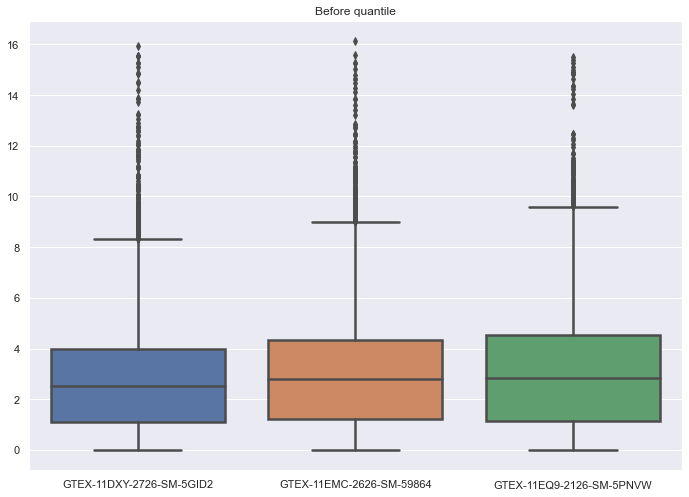

(13956, 229)


GTEX-11DXY-2726-SM-5GID2  GTEX-11EMC-2626-SM-59864  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000187634.11                  0.124566                  0.260267   

                    GTEX-11EQ9-2126-SM-5PNVW  
Name                                          
ENSG00000186092.4                   0.121374  
ENSG00000187634.11                  0.158983

df image after quantile normalization: (13956, 3)


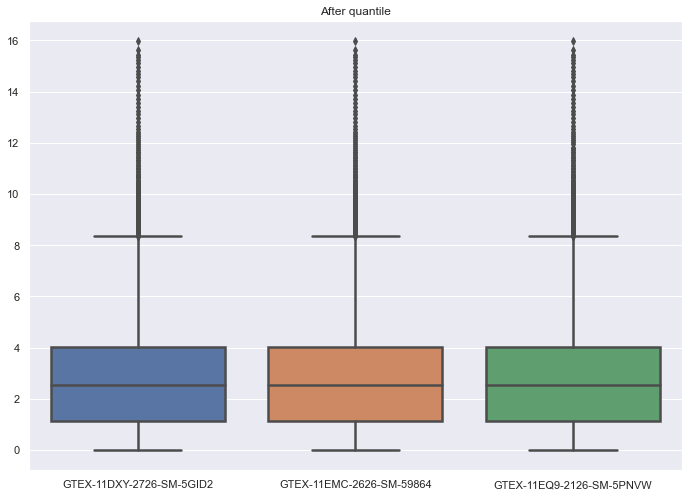

GTEX-11DXY-2726-SM-5GID2  GTEX-11EMC-2626-SM-59864  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000187634.11                  0.111164                  0.243919   

                    GTEX-11EQ9-2126-SM-5PNVW  
Name                                          
ENSG00000186092.4                   0.165845  
ENSG00000187634.11                  0.209278

(229, 8)
sample outliers
(18349, 220)


GTEX-111FC-0126-SM-5N9DL  GTEX-1128S-2326-SM-5GZZY  \
Name                                                                     
ENSG00000186092.4                   0.046980                  0.157691   
ENSG00000278566.1                   0.000000                  0.053292   
ENSG00000273547.1                   0.000000                  0.053292   
ENSG00000187634.11                  1.652142                  0.396927   
ENSG00000188976.10                  6.452035                  6.471350   

                    GTEX-113JC-2326-SM-5EQ4E  GTEX-117XS-2726-SM-5N9BL  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.000000                  0.053389   
ENSG00000273547.1                   0.000000                  0.000000   
ENSG00000187634.11                  0.504264                  0.206018   
ENSG00000188976.10                  6.518220                  6.430620   

                    GTEX-1192W-2626-SM-5Q5AF  GTEX-11DXW-0226-SM-5H122  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.000000                  0.212756   
ENSG00000273547.1                   0.072463                  0.074464   
ENSG00000187634.11                  0.274769                  1.894527   
ENSG00000188976.10                  6.712871                  6.604961   

                    GTEX-11DXY-2626-SM-5GIE7  GTEX-11DYG-0126-SM-59883  \
Name                                                                     
ENSG00000186092.4                   0.076846                  0.064428   
ENSG00000278566.1                   0.075163                  0.063020   
ENSG00000273547.1                   0.000000                  0.123388   
ENSG00000187634.11                  0.881351                  1.385155   
ENSG00000188976.10                  6.440786                  6.557042   

                    GTEX-11EMC-2926-SM-5EQ4F  GTEX-11EQ9-2426-SM-5HL5T  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.000000                  0.000000  ...   
ENSG00000278566.1                   0.171847                  0.090339  ...   
ENSG00000273547.1                   0.088467                  0.000000  ...   
ENSG00000187634.11                  1.547450                  0.233152  ...   
ENSG00000188976.10                  6.857981                  6.435462  ...   

                    GTEX-ZDXO-3026-SM-5J1N5  GTEX-ZE7O-0126-SM-57WC1  \
Name                                                                   
ENSG00000186092.4                  0.341986                 0.210638   
ENSG00000278566.1                  0.000000                 0.106791   
ENSG00000273547.1                  0.120578                 0.106791   
ENSG00000187634.11                 1.502840                 0.947180   
ENSG00000188976.10                 6.291493                 6.565140   

                    GTEX-ZE9C-2726-SM-57WB5  GTEX-ZU9S-0226-SM-5E441  \
Name                                                                   
ENSG00000186092.4                  0.064400                 0.124103   
ENSG00000278566.1                  0.062992                 0.000000   
ENSG00000273547.1                  0.062992                 0.178492   
ENSG00000187634.11                 1.621993                 0.748032   
ENSG00000188976.10                 6.585864                 6.781360   

                    GTEX-ZUA1-0126-SM-5GU76  GTEX-ZV68-0126-SM-59HKS  \
Name                                                                   
ENSG00000186092.4                  0.091815                 0.132419   
ENSG00000278566.1                  0.045611                 0.129586   
ENSG00000273547.1                  0.132722                 0.129586   
ENSG00000187634.11  

SMRIN  SMTSISCH                           SMTSD  \
SAMPID                                                                      
GTEX-111FC-0126-SM-5N9DL    7.2    1036.0  Skin - Sun Exposed (Lower leg)   
GTEX-1128S-2326-SM-5GZZY    7.0     886.0  Skin - Sun Exposed (Lower leg)   
GTEX-113JC-2326-SM-5EQ4E    7.5     681.0  Skin - Sun Exposed (Lower leg)   
GTEX-117XS-2726-SM-5N9BL    6.9     916.0  Skin - Sun Exposed (Lower leg)   
GTEX-1192W-2626-SM-5Q5AF    5.8     810.0  Skin - Sun Exposed (Lower leg)   

                            SMGEBTCH      SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                                 
GTEX-111FC-0126-SM-5N9DL  LCSET-4904  GTEX-111FC  1.0  60-69      1.0  
GTEX-1128S-2326-SM-5GZZY  LCSET-4805  GTEX-1128S  2.0  60-69      2.0  
GTEX-113JC-2326-SM-5EQ4E  LCSET-4767  GTEX-113JC  2.0  50-59      2.0  
GTEX-117XS-2726-SM-5N9BL  LCSET-4904  GTEX-117XS  1.0  60-69      2.0  
GTEX-1192W-2626-SM-5Q5AF  LCSET-4952  GTEX-1192W  1.0  60-69      2.0

isna
GTEX-111FC-0126-SM-5N9DL    0
GTEX-1128S-2326-SM-5GZZY    0
GTEX-113JC-2326-SM-5EQ4E    0
GTEX-117XS-2726-SM-5N9BL    0
GTEX-1192W-2626-SM-5Q5AF    0
                           ..
GTEX-ZV68-0126-SM-59HKS     0
GTEX-ZVT3-0126-SM-5GU6I     0
GTEX-ZVTK-0426-SM-51MRS     0
GTEX-ZYFC-0226-SM-5NQ75     0
GTEX-ZYT6-0226-SM-5NQ6T     0
Length: 220, dtype: int64
GTEX-111FC-0126-SM-5N9DL    0
GTEX-1128S-2326-SM-5GZZY    0
GTEX-113JC-2326-SM-5EQ4E    0
GTEX-117XS-2726-SM-5N9BL    0
GTEX-1192W-2626-SM-5Q5AF    0
                           ..
GTEX-ZV68-0126-SM-59HKS     0
GTEX-ZVT3-0126-SM-5GU6I     0
GTEX-ZVTK-0426-SM-51MRS     0
GTEX-ZYFC-0226-SM-5NQ75     0
GTEX-ZYT6-0226-SM-5NQ6T     0
Length: 220, dtype: int64
wasna
removing outliers
(18349, 220)
<class 'numpy.ndarray'>
components shape
(220, 20)
['GTEX-111FC-0126-SM-5N9DL', 'GTEX-1128S-2326-SM-5GZZY', 'GTEX-113JC-2326-SM-5EQ4E', 'GTEX-117XS-2726-SM-5N9BL', 'GTEX-1192W-2626-SM-5Q5AF', 'GTEX-11DXW-0226-SM-5H122', 'GTEX-11DXY-2626-SM-5GIE7'

GTEX-111FC-0126-SM-5N9DL  GTEX-1128S-2326-SM-5GZZY  \
Name                                                                     
ENSG00000186092.4                   0.046980                  0.157691   
ENSG00000278566.1                   0.000000                  0.053292   
ENSG00000273547.1                   0.000000                  0.053292   
ENSG00000187634.11                  1.652142                  0.396927   
ENSG00000188976.10                  6.452035                  6.471350   

                    GTEX-113JC-2326-SM-5EQ4E  GTEX-117XS-2726-SM-5N9BL  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.000000                  0.053389   
ENSG00000273547.1                   0.000000                  0.000000   
ENSG00000187634.11                  0.504264                  0.206018   
ENSG00000188976.10                  6.518220                  6.430620   

                    GTEX-1192W-2626-SM-5Q5AF  GTEX-11DXW-0226-SM-5H122  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.000000                  0.212756   
ENSG00000273547.1                   0.072463                  0.074464   
ENSG00000187634.11                  0.274769                  1.894527   
ENSG00000188976.10                  6.712871                  6.604961   

                    GTEX-11DXY-2626-SM-5GIE7  GTEX-11DYG-0126-SM-59883  \
Name                                                                     
ENSG00000186092.4                   0.076846                  0.064428   
ENSG00000278566.1                   0.075163                  0.063020   
ENSG00000273547.1                   0.000000                  0.123388   
ENSG00000187634.11                  0.881351                  1.385155   
ENSG00000188976.10                  6.440786                  6.557042   

                    GTEX-11EMC-2926-SM-5EQ4F  GTEX-11EQ9-2426-SM-5HL5T  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.000000                  0.000000  ...   
ENSG00000278566.1                   0.171847                  0.090339  ...   
ENSG00000273547.1                   0.088467                  0.000000  ...   
ENSG00000187634.11                  1.547450                  0.233152  ...   
ENSG00000188976.10                  6.857981                  6.435462  ...   

                    GTEX-ZDXO-3026-SM-5J1N5  GTEX-ZE7O-0126-SM-57WC1  \
Name                                                                   
ENSG00000186092.4                  0.341986                 0.210638   
ENSG00000278566.1                  0.000000                 0.106791   
ENSG00000273547.1                  0.120578                 0.106791   
ENSG00000187634.11                 1.502840                 0.947180   
ENSG00000188976.10                 6.291493                 6.565140   

                    GTEX-ZE9C-2726-SM-57WB5  GTEX-ZU9S-0226-SM-5E441  \
Name                                                                   
ENSG00000186092.4                  0.064400                 0.124103   
ENSG00000278566.1                  0.062992                 0.000000   
ENSG00000273547.1                  0.062992                 0.178492   
ENSG00000187634.11                 1.621993                 0.748032   
ENSG00000188976.10                 6.585864                 6.781360   

                    GTEX-ZUA1-0126-SM-5GU76  GTEX-ZV68-0126-SM-59HKS  \
Name                                                                   
ENSG00000186092.4                  0.091815                 0.132419   
ENSG00000278566.1                  0.045611                 0.129586   
ENSG00000273547.1                  0.132722                 0.129586   
ENSG00000187634.11  

(18349, 220)


SMRIN  SMTSISCH                           SMTSD  \
SAMPID                                                                      
GTEX-111FC-0126-SM-5N9DL    7.2    1036.0  Skin - Sun Exposed (Lower leg)   
GTEX-1128S-2326-SM-5GZZY    7.0     886.0  Skin - Sun Exposed (Lower leg)   
GTEX-113JC-2326-SM-5EQ4E    7.5     681.0  Skin - Sun Exposed (Lower leg)   
GTEX-117XS-2726-SM-5N9BL    6.9     916.0  Skin - Sun Exposed (Lower leg)   
GTEX-1192W-2626-SM-5Q5AF    5.8     810.0  Skin - Sun Exposed (Lower leg)   

                            SMGEBTCH      SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                                 
GTEX-111FC-0126-SM-5N9DL  LCSET-4904  GTEX-111FC  1.0  60-69      1.0  
GTEX-1128S-2326-SM-5GZZY  LCSET-4805  GTEX-1128S  2.0  60-69      2.0  
GTEX-113JC-2326-SM-5EQ4E  LCSET-4767  GTEX-113JC  2.0  50-59      2.0  
GTEX-117XS-2726-SM-5N9BL  LCSET-4904  GTEX-117XS  1.0  60-69      2.0  
GTEX-1192W-2626-SM-5Q5AF  LCSET-4952  GTEX-1192W  1.0  60-69      2.0

(220, 8)
--- Index of Outliers ----
[22, 74, 81, 113]
<class 'list'>
4
22
74
81
113
['GTEX-111FC-0126-SM-5N9DL', 'GTEX-1128S-2326-SM-5GZZY', 'GTEX-113JC-2326-SM-5EQ4E', 'GTEX-117XS-2726-SM-5N9BL']


0         1         2         3         4         5         6   \
0  0.063843  0.096173  0.004317 -0.013550 -0.048251 -0.000078  0.043131   
1  0.065419 -0.000330 -0.065349  0.030196  0.123058  0.067948  0.016564   
2  0.069209 -0.048826 -0.045061 -0.019252  0.008253  0.017633 -0.053719   
3  0.064064  0.100583 -0.024585 -0.028982 -0.000099 -0.005845 -0.095627   
4  0.069151 -0.038947 -0.068199  0.066078 -0.031812 -0.174087  0.099066   

         7         8         9         10        11        12        13  \
0 -0.022926 -0.027555  0.008900  0.017613 -0.083779 -0.029714  0.009800   
1 -0.072651 -0.187098  0.039530 -0.052401  0.032616  0.001977 -0.042198   
2  0.024909 -0.033395  0.003681 -0.138587  0.038378 -0.022737  0.076921   
3 -0.144834  0.039958 -0.014740  0.013088 -0.054342  0.004878  0.008920   
4 -0.163001  0.012282  0.011506 -0.250905  0.127089  0.019965  0.035008   

         14        15        16        17        18        19  
0 -0.060223  0.008704 -0.003921 -0.032080 -0.053735  0.127256  
1 -0.011828 -0.014126 -0.031805  0.125763 -0.128662 -0.089290  
2  0.013046 -0.150092  0.085953  0.024597 -0.064030 -0.004371  
3  0.007129 -0.101659  0.041742  0.017729 -0.034920  0.084600  
4 -0.051434 -0.062287 -0.198435  0.119965  0.088241 -0.081159

dropping outliers
matrix shape before drop
(18349, 220)
matrix shape after drop
(18349, 216)
sample shape before drop
(220, 8)
sample shape after drop
(216, 8)
Name
ENSG00000186092.4     0.027270
ENSG00000278566.1     0.016029
ENSG00000273547.1     0.006822
ENSG00000187634.11    0.179919
ENSG00000188976.10    0.059292
                        ...   
ENSG00000212907.2     0.150062
ENSG00000198886.2     0.122520
ENSG00000198786.2     0.292196
ENSG00000198695.2     0.492077
ENSG00000198727.2     0.138670
Length: 18349, dtype: float64
length of excluded list
2313
df image before quantile normalization: (16036, 3)


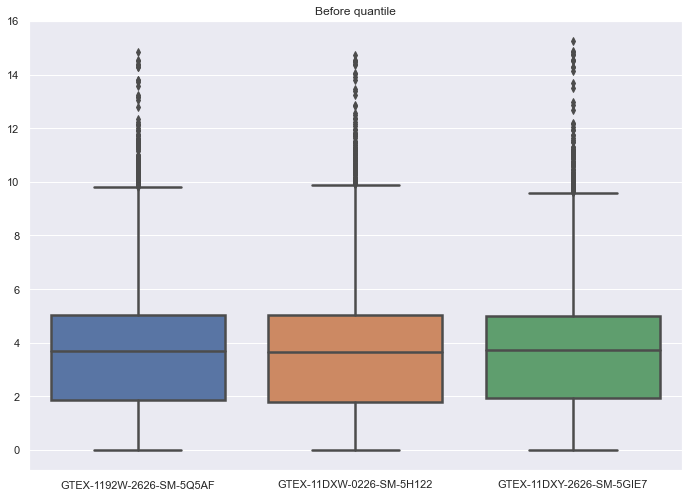

(16036, 216)


GTEX-1192W-2626-SM-5Q5AF  GTEX-11DXW-0226-SM-5H122  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000187634.11                  0.274769                  1.894527   

                    GTEX-11DXY-2626-SM-5GIE7  
Name                                          
ENSG00000186092.4                   0.076846  
ENSG00000187634.11                  0.881351

df image after quantile normalization: (16036, 3)


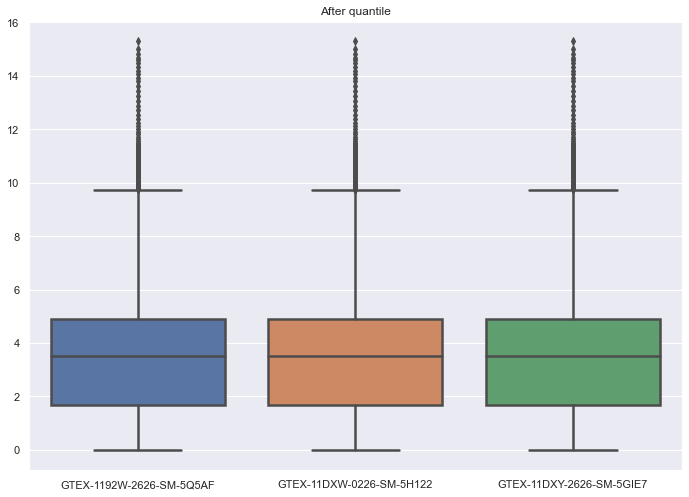

GTEX-1192W-2626-SM-5Q5AF  GTEX-11DXW-0226-SM-5H122  \
Name                                                                     
ENSG00000186092.4                   0.000000                   0.00000   
ENSG00000187634.11                  0.255196                   1.77497   

                    GTEX-11DXY-2626-SM-5GIE7  
Name                                          
ENSG00000186092.4                   0.052269  
ENSG00000187634.11                  0.743539

(216, 8)
sample outliers
(18349, 217)


GTEX-1128S-0005-SM-5P9HI  GTEX-113JC-0006-SM-5O997  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.000000                  0.054821   
ENSG00000187634.11                  0.028993                  0.073916   
ENSG00000188976.10                  4.390255                  3.322793   

                    GTEX-117XS-0005-SM-5PNU6  GTEX-1192W-0005-SM-5NQBQ  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.000000                  0.000000   
ENSG00000187634.11                  0.053876                  0.140255   
ENSG00000188976.10                  4.092546                  4.608218   

                    GTEX-11DXW-0006-SM-5NQ7Y  GTEX-11DXY-0006-SM-5NQ8N  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.000000                  0.063889   
ENSG00000273547.1                   0.063475                  0.063889   
ENSG00000187634.11                  0.181802                  0.069248   
ENSG00000188976.10                  5.692650                  4.539159   

                    GTEX-11DYG-0006-SM-5NQB2  GTEX-11EMC-0006-SM-5O9DN  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.058635                  0.000000   
ENSG00000187634.11                  0.124434                  0.018791   
ENSG00000188976.10                  4.550901                  3.116531   

                    GTEX-11EQ9-0006-SM-5LUB6  GTEX-11GS4-0006-SM-5SI9M  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.056764                  0.000000  ...   
ENSG00000278566.1                   0.000000                  0.053932  ...   
ENSG00000273547.1                   0.000000                  0.053932  ...   
ENSG00000187634.11                  0.103733                  0.195096  ...   
ENSG00000188976.10                  2.973795                  4.656496  ...   

                    GTEX-Z93S-0005-SM-4RGLW  GTEX-ZDTS-0006-SM-4WAYZ  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.000000   
ENSG00000278566.1                  0.047832                 0.000000   
ENSG00000273547.1                  0.000000                 0.000000   
ENSG00000187634.11                 0.605494                 0.049310   
ENSG00000188976.10                 5.647602                 5.550901   

                    GTEX-ZDXO-0006-SM-4WKGF  GTEX-ZE7O-0006-SM-51MTA  \
Name                                                                   
ENSG00000186092.4                  0.052597                 0.177089   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.000000                 0.060130   
ENSG00000187634.11                 0.161178                 0.142740   
ENSG00000188976.10                 5.310704                 4.146492   

                    GTEX-ZE9C-0006-SM-4WKG2  GTEX-ZUA1-0005-SM-4YCEV  \
Name                                                                   
ENSG00000186092.4                  0.116711                 0.302407   
ENSG00000278566.1                  0.000000                 0.053806   
ENSG00000273547.1                  0.000000                 0.053806   
ENSG00000187634.11  

SMRIN  SMTSISCH        SMTSD    SMGEBTCH  \
SAMPID                                                               
GTEX-1128S-0005-SM-5P9HI    6.7     783.0  Whole Blood  LCSET-4916   
GTEX-113JC-0006-SM-5O997    7.6     587.0  Whole Blood  LCSET-4909   
GTEX-117XS-0005-SM-5PNU6    6.4     802.0  Whole Blood  LCSET-4917   
GTEX-1192W-0005-SM-5NQBQ    8.0     645.0  Whole Blood  LCSET-4907   
GTEX-11DXW-0006-SM-5NQ7Y    8.5    1076.0  Whole Blood  LCSET-4906   

                              SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                     
GTEX-1128S-0005-SM-5P9HI  GTEX-1128S  2.0  60-69      2.0  
GTEX-113JC-0006-SM-5O997  GTEX-113JC  2.0  50-59      2.0  
GTEX-117XS-0005-SM-5PNU6  GTEX-117XS  1.0  60-69      2.0  
GTEX-1192W-0005-SM-5NQBQ  GTEX-1192W  1.0  60-69      2.0  
GTEX-11DXW-0006-SM-5NQ7Y  GTEX-11DXW  1.0  40-49      2.0

isna
GTEX-1128S-0005-SM-5P9HI    0
GTEX-113JC-0006-SM-5O997    0
GTEX-117XS-0005-SM-5PNU6    0
GTEX-1192W-0005-SM-5NQBQ    0
GTEX-11DXW-0006-SM-5NQ7Y    0
                           ..
GTEX-ZUA1-0005-SM-4YCEV     0
GTEX-ZV68-0006-SM-4YCEJ     0
GTEX-ZVT3-0006-SM-51MT9     0
GTEX-ZVTK-0006-SM-57WBK     0
GTEX-ZVZQ-0006-SM-51MR8     0
Length: 217, dtype: int64
GTEX-1128S-0005-SM-5P9HI    0
GTEX-113JC-0006-SM-5O997    0
GTEX-117XS-0005-SM-5PNU6    0
GTEX-1192W-0005-SM-5NQBQ    0
GTEX-11DXW-0006-SM-5NQ7Y    0
                           ..
GTEX-ZUA1-0005-SM-4YCEV     0
GTEX-ZV68-0006-SM-4YCEJ     0
GTEX-ZVT3-0006-SM-51MT9     0
GTEX-ZVTK-0006-SM-57WBK     0
GTEX-ZVZQ-0006-SM-51MR8     0
Length: 217, dtype: int64
wasna
removing outliers
(18349, 217)
<class 'numpy.ndarray'>
components shape
(217, 20)
['GTEX-1128S-0005-SM-5P9HI', 'GTEX-113JC-0006-SM-5O997', 'GTEX-117XS-0005-SM-5PNU6', 'GTEX-1192W-0005-SM-5NQBQ', 'GTEX-11DXW-0006-SM-5NQ7Y', 'GTEX-11DXY-0006-SM-5NQ8N', 'GTEX-11DYG-0006-SM-5NQB2'

GTEX-1128S-0005-SM-5P9HI  GTEX-113JC-0006-SM-5O997  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.000000                  0.054821   
ENSG00000187634.11                  0.028993                  0.073916   
ENSG00000188976.10                  4.390255                  3.322793   

                    GTEX-117XS-0005-SM-5PNU6  GTEX-1192W-0005-SM-5NQBQ  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.000000                  0.000000   
ENSG00000187634.11                  0.053876                  0.140255   
ENSG00000188976.10                  4.092546                  4.608218   

                    GTEX-11DXW-0006-SM-5NQ7Y  GTEX-11DXY-0006-SM-5NQ8N  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.000000                  0.063889   
ENSG00000273547.1                   0.063475                  0.063889   
ENSG00000187634.11                  0.181802                  0.069248   
ENSG00000188976.10                  5.692650                  4.539159   

                    GTEX-11DYG-0006-SM-5NQB2  GTEX-11EMC-0006-SM-5O9DN  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.058635                  0.000000   
ENSG00000187634.11                  0.124434                  0.018791   
ENSG00000188976.10                  4.550901                  3.116531   

                    GTEX-11EQ9-0006-SM-5LUB6  GTEX-11GS4-0006-SM-5SI9M  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.056764                  0.000000  ...   
ENSG00000278566.1                   0.000000                  0.053932  ...   
ENSG00000273547.1                   0.000000                  0.053932  ...   
ENSG00000187634.11                  0.103733                  0.195096  ...   
ENSG00000188976.10                  2.973795                  4.656496  ...   

                    GTEX-Z93S-0005-SM-4RGLW  GTEX-ZDTS-0006-SM-4WAYZ  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.000000   
ENSG00000278566.1                  0.047832                 0.000000   
ENSG00000273547.1                  0.000000                 0.000000   
ENSG00000187634.11                 0.605494                 0.049310   
ENSG00000188976.10                 5.647602                 5.550901   

                    GTEX-ZDXO-0006-SM-4WKGF  GTEX-ZE7O-0006-SM-51MTA  \
Name                                                                   
ENSG00000186092.4                  0.052597                 0.177089   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.000000                 0.060130   
ENSG00000187634.11                 0.161178                 0.142740   
ENSG00000188976.10                 5.310704                 4.146492   

                    GTEX-ZE9C-0006-SM-4WKG2  GTEX-ZUA1-0005-SM-4YCEV  \
Name                                                                   
ENSG00000186092.4                  0.116711                 0.302407   
ENSG00000278566.1                  0.000000                 0.053806   
ENSG00000273547.1                  0.000000                 0.053806   
ENSG00000187634.11  

(18349, 217)


SMRIN  SMTSISCH        SMTSD    SMGEBTCH  \
SAMPID                                                               
GTEX-1128S-0005-SM-5P9HI    6.7     783.0  Whole Blood  LCSET-4916   
GTEX-113JC-0006-SM-5O997    7.6     587.0  Whole Blood  LCSET-4909   
GTEX-117XS-0005-SM-5PNU6    6.4     802.0  Whole Blood  LCSET-4917   
GTEX-1192W-0005-SM-5NQBQ    8.0     645.0  Whole Blood  LCSET-4907   
GTEX-11DXW-0006-SM-5NQ7Y    8.5    1076.0  Whole Blood  LCSET-4906   

                              SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                     
GTEX-1128S-0005-SM-5P9HI  GTEX-1128S  2.0  60-69      2.0  
GTEX-113JC-0006-SM-5O997  GTEX-113JC  2.0  50-59      2.0  
GTEX-117XS-0005-SM-5PNU6  GTEX-117XS  1.0  60-69      2.0  
GTEX-1192W-0005-SM-5NQBQ  GTEX-1192W  1.0  60-69      2.0  
GTEX-11DXW-0006-SM-5NQ7Y  GTEX-11DXW  1.0  40-49      2.0

(217, 8)
--- Index of Outliers ----
[18, 23, 75, 79, 172, 207]
<class 'list'>
6
18
23
75
79
172
207
['GTEX-1128S-0005-SM-5P9HI', 'GTEX-113JC-0006-SM-5O997', 'GTEX-117XS-0005-SM-5PNU6', 'GTEX-1192W-0005-SM-5NQBQ', 'GTEX-11DXW-0006-SM-5NQ7Y', 'GTEX-11DXY-0006-SM-5NQ8N']


0         1         2         3         4         5         6   \
0  0.073058 -0.024866  0.047507 -0.103980 -0.064328 -0.118506 -0.027740   
1  0.060540  0.057840  0.096559 -0.006626 -0.059115  0.090584  0.036560   
2  0.058860  0.101137 -0.089454 -0.003626  0.041026 -0.067098 -0.068212   
3  0.066566  0.043335 -0.024912 -0.058081 -0.015925 -0.017148 -0.064497   
4  0.076726 -0.019641 -0.060043 -0.116275  0.118412  0.007313 -0.025328   

         7         8         9         10        11        12        13  \
0 -0.083054  0.050779 -0.202895 -0.082231 -0.144602 -0.005588 -0.047845   
1 -0.051609  0.011575  0.026588  0.020973  0.017999 -0.133148  0.017922   
2  0.026901 -0.012691 -0.027187 -0.001603 -0.001908 -0.045228  0.029011   
3  0.021328 -0.046705  0.014756  0.084624  0.055574  0.013158 -0.018584   
4  0.069646  0.122237  0.131804  0.058819 -0.022337  0.060072  0.133130   

         14        15        16        17        18        19  
0 -0.081728 -0.233240  0.158861 -0.018330 -0.071686 -0.033380  
1  0.176916  0.008087  0.036389 -0.075274  0.043597  0.024893  
2 -0.022543  0.021128 -0.044517 -0.027657  0.071243  0.008386  
3  0.032173  0.019373 -0.013734  0.107214 -0.052437 -0.003870  
4  0.021916  0.028730  0.048075  0.088731  0.122909 -0.100695

dropping outliers
matrix shape before drop
(18349, 217)
matrix shape after drop
(18349, 211)
sample shape before drop
(217, 8)
sample shape after drop
(211, 8)
Name
ENSG00000186092.4     0.004026
ENSG00000278566.1     0.002438
ENSG00000273547.1     0.000980
ENSG00000187634.11    0.006431
ENSG00000188976.10    0.728694
                        ...   
ENSG00000212907.2     0.748612
ENSG00000198886.2     0.676060
ENSG00000198786.2     0.805722
ENSG00000198695.2     1.059679
ENSG00000198727.2     0.764864
Length: 18349, dtype: float64
length of excluded list
4405
df image before quantile normalization: (13944, 3)


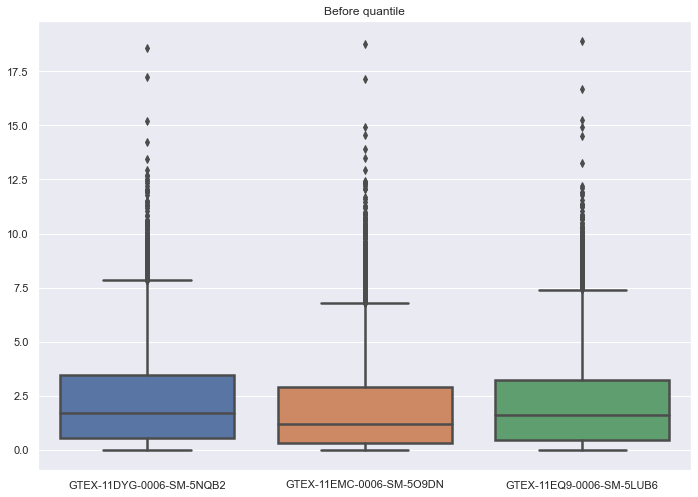

(13944, 211)


GTEX-11DYG-0006-SM-5NQB2  GTEX-11EMC-0006-SM-5O9DN  \
Name                                                                     
ENSG00000188976.10                  4.550901                  3.116531   
ENSG00000187961.13                  2.306846                  1.501312   

                    GTEX-11EQ9-0006-SM-5LUB6  
Name                                          
ENSG00000188976.10                  2.973795  
ENSG00000187961.13                  1.204141

df image after quantile normalization: (13944, 3)


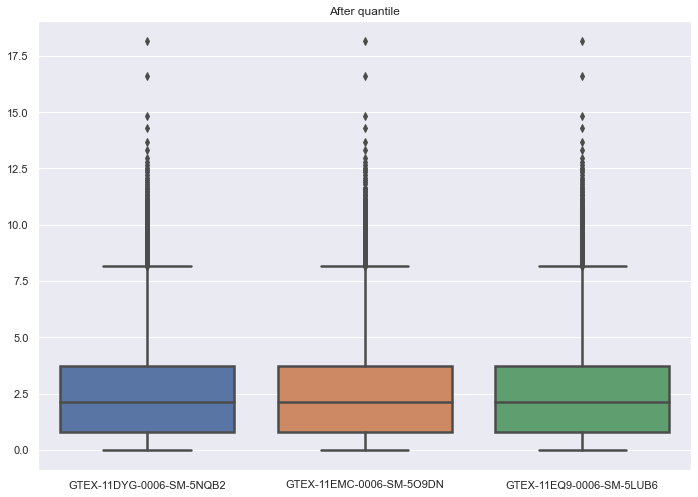

GTEX-11DYG-0006-SM-5NQB2  GTEX-11EMC-0006-SM-5O9DN  \
Name                                                                     
ENSG00000188976.10                  4.789045                  3.931109   
ENSG00000187961.13                  2.683655                  2.456994   

                    GTEX-11EQ9-0006-SM-5LUB6  
Name                                          
ENSG00000188976.10                  3.463215  
ENSG00000187961.13                  1.686533

(211, 8)
sample outliers
(18349, 197)


GTEX-111FC-0226-SM-5N9B8  GTEX-1128S-2126-SM-5H12U  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.080985   
ENSG00000278566.1                   0.000000                  0.079224   
ENSG00000273547.1                   0.054598                  0.079224   
ENSG00000187634.11                  1.430820                  0.963548   
ENSG00000188976.10                  5.732541                  5.714246   

                    GTEX-11DXW-0326-SM-5H11W  GTEX-11EMC-2826-SM-5PNY6  \
Name                                                                     
ENSG00000186092.4                   0.075341                  0.050230   
ENSG00000278566.1                   0.000000                  0.049129   
ENSG00000273547.1                   0.073697                  0.049129   
ENSG00000187634.11                  2.201634                  0.271306   
ENSG00000188976.10                  5.708463                  6.592756   

                    GTEX-11EQ9-2526-SM-5HL66  GTEX-11GS4-2626-SM-5A5LD  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.070156   
ENSG00000278566.1                   0.066923                  0.068616   
ENSG00000273547.1                   0.066923                  0.068616   
ENSG00000187634.11                  0.458172                  1.498251   
ENSG00000188976.10                  5.219943                  5.331275   

                    GTEX-11GSO-2326-SM-5A5LX  GTEX-11H98-0226-SM-5NQ89  \
Name                                                                     
ENSG00000186092.4                   0.350158                  0.070224   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.075464                  0.068698   
ENSG00000187634.11                  0.385376                  0.037706   
ENSG00000188976.10                  5.665052                  6.082575   

                    GTEX-11NUK-0326-SM-5HL5K  GTEX-11O72-0226-SM-59869  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.051720                  0.000000  ...   
ENSG00000278566.1                   0.050578                  0.067391  ...   
ENSG00000273547.1                   0.000000                  0.193456  ...   
ENSG00000187634.11                  1.758303                  0.892818  ...   
ENSG00000188976.10                  5.662490                  5.832131  ...   

                    GTEX-ZAK1-0226-SM-5CVMX  GTEX-ZDTS-0226-SM-5HL7Q  \
Name                                                                   
ENSG00000186092.4                  0.105061                 0.071131   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.151599                 0.135955   
ENSG00000187634.11                 0.792189                 1.413052   
ENSG00000188976.10                 5.186659                 5.671859   

                    GTEX-ZDXO-2426-SM-5S2NJ  GTEX-ZE7O-0226-SM-5S2N1  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.000000   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.000000                 0.000000   
ENSG00000187634.11                 1.906891                 0.833011   
ENSG00000188976.10                 5.907852                 5.725469   

                    GTEX-ZE9C-2826-SM-5S2MO  GTEX-ZUA1-0226-SM-5NQ9Q  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.168642   
ENSG00000278566.1                  0.000000                 0.057152   
ENSG00000273547.1                  0.065862                 0.057152   
ENSG00000187634.11  

SMRIN  SMTSISCH                   SMTSD    SMGEBTCH  \
SAMPID                                                                          
GTEX-111FC-0226-SM-5N9B8    7.3    1040.0  Adipose - Subcutaneous  LCSET-4904   
GTEX-1128S-2126-SM-5H12U    6.5     882.0  Adipose - Subcutaneous  LCSET-4805   
GTEX-11DXW-0326-SM-5H11W    7.3    1092.0  Adipose - Subcutaneous  LCSET-4805   
GTEX-11EMC-2826-SM-5PNY6    8.1     808.0  Adipose - Subcutaneous  LCSET-4918   
GTEX-11EQ9-2526-SM-5HL66    6.9     321.0  Adipose - Subcutaneous  LCSET-4806   

                              SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                     
GTEX-111FC-0226-SM-5N9B8  GTEX-111FC  1.0  60-69      1.0  
GTEX-1128S-2126-SM-5H12U  GTEX-1128S  2.0  60-69      2.0  
GTEX-11DXW-0326-SM-5H11W  GTEX-11DXW  1.0  40-49      2.0  
GTEX-11EMC-2826-SM-5PNY6  GTEX-11EMC  2.0  60-69      2.0  
GTEX-11EQ9-2526-SM-5HL66  GTEX-11EQ9  1.0  30-39      2.0

isna
GTEX-111FC-0226-SM-5N9B8    0
GTEX-1128S-2126-SM-5H12U    0
GTEX-11DXW-0326-SM-5H11W    0
GTEX-11EMC-2826-SM-5PNY6    0
GTEX-11EQ9-2526-SM-5HL66    0
                           ..
GTEX-ZUA1-0226-SM-5NQ9Q     0
GTEX-ZV68-0226-SM-59HJF     0
GTEX-ZVTK-0526-SM-5GZWT     0
GTEX-ZYFC-0326-SM-5NQ7H     0
GTEX-ZYT6-0326-SM-7LG5R     0
Length: 197, dtype: int64
GTEX-111FC-0226-SM-5N9B8    0
GTEX-1128S-2126-SM-5H12U    0
GTEX-11DXW-0326-SM-5H11W    0
GTEX-11EMC-2826-SM-5PNY6    0
GTEX-11EQ9-2526-SM-5HL66    0
                           ..
GTEX-ZUA1-0226-SM-5NQ9Q     0
GTEX-ZV68-0226-SM-59HJF     0
GTEX-ZVTK-0526-SM-5GZWT     0
GTEX-ZYFC-0326-SM-5NQ7H     0
GTEX-ZYT6-0326-SM-7LG5R     0
Length: 197, dtype: int64
wasna
removing outliers
(18349, 197)
<class 'numpy.ndarray'>
components shape
(197, 20)
['GTEX-111FC-0226-SM-5N9B8', 'GTEX-1128S-2126-SM-5H12U', 'GTEX-11DXW-0326-SM-5H11W', 'GTEX-11EMC-2826-SM-5PNY6', 'GTEX-11EQ9-2526-SM-5HL66', 'GTEX-11GS4-2626-SM-5A5LD', 'GTEX-11GSO-2326-SM-5A5LX'

GTEX-111FC-0226-SM-5N9B8  GTEX-1128S-2126-SM-5H12U  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.080985   
ENSG00000278566.1                   0.000000                  0.079224   
ENSG00000273547.1                   0.054598                  0.079224   
ENSG00000187634.11                  1.430820                  0.963548   
ENSG00000188976.10                  5.732541                  5.714246   

                    GTEX-11DXW-0326-SM-5H11W  GTEX-11EMC-2826-SM-5PNY6  \
Name                                                                     
ENSG00000186092.4                   0.075341                  0.050230   
ENSG00000278566.1                   0.000000                  0.049129   
ENSG00000273547.1                   0.073697                  0.049129   
ENSG00000187634.11                  2.201634                  0.271306   
ENSG00000188976.10                  5.708463                  6.592756   

                    GTEX-11EQ9-2526-SM-5HL66  GTEX-11GS4-2626-SM-5A5LD  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.070156   
ENSG00000278566.1                   0.066923                  0.068616   
ENSG00000273547.1                   0.066923                  0.068616   
ENSG00000187634.11                  0.458172                  1.498251   
ENSG00000188976.10                  5.219943                  5.331275   

                    GTEX-11GSO-2326-SM-5A5LX  GTEX-11H98-0226-SM-5NQ89  \
Name                                                                     
ENSG00000186092.4                   0.350158                  0.070224   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.075464                  0.068698   
ENSG00000187634.11                  0.385376                  0.037706   
ENSG00000188976.10                  5.665052                  6.082575   

                    GTEX-11NUK-0326-SM-5HL5K  GTEX-11O72-0226-SM-59869  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.051720                  0.000000  ...   
ENSG00000278566.1                   0.050578                  0.067391  ...   
ENSG00000273547.1                   0.000000                  0.193456  ...   
ENSG00000187634.11                  1.758303                  0.892818  ...   
ENSG00000188976.10                  5.662490                  5.832131  ...   

                    GTEX-ZAK1-0226-SM-5CVMX  GTEX-ZDTS-0226-SM-5HL7Q  \
Name                                                                   
ENSG00000186092.4                  0.105061                 0.071131   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.151599                 0.135955   
ENSG00000187634.11                 0.792189                 1.413052   
ENSG00000188976.10                 5.186659                 5.671859   

                    GTEX-ZDXO-2426-SM-5S2NJ  GTEX-ZE7O-0226-SM-5S2N1  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.000000   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.000000                 0.000000   
ENSG00000187634.11                 1.906891                 0.833011   
ENSG00000188976.10                 5.907852                 5.725469   

                    GTEX-ZE9C-2826-SM-5S2MO  GTEX-ZUA1-0226-SM-5NQ9Q  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.168642   
ENSG00000278566.1                  0.000000                 0.057152   
ENSG00000273547.1                  0.065862                 0.057152   
ENSG00000187634.11  

(18349, 197)


SMRIN  SMTSISCH                   SMTSD    SMGEBTCH  \
SAMPID                                                                          
GTEX-111FC-0226-SM-5N9B8    7.3    1040.0  Adipose - Subcutaneous  LCSET-4904   
GTEX-1128S-2126-SM-5H12U    6.5     882.0  Adipose - Subcutaneous  LCSET-4805   
GTEX-11DXW-0326-SM-5H11W    7.3    1092.0  Adipose - Subcutaneous  LCSET-4805   
GTEX-11EMC-2826-SM-5PNY6    8.1     808.0  Adipose - Subcutaneous  LCSET-4918   
GTEX-11EQ9-2526-SM-5HL66    6.9     321.0  Adipose - Subcutaneous  LCSET-4806   

                              SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                     
GTEX-111FC-0226-SM-5N9B8  GTEX-111FC  1.0  60-69      1.0  
GTEX-1128S-2126-SM-5H12U  GTEX-1128S  2.0  60-69      2.0  
GTEX-11DXW-0326-SM-5H11W  GTEX-11DXW  1.0  40-49      2.0  
GTEX-11EMC-2826-SM-5PNY6  GTEX-11EMC  2.0  60-69      2.0  
GTEX-11EQ9-2526-SM-5HL66  GTEX-11EQ9  1.0  30-39      2.0

(197, 8)
--- Index of Outliers ----
[33, 62, 189]
<class 'list'>
3
33
62
189
['GTEX-111FC-0226-SM-5N9B8', 'GTEX-1128S-2126-SM-5H12U', 'GTEX-11DXW-0326-SM-5H11W']


0         1         2         3         4         5         6   \
0  0.072676 -0.117040  0.043431 -0.004746  0.000740 -0.085873 -0.090472   
1  0.069950  0.174631 -0.087653  0.065317 -0.004942  0.023144 -0.010068   
2  0.069722 -0.099012 -0.035080  0.002438  0.012450  0.093487  0.073171   
3  0.071145  0.128949 -0.040242  0.118502  0.110962 -0.060194 -0.021444   
4  0.067811  0.075644 -0.156951  0.071453  0.046418 -0.037013  0.068527   

         7         8         9         10        11        12        13  \
0 -0.009645 -0.020956  0.056866 -0.052984 -0.003034  0.002557  0.023259   
1 -0.058428 -0.125578 -0.009052  0.043045  0.075390 -0.067769 -0.117259   
2  0.003537  0.070406  0.098124  0.032093  0.025056  0.002451 -0.021542   
3  0.161661  0.059780 -0.032884 -0.045856  0.056027  0.023605 -0.251666   
4  0.099133 -0.102388  0.122693 -0.012148  0.032899  0.009887  0.051104   

         14        15        16        17        18        19  
0  0.006350 -0.003586 -0.017107  0.009692 -0.065852 -0.045668  
1 -0.005284  0.062380  0.002073  0.093494  0.085892 -0.150899  
2  0.068035  0.153328  0.008563 -0.019367 -0.061577 -0.013779  
3 -0.060340  0.137409 -0.124473 -0.023006 -0.018425 -0.054278  
4  0.037652  0.039196 -0.015835  0.094994  0.028357  0.014654

dropping outliers
matrix shape before drop
(18349, 197)
matrix shape after drop
(18349, 194)
sample shape before drop
(197, 8)
sample shape after drop
(194, 8)
Name
ENSG00000186092.4     0.024108
ENSG00000278566.1     0.016225
ENSG00000273547.1     0.005613
ENSG00000187634.11    0.413543
ENSG00000188976.10    0.071381
                        ...   
ENSG00000212907.2     0.282278
ENSG00000198886.2     0.215180
ENSG00000198786.2     0.177660
ENSG00000198695.2     0.314244
ENSG00000198727.2     0.158766
Length: 18349, dtype: float64
length of excluded list
2653
df image before quantile normalization: (15696, 3)


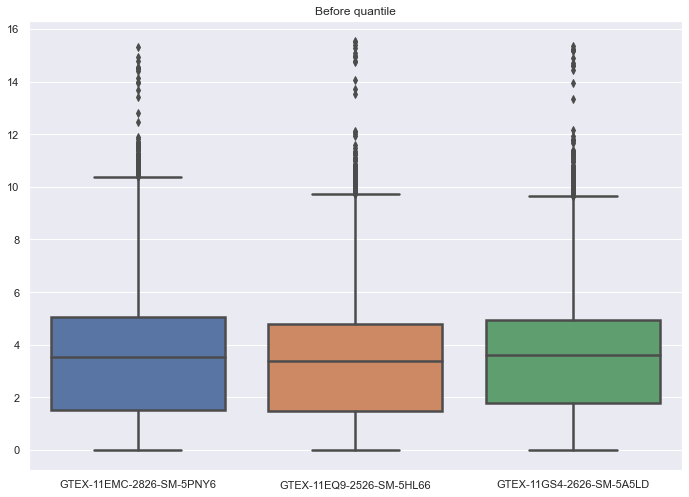

(15696, 194)


GTEX-11EMC-2826-SM-5PNY6  GTEX-11EQ9-2526-SM-5HL66  \
Name                                                                     
ENSG00000186092.4                   0.050230                  0.000000   
ENSG00000187634.11                  0.271306                  0.458172   

                    GTEX-11GS4-2626-SM-5A5LD  
Name                                          
ENSG00000186092.4                   0.070156  
ENSG00000187634.11                  1.498251

df image after quantile normalization: (15696, 3)


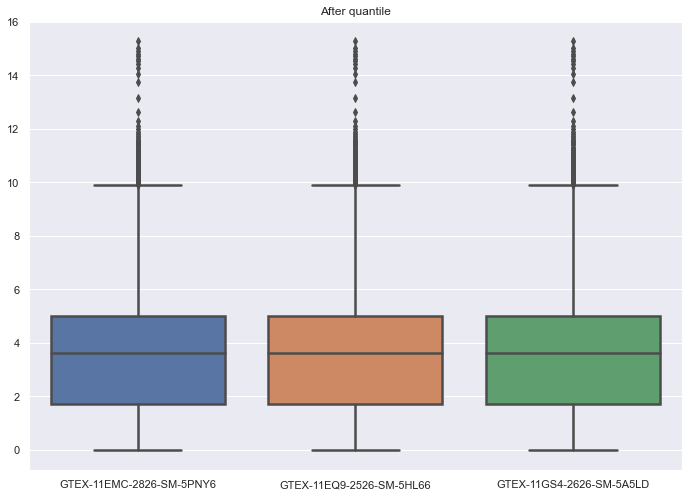

GTEX-11EMC-2826-SM-5PNY6  GTEX-11EQ9-2526-SM-5HL66  \
Name                                                                     
ENSG00000186092.4                   0.077959                  0.000000   
ENSG00000187634.11                  0.363414                  0.629681   

                    GTEX-11GS4-2626-SM-5A5LD  
Name                                          
ENSG00000186092.4                   0.035110  
ENSG00000187634.11                  1.430179

(194, 8)
sample outliers
(18349, 196)


GTEX-111FC-1026-SM-5GZX1  GTEX-1128S-0126-SM-5H12S  \
Name                                                                     
ENSG00000186092.4                   0.074560                  0.095884   
ENSG00000278566.1                   0.072943                  0.000000   
ENSG00000273547.1                   0.000000                  0.181929   
ENSG00000187634.11                  3.453254                  1.851199   
ENSG00000188976.10                  5.982537                  6.520108   

                    GTEX-113JC-0126-SM-5EGJW  GTEX-117XS-0526-SM-5987Q  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.106308   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.000000                  0.201006   
ENSG00000187634.11                  2.266936                  2.862154   
ENSG00000188976.10                  6.083001                  6.211986   

                    GTEX-1192W-0126-SM-5EGGS  GTEX-11DXY-0426-SM-5H12R  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.095263                  0.156008   
ENSG00000273547.1                   0.000000                  0.080085   
ENSG00000187634.11                  2.228973                  4.291309   
ENSG00000188976.10                  6.366322                  6.177719   

                    GTEX-11DYG-0826-SM-5N9GH  GTEX-11EMC-0226-SM-5EGLP  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.000000                  0.063889   
ENSG00000273547.1                   0.000000                  0.125069   
ENSG00000187634.11                  3.294841                  2.175045   
ENSG00000188976.10                  6.375735                  6.062856   

                    GTEX-11EQ9-0626-SM-5A5K1  GTEX-11GS4-0826-SM-5986J  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.052319                  0.165430  ...   
ENSG00000278566.1                   0.000000                  0.236462  ...   
ENSG00000273547.1                   0.000000                  0.161952  ...   
ENSG00000187634.11                  3.303050                  2.731618  ...   
ENSG00000188976.10                  5.898450                  6.265662  ...   

                    GTEX-Z93S-0526-SM-EVYB4  GTEX-ZAK1-0726-SM-5HL8Q  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.086322   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.051706                 0.084445   
ENSG00000187634.11                 3.550901                 3.038436   
ENSG00000188976.10                 5.574102                 6.069315   

                    GTEX-ZDTS-0926-SM-5YY9D  GTEX-ZDXO-1726-SM-5HL6L  \
Name                                                                   
ENSG00000186092.4                  0.125347                 0.058704   
ENSG00000278566.1                  0.000000                 0.057429   
ENSG00000273547.1                  0.062633                 0.217107   
ENSG00000187634.11                 4.440288                 2.054154   
ENSG00000188976.10                 6.217425                 6.217812   

                    GTEX-ZE7O-1126-SM-57WC8  GTEX-ZUA1-0926-SM-4YCDX  \
Name                                                                   
ENSG00000186092.4                  0.120405                 0.000000   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.000000                 0.282499   
ENSG00000187634.11  

SMRIN  SMTSISCH    SMTSD               SMGEBTCH  \
SAMPID                                                                      
GTEX-111FC-1026-SM-5GZX1    5.9    1078.0  Thyroid             LCSET-4804   
GTEX-1128S-0126-SM-5H12S    6.6     820.0  Thyroid             LCSET-4805   
GTEX-113JC-0126-SM-5EGJW    5.8     627.0  Thyroid  LCSET-4766,LCSET-4797   
GTEX-117XS-0526-SM-5987Q    7.0     859.0  Thyroid             LCSET-4417   
GTEX-1192W-0126-SM-5EGGS    6.2     674.0  Thyroid             LCSET-4764   

                              SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                     
GTEX-111FC-1026-SM-5GZX1  GTEX-111FC  1.0  60-69      1.0  
GTEX-1128S-0126-SM-5H12S  GTEX-1128S  2.0  60-69      2.0  
GTEX-113JC-0126-SM-5EGJW  GTEX-113JC  2.0  50-59      2.0  
GTEX-117XS-0526-SM-5987Q  GTEX-117XS  1.0  60-69      2.0  
GTEX-1192W-0126-SM-5EGGS  GTEX-1192W  1.0  60-69      2.0

isna
GTEX-111FC-1026-SM-5GZX1    0
GTEX-1128S-0126-SM-5H12S    0
GTEX-113JC-0126-SM-5EGJW    0
GTEX-117XS-0526-SM-5987Q    0
GTEX-1192W-0126-SM-5EGGS    0
                           ..
GTEX-ZUA1-0926-SM-4YCDX     0
GTEX-ZVT3-0726-SM-5GICN     0
GTEX-ZVZQ-0626-SM-59HJU     0
GTEX-ZYFC-0926-SM-5GZWW     0
GTEX-ZYT6-0426-SM-5GID3     0
Length: 196, dtype: int64
GTEX-111FC-1026-SM-5GZX1    0
GTEX-1128S-0126-SM-5H12S    0
GTEX-113JC-0126-SM-5EGJW    0
GTEX-117XS-0526-SM-5987Q    0
GTEX-1192W-0126-SM-5EGGS    0
                           ..
GTEX-ZUA1-0926-SM-4YCDX     0
GTEX-ZVT3-0726-SM-5GICN     0
GTEX-ZVZQ-0626-SM-59HJU     0
GTEX-ZYFC-0926-SM-5GZWW     0
GTEX-ZYT6-0426-SM-5GID3     0
Length: 196, dtype: int64
wasna
removing outliers
(18349, 196)
<class 'numpy.ndarray'>
components shape
(196, 20)
['GTEX-111FC-1026-SM-5GZX1', 'GTEX-1128S-0126-SM-5H12S', 'GTEX-113JC-0126-SM-5EGJW', 'GTEX-117XS-0526-SM-5987Q', 'GTEX-1192W-0126-SM-5EGGS', 'GTEX-11DXY-0426-SM-5H12R', 'GTEX-11DYG-0826-SM-5N9GH'

GTEX-111FC-1026-SM-5GZX1  GTEX-1128S-0126-SM-5H12S  \
Name                                                                     
ENSG00000186092.4                   0.074560                  0.095884   
ENSG00000278566.1                   0.072943                  0.000000   
ENSG00000273547.1                   0.000000                  0.181929   
ENSG00000187634.11                  3.453254                  1.851199   
ENSG00000188976.10                  5.982537                  6.520108   

                    GTEX-113JC-0126-SM-5EGJW  GTEX-117XS-0526-SM-5987Q  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.106308   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.000000                  0.201006   
ENSG00000187634.11                  2.266936                  2.862154   
ENSG00000188976.10                  6.083001                  6.211986   

                    GTEX-1192W-0126-SM-5EGGS  GTEX-11DXY-0426-SM-5H12R  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.095263                  0.156008   
ENSG00000273547.1                   0.000000                  0.080085   
ENSG00000187634.11                  2.228973                  4.291309   
ENSG00000188976.10                  6.366322                  6.177719   

                    GTEX-11DYG-0826-SM-5N9GH  GTEX-11EMC-0226-SM-5EGLP  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.000000                  0.063889   
ENSG00000273547.1                   0.000000                  0.125069   
ENSG00000187634.11                  3.294841                  2.175045   
ENSG00000188976.10                  6.375735                  6.062856   

                    GTEX-11EQ9-0626-SM-5A5K1  GTEX-11GS4-0826-SM-5986J  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.052319                  0.165430  ...   
ENSG00000278566.1                   0.000000                  0.236462  ...   
ENSG00000273547.1                   0.000000                  0.161952  ...   
ENSG00000187634.11                  3.303050                  2.731618  ...   
ENSG00000188976.10                  5.898450                  6.265662  ...   

                    GTEX-Z93S-0526-SM-EVYB4  GTEX-ZAK1-0726-SM-5HL8Q  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.086322   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.051706                 0.084445   
ENSG00000187634.11                 3.550901                 3.038436   
ENSG00000188976.10                 5.574102                 6.069315   

                    GTEX-ZDTS-0926-SM-5YY9D  GTEX-ZDXO-1726-SM-5HL6L  \
Name                                                                   
ENSG00000186092.4                  0.125347                 0.058704   
ENSG00000278566.1                  0.000000                 0.057429   
ENSG00000273547.1                  0.062633                 0.217107   
ENSG00000187634.11                 4.440288                 2.054154   
ENSG00000188976.10                 6.217425                 6.217812   

                    GTEX-ZE7O-1126-SM-57WC8  GTEX-ZUA1-0926-SM-4YCDX  \
Name                                                                   
ENSG00000186092.4                  0.120405                 0.000000   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.000000                 0.282499   
ENSG00000187634.11  

(18349, 196)


SMRIN  SMTSISCH    SMTSD               SMGEBTCH  \
SAMPID                                                                      
GTEX-111FC-1026-SM-5GZX1    5.9    1078.0  Thyroid             LCSET-4804   
GTEX-1128S-0126-SM-5H12S    6.6     820.0  Thyroid             LCSET-4805   
GTEX-113JC-0126-SM-5EGJW    5.8     627.0  Thyroid  LCSET-4766,LCSET-4797   
GTEX-117XS-0526-SM-5987Q    7.0     859.0  Thyroid             LCSET-4417   
GTEX-1192W-0126-SM-5EGGS    6.2     674.0  Thyroid             LCSET-4764   

                              SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                     
GTEX-111FC-1026-SM-5GZX1  GTEX-111FC  1.0  60-69      1.0  
GTEX-1128S-0126-SM-5H12S  GTEX-1128S  2.0  60-69      2.0  
GTEX-113JC-0126-SM-5EGJW  GTEX-113JC  2.0  50-59      2.0  
GTEX-117XS-0526-SM-5987Q  GTEX-117XS  1.0  60-69      2.0  
GTEX-1192W-0126-SM-5EGGS  GTEX-1192W  1.0  60-69      2.0

(196, 8)
--- Index of Outliers ----
[62, 73]
<class 'list'>
2
62
73
['GTEX-111FC-1026-SM-5GZX1', 'GTEX-1128S-0126-SM-5H12S']


0         1         2         3         4         5         6   \
0  0.071501 -0.111821 -0.025177 -0.028980 -0.040626 -0.044949  0.006482   
1  0.072908  0.094200 -0.070901 -0.000319  0.014631 -0.093802  0.044884   
2  0.070579  0.124718 -0.100330  0.047382  0.088229  0.042691 -0.007520   
3  0.072493  0.002824  0.009848  0.060754  0.006505  0.019770 -0.020299   
4  0.072000 -0.041831 -0.034321 -0.045939  0.077056 -0.037309  0.021552   

         7         8         9         10        11        12        13  \
0 -0.070282 -0.057039 -0.161512  0.040147 -0.026015  0.036768 -0.018396   
1  0.024494  0.003236 -0.021773  0.001693  0.011448 -0.020341 -0.024833   
2 -0.067931  0.063895  0.047591 -0.022677 -0.170237 -0.038691  0.028430   
3  0.076049 -0.013333  0.097994 -0.154087  0.018451 -0.012072  0.003478   
4  0.009145 -0.110883  0.010416 -0.038499  0.105783  0.039028  0.073823   

         14        15        16        17        18        19  
0 -0.048920 -0.106764 -0.015742 -0.085347  0.125442 -0.102532  
1  0.054304  0.049669 -0.177135  0.022301  0.010299 -0.024396  
2  0.091973  0.335335 -0.098001 -0.097630  0.070805 -0.182271  
3  0.126368  0.039819 -0.014478 -0.085283  0.055522 -0.037566  
4  0.174392  0.074674  0.047514 -0.040399 -0.060493  0.027926

dropping outliers
matrix shape before drop
(18349, 196)
matrix shape after drop
(18349, 194)
sample shape before drop
(196, 8)
sample shape after drop
(194, 8)
Name
ENSG00000186092.4     0.006514
ENSG00000278566.1     0.006858
ENSG00000273547.1     0.004619
ENSG00000187634.11    0.737156
ENSG00000188976.10    0.053114
                        ...   
ENSG00000212907.2     0.906646
ENSG00000198886.2     0.867909
ENSG00000198786.2     0.482811
ENSG00000198695.2     0.606806
ENSG00000198727.2     0.566917
Length: 18349, dtype: float64
length of excluded list
2332
df image before quantile normalization: (16017, 3)


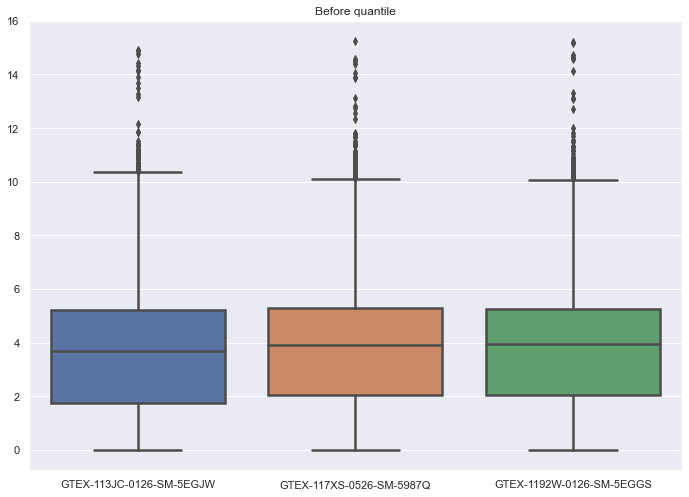

(16017, 194)


GTEX-113JC-0126-SM-5EGJW  GTEX-117XS-0526-SM-5987Q  \
Name                                                                     
ENSG00000187634.11                  2.266936                  2.862154   
ENSG00000188976.10                  6.083001                  6.211986   

                    GTEX-1192W-0126-SM-5EGGS  
Name                                          
ENSG00000187634.11                  2.228973  
ENSG00000188976.10                  6.366322

df image after quantile normalization: (16017, 3)


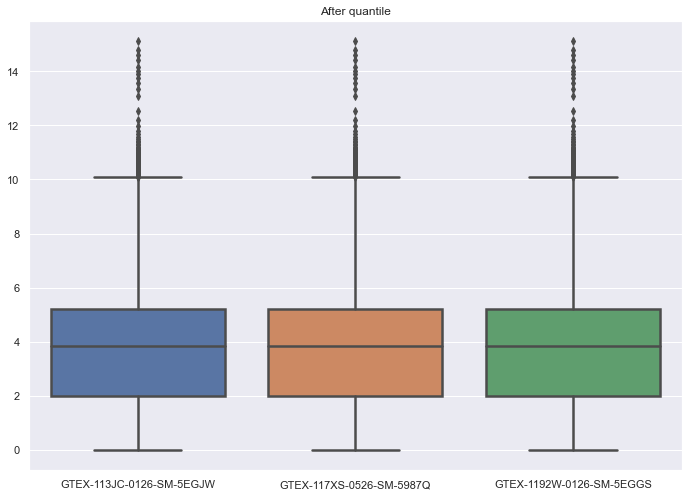

GTEX-113JC-0126-SM-5EGJW  GTEX-117XS-0526-SM-5987Q  \
Name                                                                     
ENSG00000187634.11                  2.500809                  2.798579   
ENSG00000188976.10                  6.020803                  6.152802   

                    GTEX-1192W-0126-SM-5EGGS  
Name                                          
ENSG00000187634.11                  2.151900  
ENSG00000188976.10                  6.349478

(194, 8)
sample outliers
(18349, 188)


GTEX-111FC-0426-SM-5N9CV  GTEX-1128S-2526-SM-5H11N  \
Name                                                                     
ENSG00000186092.4                   0.087667                  0.088779   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.000000                  0.000000   
ENSG00000187634.11                  4.214125                  4.237258   
ENSG00000188976.10                  5.920770                  6.067811   

                    GTEX-11DXW-0526-SM-5H127  GTEX-11EMC-3026-SM-5EQ4R  \
Name                                                                     
ENSG00000186092.4                   0.151209                  0.089932   
ENSG00000278566.1                   0.000000                  0.249263   
ENSG00000273547.1                   0.000000                  0.087979   
ENSG00000187634.11                  3.168161                  3.313971   
ENSG00000188976.10                  5.762083                  6.052459   

                    GTEX-11EQ9-2226-SM-5987H  GTEX-11GS4-2926-SM-5A5LF  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.070747   
ENSG00000278566.1                   0.071241                  0.135233   
ENSG00000273547.1                   0.071241                  0.135233   
ENSG00000187634.11                  2.432158                  4.563768   
ENSG00000188976.10                  6.170526                  5.897966   

                    GTEX-11GSP-2926-SM-5N9C2  GTEX-11NUK-0526-SM-5A5L5  \
Name                                                                     
ENSG00000186092.4                   0.077735                  0.089485   
ENSG00000278566.1                   0.000000                  0.170053   
ENSG00000273547.1                   0.000000                  0.087544   
ENSG00000187634.11                  5.431289                  4.010780   
ENSG00000188976.10                  5.887038                  5.827311   

                    GTEX-11NV4-0526-SM-5N9BF  GTEX-11O72-0426-SM-5BC5B  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.000000                  0.227618  ...   
ENSG00000278566.1                   0.071584                  0.078186  ...   
ENSG00000273547.1                   0.000000                  0.222928  ...   
ENSG00000187634.11                  3.977280                  3.503349  ...   
ENSG00000188976.10                  6.194560                  5.999324  ...   

                    GTEX-YFC4-0926-SM-5S2U7  GTEX-YJ8O-2726-SM-5IFJ7  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.000000   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.081203                 0.000000   
ENSG00000187634.11                 3.725741                 3.751678   
ENSG00000188976.10                 5.419202                 5.962318   

                    GTEX-Z93S-0926-SM-5HL8B  GTEX-ZAK1-0426-SM-5J1MS  \
Name                                                                   
ENSG00000186092.4                  0.084091                 0.000000   
ENSG00000278566.1                  0.082253                 0.065476   
ENSG00000273547.1                  0.160017                 0.065476   
ENSG00000187634.11                 4.151372                 3.997292   
ENSG00000188976.10                 5.640968                 5.826548   

                    GTEX-ZDTS-0426-SM-4WAYH  GTEX-ZUA1-0626-SM-4YCCW  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.000000   
ENSG00000278566.1                  0.000000                 0.172231   
ENSG00000273547.1                  0.111993                 0.059701   
ENSG00000187634.11  

SMRIN  SMTSISCH            SMTSD    SMGEBTCH  \
SAMPID                                                                   
GTEX-111FC-0426-SM-5N9CV    7.8    1046.0  Artery - Tibial  LCSET-4904   
GTEX-1128S-2526-SM-5H11N    6.1     889.0  Artery - Tibial  LCSET-4805   
GTEX-11DXW-0526-SM-5H127    7.8    1096.0  Artery - Tibial  LCSET-4805   
GTEX-11EMC-3026-SM-5EQ4R    5.7     810.0  Artery - Tibial  LCSET-4767   
GTEX-11EQ9-2226-SM-5987H    8.1     319.0  Artery - Tibial  LCSET-4417   

                              SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                     
GTEX-111FC-0426-SM-5N9CV  GTEX-111FC  1.0  60-69      1.0  
GTEX-1128S-2526-SM-5H11N  GTEX-1128S  2.0  60-69      2.0  
GTEX-11DXW-0526-SM-5H127  GTEX-11DXW  1.0  40-49      2.0  
GTEX-11EMC-3026-SM-5EQ4R  GTEX-11EMC  2.0  60-69      2.0  
GTEX-11EQ9-2226-SM-5987H  GTEX-11EQ9  1.0  30-39      2.0

isna
GTEX-111FC-0426-SM-5N9CV    0
GTEX-1128S-2526-SM-5H11N    0
GTEX-11DXW-0526-SM-5H127    0
GTEX-11EMC-3026-SM-5EQ4R    0
GTEX-11EQ9-2226-SM-5987H    0
                           ..
GTEX-ZUA1-0626-SM-4YCCW     0
GTEX-ZVT3-0426-SM-5GIDW     0
GTEX-ZVTK-0726-SM-5GZX6     0
GTEX-ZYFC-0726-SM-5E448     0
GTEX-ZYT6-1526-SM-5E45F     0
Length: 188, dtype: int64
GTEX-111FC-0426-SM-5N9CV    0
GTEX-1128S-2526-SM-5H11N    0
GTEX-11DXW-0526-SM-5H127    0
GTEX-11EMC-3026-SM-5EQ4R    0
GTEX-11EQ9-2226-SM-5987H    0
                           ..
GTEX-ZUA1-0626-SM-4YCCW     0
GTEX-ZVT3-0426-SM-5GIDW     0
GTEX-ZVTK-0726-SM-5GZX6     0
GTEX-ZYFC-0726-SM-5E448     0
GTEX-ZYT6-1526-SM-5E45F     0
Length: 188, dtype: int64
wasna
removing outliers
(18349, 188)
<class 'numpy.ndarray'>
components shape
(188, 20)
['GTEX-111FC-0426-SM-5N9CV', 'GTEX-1128S-2526-SM-5H11N', 'GTEX-11DXW-0526-SM-5H127', 'GTEX-11EMC-3026-SM-5EQ4R', 'GTEX-11EQ9-2226-SM-5987H', 'GTEX-11GS4-2926-SM-5A5LF', 'GTEX-11GSP-2926-SM-5N9C2'

GTEX-111FC-0426-SM-5N9CV  GTEX-1128S-2526-SM-5H11N  \
Name                                                                     
ENSG00000186092.4                   0.087667                  0.088779   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.000000                  0.000000   
ENSG00000187634.11                  4.214125                  4.237258   
ENSG00000188976.10                  5.920770                  6.067811   

                    GTEX-11DXW-0526-SM-5H127  GTEX-11EMC-3026-SM-5EQ4R  \
Name                                                                     
ENSG00000186092.4                   0.151209                  0.089932   
ENSG00000278566.1                   0.000000                  0.249263   
ENSG00000273547.1                   0.000000                  0.087979   
ENSG00000187634.11                  3.168161                  3.313971   
ENSG00000188976.10                  5.762083                  6.052459   

                    GTEX-11EQ9-2226-SM-5987H  GTEX-11GS4-2926-SM-5A5LF  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.070747   
ENSG00000278566.1                   0.071241                  0.135233   
ENSG00000273547.1                   0.071241                  0.135233   
ENSG00000187634.11                  2.432158                  4.563768   
ENSG00000188976.10                  6.170526                  5.897966   

                    GTEX-11GSP-2926-SM-5N9C2  GTEX-11NUK-0526-SM-5A5L5  \
Name                                                                     
ENSG00000186092.4                   0.077735                  0.089485   
ENSG00000278566.1                   0.000000                  0.170053   
ENSG00000273547.1                   0.000000                  0.087544   
ENSG00000187634.11                  5.431289                  4.010780   
ENSG00000188976.10                  5.887038                  5.827311   

                    GTEX-11NV4-0526-SM-5N9BF  GTEX-11O72-0426-SM-5BC5B  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.000000                  0.227618  ...   
ENSG00000278566.1                   0.071584                  0.078186  ...   
ENSG00000273547.1                   0.000000                  0.222928  ...   
ENSG00000187634.11                  3.977280                  3.503349  ...   
ENSG00000188976.10                  6.194560                  5.999324  ...   

                    GTEX-YFC4-0926-SM-5S2U7  GTEX-YJ8O-2726-SM-5IFJ7  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.000000   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.081203                 0.000000   
ENSG00000187634.11                 3.725741                 3.751678   
ENSG00000188976.10                 5.419202                 5.962318   

                    GTEX-Z93S-0926-SM-5HL8B  GTEX-ZAK1-0426-SM-5J1MS  \
Name                                                                   
ENSG00000186092.4                  0.084091                 0.000000   
ENSG00000278566.1                  0.082253                 0.065476   
ENSG00000273547.1                  0.160017                 0.065476   
ENSG00000187634.11                 4.151372                 3.997292   
ENSG00000188976.10                 5.640968                 5.826548   

                    GTEX-ZDTS-0426-SM-4WAYH  GTEX-ZUA1-0626-SM-4YCCW  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.000000   
ENSG00000278566.1                  0.000000                 0.172231   
ENSG00000273547.1                  0.111993                 0.059701   
ENSG00000187634.11  

(18349, 188)


SMRIN  SMTSISCH            SMTSD    SMGEBTCH  \
SAMPID                                                                   
GTEX-111FC-0426-SM-5N9CV    7.8    1046.0  Artery - Tibial  LCSET-4904   
GTEX-1128S-2526-SM-5H11N    6.1     889.0  Artery - Tibial  LCSET-4805   
GTEX-11DXW-0526-SM-5H127    7.8    1096.0  Artery - Tibial  LCSET-4805   
GTEX-11EMC-3026-SM-5EQ4R    5.7     810.0  Artery - Tibial  LCSET-4767   
GTEX-11EQ9-2226-SM-5987H    8.1     319.0  Artery - Tibial  LCSET-4417   

                              SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                     
GTEX-111FC-0426-SM-5N9CV  GTEX-111FC  1.0  60-69      1.0  
GTEX-1128S-2526-SM-5H11N  GTEX-1128S  2.0  60-69      2.0  
GTEX-11DXW-0526-SM-5H127  GTEX-11DXW  1.0  40-49      2.0  
GTEX-11EMC-3026-SM-5EQ4R  GTEX-11EMC  2.0  60-69      2.0  
GTEX-11EQ9-2226-SM-5987H  GTEX-11EQ9  1.0  30-39      2.0

(188, 8)
--- Index of Outliers ----
[7]
<class 'list'>
1
7
['GTEX-111FC-0426-SM-5N9CV']


0         1         2         3         4         5         6   \
0  0.074584 -0.010131  0.012101 -0.077212 -0.052139  0.032814 -0.019264   
1  0.072648  0.073040  0.099630 -0.023193  0.057951  0.041797  0.080619   
2  0.073497 -0.078571 -0.034974 -0.034918  0.010867  0.045460 -0.077557   
3  0.071754  0.013633 -0.014128  0.125960 -0.018165  0.022439  0.185299   
4  0.071487 -0.058534  0.086884  0.069487  0.136863  0.112624 -0.019971   

         7         8         9         10        11        12        13  \
0  0.034517 -0.089740 -0.104546  0.025696 -0.001979 -0.078905  0.013782   
1 -0.114436  0.017283 -0.028985  0.113055 -0.028932 -0.055464 -0.016042   
2 -0.058195 -0.067962 -0.015093 -0.101898  0.013872  0.058215  0.026947   
3 -0.072211  0.067495 -0.024516  0.014385 -0.042705  0.015235  0.004137   
4 -0.009023  0.047196  0.005717  0.101084  0.147694 -0.216939  0.055697   

         14        15        16        17        18        19  
0  0.078899  0.044268 -0.079205  0.028946  0.052636  0.000828  
1  0.118667 -0.032807 -0.167391  0.064087 -0.076287  0.019090  
2  0.012259  0.109798 -0.077523  0.004898 -0.007517  0.045537  
3  0.159218 -0.093130 -0.084561 -0.032426  0.049476 -0.050525  
4 -0.097176 -0.159106  0.087481 -0.087117 -0.063490 -0.033786

dropping outliers
matrix shape before drop
(18349, 188)
matrix shape after drop
(18349, 187)
sample shape before drop
(188, 8)
sample shape after drop
(187, 8)
Name
ENSG00000186092.4     0.009792
ENSG00000278566.1     0.010279
ENSG00000273547.1     0.004891
ENSG00000187634.11    1.088372
ENSG00000188976.10    0.045350
                        ...   
ENSG00000212907.2     0.699929
ENSG00000198886.2     0.523513
ENSG00000198786.2     0.787821
ENSG00000198695.2     1.085334
ENSG00000198727.2     0.237508
Length: 18349, dtype: float64
length of excluded list
3091
df image before quantile normalization: (15258, 3)


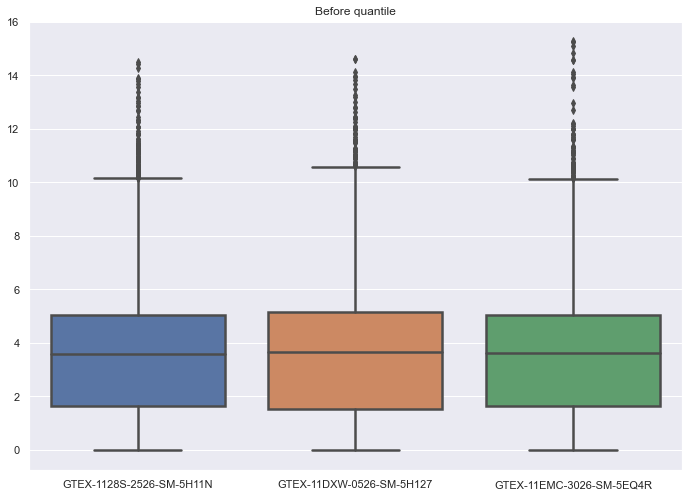

(15258, 187)


GTEX-1128S-2526-SM-5H11N  GTEX-11DXW-0526-SM-5H127  \
Name                                                                     
ENSG00000187634.11                  4.237258                  3.168161   
ENSG00000188976.10                  6.067811                  5.762083   

                    GTEX-11EMC-3026-SM-5EQ4R  
Name                                          
ENSG00000187634.11                  3.313971  
ENSG00000188976.10                  6.052459

df image after quantile normalization: (15258, 3)


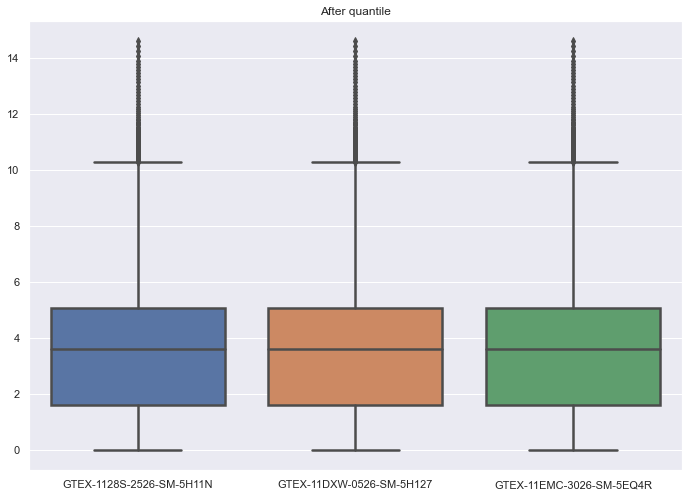

GTEX-1128S-2526-SM-5H11N  GTEX-11DXW-0526-SM-5H127  \
Name                                                                     
ENSG00000187634.11                  4.285969                  3.152580   
ENSG00000188976.10                  6.064809                  5.694524   

                    GTEX-11EMC-3026-SM-5EQ4R  
Name                                          
ENSG00000187634.11                  3.324797  
ENSG00000188976.10                  6.204725

(187, 8)
sample outliers
(18349, 185)


GTEX-111FC-0526-SM-5GZZ8  GTEX-11DXW-0426-SM-5H12E  \
Name                                                                     
ENSG00000186092.4                   0.088942                  0.088820   
ENSG00000278566.1                   0.000000                  0.086892   
ENSG00000273547.1                   0.000000                  0.000000   
ENSG00000187634.11                  2.863542                  3.146329   
ENSG00000188976.10                  6.125568                  5.883376   

                    GTEX-11DYG-0426-SM-5987J  GTEX-11EQ9-2326-SM-5HL5H  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.000000                  0.163756   
ENSG00000273547.1                   0.107688                  0.000000   
ENSG00000187634.11                  2.002883                  2.784295   
ENSG00000188976.10                  5.971314                  6.104966   

                    GTEX-11GS4-2826-SM-5HL56  GTEX-11GSO-2626-SM-5Q5AK  \
Name                                                                     
ENSG00000186092.4                   0.080480                  0.000000   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.000000                  0.000000   
ENSG00000187634.11                  2.237258                  2.251871   
ENSG00000188976.10                  5.571980                  6.195348   

                    GTEX-11GSP-2826-SM-5A5LK  GTEX-11H98-0426-SM-5HL55  \
Name                                                                     
ENSG00000186092.4                   0.100305                  0.000000   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.190046                  0.089837   
ENSG00000187634.11                  2.981487                  2.517780   
ENSG00000188976.10                  6.068026                  6.114367   

                    GTEX-11NUK-0426-SM-5HL5V  GTEX-11O72-0526-SM-5Q5AO  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.076833                  0.217603  ...   
ENSG00000278566.1                   0.000000                  0.000000  ...   
ENSG00000273547.1                   0.075163                  0.000000  ...   
ENSG00000187634.11                  3.022900                  3.026977  ...   
ENSG00000188976.10                  5.732812                  6.266412  ...   

                    GTEX-YFC4-0826-SM-5CVM1  GTEX-YJ8O-2626-SM-5HL8H  \
Name                                                                   
ENSG00000186092.4                  0.186627                 0.182946   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.094223                 0.179001   
ENSG00000187634.11                 3.144210                 3.788686   
ENSG00000188976.10                 5.845239                 6.180108   

                    GTEX-Z93S-0826-SM-5HL7Y  GTEX-ZDTS-0326-SM-5HL83  \
Name                                                                   
ENSG00000186092.4                  0.141040                 0.000000   
ENSG00000278566.1                  0.138028                 0.000000   
ENSG00000273547.1                  0.070637                 0.088834   
ENSG00000187634.11                 3.359381                 4.424250   
ENSG00000188976.10                 5.806840                 5.911452   

                    GTEX-ZDXO-1926-SM-5E45Q  GTEX-ZV68-0326-SM-59HJG  \
Name                                                                   
ENSG00000186092.4                  0.129112                 0.000000   
ENSG00000278566.1                  0.064552                 0.091950   
ENSG00000273547.1                  0.126339                 0.000000   
ENSG00000187634.11  

SMRIN  SMTSISCH           SMTSD    SMGEBTCH  \
SAMPID                                                                  
GTEX-111FC-0526-SM-5GZZ8    7.2    1050.0  Nerve - Tibial  LCSET-4804   
GTEX-11DXW-0426-SM-5H12E    7.2    1094.0  Nerve - Tibial  LCSET-4805   
GTEX-11DYG-0426-SM-5987J    7.5     814.0  Nerve - Tibial  LCSET-4417   
GTEX-11EQ9-2326-SM-5HL5H    7.2     320.0  Nerve - Tibial  LCSET-4806   
GTEX-11GS4-2826-SM-5HL56    7.3     917.0  Nerve - Tibial  LCSET-4806   

                              SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                     
GTEX-111FC-0526-SM-5GZZ8  GTEX-111FC  1.0  60-69      1.0  
GTEX-11DXW-0426-SM-5H12E  GTEX-11DXW  1.0  40-49      2.0  
GTEX-11DYG-0426-SM-5987J  GTEX-11DYG  1.0  60-69      2.0  
GTEX-11EQ9-2326-SM-5HL5H  GTEX-11EQ9  1.0  30-39      2.0  
GTEX-11GS4-2826-SM-5HL56  GTEX-11GS4  1.0  60-69      2.0

isna
GTEX-111FC-0526-SM-5GZZ8    0
GTEX-11DXW-0426-SM-5H12E    0
GTEX-11DYG-0426-SM-5987J    0
GTEX-11EQ9-2326-SM-5HL5H    0
GTEX-11GS4-2826-SM-5HL56    0
                           ..
GTEX-ZV68-0326-SM-59HJG     0
GTEX-ZVT3-0326-SM-5GU6U     0
GTEX-ZVTK-0826-SM-5GZXI     0
GTEX-ZYFC-0626-SM-5GIDR     0
GTEX-ZYT6-1426-SM-5E43U     0
Length: 185, dtype: int64
GTEX-111FC-0526-SM-5GZZ8    0
GTEX-11DXW-0426-SM-5H12E    0
GTEX-11DYG-0426-SM-5987J    0
GTEX-11EQ9-2326-SM-5HL5H    0
GTEX-11GS4-2826-SM-5HL56    0
                           ..
GTEX-ZV68-0326-SM-59HJG     0
GTEX-ZVT3-0326-SM-5GU6U     0
GTEX-ZVTK-0826-SM-5GZXI     0
GTEX-ZYFC-0626-SM-5GIDR     0
GTEX-ZYT6-1426-SM-5E43U     0
Length: 185, dtype: int64
wasna
removing outliers
(18349, 185)
<class 'numpy.ndarray'>
components shape
(185, 20)
['GTEX-111FC-0526-SM-5GZZ8', 'GTEX-11DXW-0426-SM-5H12E', 'GTEX-11DYG-0426-SM-5987J', 'GTEX-11EQ9-2326-SM-5HL5H', 'GTEX-11GS4-2826-SM-5HL56', 'GTEX-11GSO-2626-SM-5Q5AK', 'GTEX-11GSP-2826-SM-5A5LK'

GTEX-111FC-0526-SM-5GZZ8  GTEX-11DXW-0426-SM-5H12E  \
Name                                                                     
ENSG00000186092.4                   0.088942                  0.088820   
ENSG00000278566.1                   0.000000                  0.086892   
ENSG00000273547.1                   0.000000                  0.000000   
ENSG00000187634.11                  2.863542                  3.146329   
ENSG00000188976.10                  6.125568                  5.883376   

                    GTEX-11DYG-0426-SM-5987J  GTEX-11EQ9-2326-SM-5HL5H  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.000000                  0.163756   
ENSG00000273547.1                   0.107688                  0.000000   
ENSG00000187634.11                  2.002883                  2.784295   
ENSG00000188976.10                  5.971314                  6.104966   

                    GTEX-11GS4-2826-SM-5HL56  GTEX-11GSO-2626-SM-5Q5AK  \
Name                                                                     
ENSG00000186092.4                   0.080480                  0.000000   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.000000                  0.000000   
ENSG00000187634.11                  2.237258                  2.251871   
ENSG00000188976.10                  5.571980                  6.195348   

                    GTEX-11GSP-2826-SM-5A5LK  GTEX-11H98-0426-SM-5HL55  \
Name                                                                     
ENSG00000186092.4                   0.100305                  0.000000   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.190046                  0.089837   
ENSG00000187634.11                  2.981487                  2.517780   
ENSG00000188976.10                  6.068026                  6.114367   

                    GTEX-11NUK-0426-SM-5HL5V  GTEX-11O72-0526-SM-5Q5AO  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.076833                  0.217603  ...   
ENSG00000278566.1                   0.000000                  0.000000  ...   
ENSG00000273547.1                   0.075163                  0.000000  ...   
ENSG00000187634.11                  3.022900                  3.026977  ...   
ENSG00000188976.10                  5.732812                  6.266412  ...   

                    GTEX-YFC4-0826-SM-5CVM1  GTEX-YJ8O-2626-SM-5HL8H  \
Name                                                                   
ENSG00000186092.4                  0.186627                 0.182946   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.094223                 0.179001   
ENSG00000187634.11                 3.144210                 3.788686   
ENSG00000188976.10                 5.845239                 6.180108   

                    GTEX-Z93S-0826-SM-5HL7Y  GTEX-ZDTS-0326-SM-5HL83  \
Name                                                                   
ENSG00000186092.4                  0.141040                 0.000000   
ENSG00000278566.1                  0.138028                 0.000000   
ENSG00000273547.1                  0.070637                 0.088834   
ENSG00000187634.11                 3.359381                 4.424250   
ENSG00000188976.10                 5.806840                 5.911452   

                    GTEX-ZDXO-1926-SM-5E45Q  GTEX-ZV68-0326-SM-59HJG  \
Name                                                                   
ENSG00000186092.4                  0.129112                 0.000000   
ENSG00000278566.1                  0.064552                 0.091950   
ENSG00000273547.1                  0.126339                 0.000000   
ENSG00000187634.11  

(18349, 185)


SMRIN  SMTSISCH           SMTSD    SMGEBTCH  \
SAMPID                                                                  
GTEX-111FC-0526-SM-5GZZ8    7.2    1050.0  Nerve - Tibial  LCSET-4804   
GTEX-11DXW-0426-SM-5H12E    7.2    1094.0  Nerve - Tibial  LCSET-4805   
GTEX-11DYG-0426-SM-5987J    7.5     814.0  Nerve - Tibial  LCSET-4417   
GTEX-11EQ9-2326-SM-5HL5H    7.2     320.0  Nerve - Tibial  LCSET-4806   
GTEX-11GS4-2826-SM-5HL56    7.3     917.0  Nerve - Tibial  LCSET-4806   

                              SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                     
GTEX-111FC-0526-SM-5GZZ8  GTEX-111FC  1.0  60-69      1.0  
GTEX-11DXW-0426-SM-5H12E  GTEX-11DXW  1.0  40-49      2.0  
GTEX-11DYG-0426-SM-5987J  GTEX-11DYG  1.0  60-69      2.0  
GTEX-11EQ9-2326-SM-5HL5H  GTEX-11EQ9  1.0  30-39      2.0  
GTEX-11GS4-2826-SM-5HL56  GTEX-11GS4  1.0  60-69      2.0

(185, 8)
--- Index of Outliers ----
[4, 12, 58]
<class 'list'>
3
4
12
58
['GTEX-111FC-0526-SM-5GZZ8', 'GTEX-11DXW-0426-SM-5H12E', 'GTEX-11DYG-0426-SM-5987J']


0         1         2         3         4         5         6   \
0  0.074351 -0.069896 -0.074211 -0.027023 -0.024957  0.038845  0.000124   
1  0.073874 -0.057679  0.055522  0.015012  0.054871 -0.027009  0.015106   
2  0.073733 -0.018941 -0.020589  0.034520  0.052563  0.116000  0.044935   
3  0.071890  0.104425 -0.044738  0.070951 -0.082050  0.154731 -0.029258   
4  0.066742 -0.005777  0.050731  0.018442 -0.096668  0.068106 -0.101342   

         7         8         9         10        11        12        13  \
0  0.071337  0.032128 -0.037217  0.050127 -0.003696 -0.109007  0.177081   
1 -0.061263  0.115929  0.056834 -0.030427  0.014390  0.043047  0.000096   
2  0.155383  0.052286  0.017233 -0.032678 -0.105813  0.125071 -0.056452   
3  0.015505 -0.064369  0.019863  0.176885  0.100691 -0.104044  0.037193   
4 -0.002237 -0.057028  0.581810 -0.255669  0.290459  0.027202  0.149425   

         14        15        16        17        18        19  
0  0.003567  0.052489  0.051591 -0.090948 -0.053894 -0.042333  
1  0.088938 -0.003620 -0.042090 -0.062613 -0.126265  0.008880  
2 -0.094595  0.055671  0.128396  0.151202 -0.062385  0.068964  
3  0.042651 -0.006989 -0.045512  0.001331 -0.096024  0.054913  
4  0.093160  0.118658 -0.048423  0.154246  0.106656 -0.221678

dropping outliers
matrix shape before drop
(18349, 185)
matrix shape after drop
(18349, 182)
sample shape before drop
(185, 8)
sample shape after drop
(182, 8)
Name
ENSG00000186092.4     0.008499
ENSG00000278566.1     0.007502
ENSG00000273547.1     0.003182
ENSG00000187634.11    0.480611
ENSG00000188976.10    0.050999
                        ...   
ENSG00000212907.2     0.247644
ENSG00000198886.2     0.210435
ENSG00000198786.2     0.291751
ENSG00000198695.2     0.558862
ENSG00000198727.2     0.160309
Length: 18349, dtype: float64
length of excluded list
2297
df image before quantile normalization: (16052, 3)


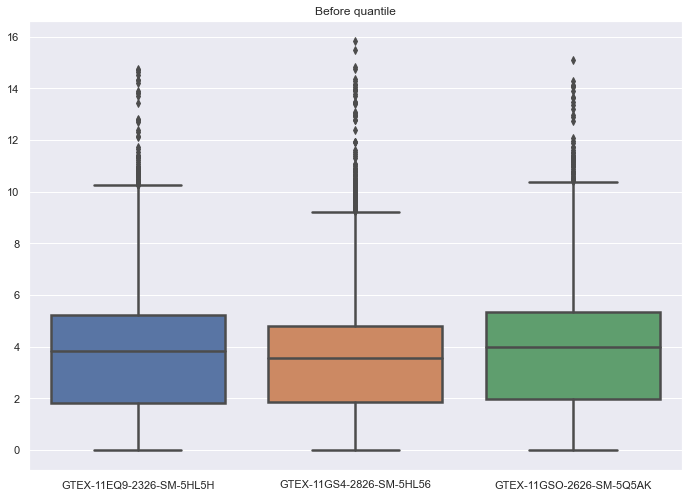

(16052, 182)


GTEX-11EQ9-2326-SM-5HL5H  GTEX-11GS4-2826-SM-5HL56  \
Name                                                                     
ENSG00000187634.11                  2.784295                  2.237258   
ENSG00000188976.10                  6.104966                  5.571980   

                    GTEX-11GSO-2626-SM-5Q5AK  
Name                                          
ENSG00000187634.11                  2.251871  
ENSG00000188976.10                  6.195348

df image after quantile normalization: (16052, 3)


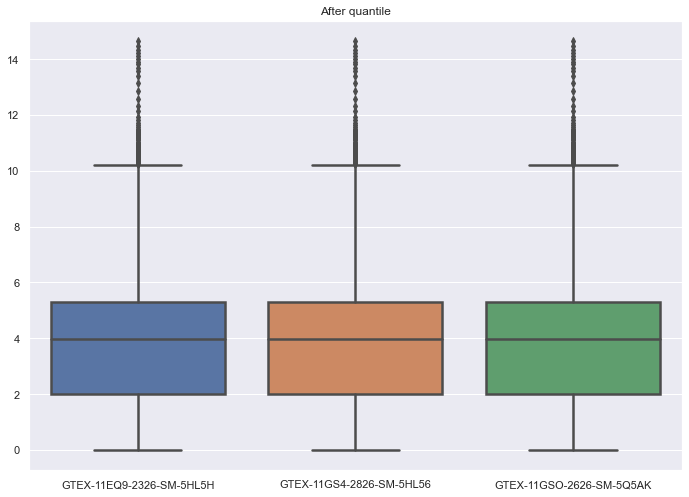

GTEX-11EQ9-2326-SM-5HL5H  GTEX-11GS4-2826-SM-5HL56  \
Name                                                                     
ENSG00000187634.11                  2.973225                  2.472845   
ENSG00000188976.10                  6.173385                  6.087621   

                    GTEX-11GSO-2626-SM-5Q5AK  
Name                                          
ENSG00000187634.11                  2.249652  
ENSG00000188976.10                  6.165592

(182, 8)
sample outliers
(18349, 183)


GTEX-111FC-2526-SM-5GZXU  GTEX-11DXW-0826-SM-5H118  \
Name                                                                     
ENSG00000186092.4                   0.142348                  0.244278   
ENSG00000278566.1                   0.139339                  0.000000   
ENSG00000273547.1                   0.139339                  0.000000   
ENSG00000187634.11                  1.774840                  1.723340   
ENSG00000188976.10                  6.016585                  6.374866   

                    GTEX-11DXY-0126-SM-5H11Q  GTEX-11DYG-1526-SM-5A5JS  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.000000                  0.113434   
ENSG00000273547.1                   0.000000                  0.057831   
ENSG00000187634.11                  0.628167                  0.485118   
ENSG00000188976.10                  6.196332                  6.178715   

                    GTEX-11EQ9-1626-SM-5PNY8  GTEX-11GS4-0226-SM-5HL77  \
Name                                                                     
ENSG00000186092.4                   0.052026                  0.000000   
ENSG00000278566.1                   0.050885                  0.000000   
ENSG00000273547.1                   0.100036                  0.000000   
ENSG00000187634.11                  1.241230                  0.478195   
ENSG00000188976.10                  6.307246                  6.491051   

                    GTEX-11GSP-2326-SM-5HL63  GTEX-11NUK-2726-SM-5A5MC  \
Name                                                                     
ENSG00000186092.4                   0.094777                  0.067322   
ENSG00000278566.1                   0.000000                  0.128821   
ENSG00000273547.1                   0.092722                  0.000000   
ENSG00000187634.11                  1.370722                  0.685716   
ENSG00000188976.10                  6.527790                  6.171927   

                    GTEX-11O72-0626-SM-5PNYE  GTEX-11OF3-0126-SM-5PNYF  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.000000                  0.046980  ...   
ENSG00000278566.1                   0.000000                  0.090474  ...   
ENSG00000273547.1                   0.000000                  0.000000  ...   
ENSG00000187634.11                  2.079634                  1.092884  ...   
ENSG00000188976.10                  6.416333                  6.423746  ...   

                    GTEX-ZAK1-0626-SM-5HL8E  GTEX-ZDTS-0826-SM-4WKHL  \
Name                                                                   
ENSG00000186092.4                  0.126537                 0.225275   
ENSG00000278566.1                  0.000000                 0.220578   
ENSG00000273547.1                  0.123825                 0.077352   
ENSG00000187634.11                 0.511772                 0.504468   
ENSG00000188976.10                 6.189627                 6.393348   

                    GTEX-ZDXO-3126-SM-5IJDF  GTEX-ZE7O-2726-SM-51MT5  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.000000   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.157044                 0.083506   
ENSG00000187634.11                 1.466758                 0.815821   
ENSG00000188976.10                 6.341986                 6.194757   

                    GTEX-ZE9C-2526-SM-5IJDR  GTEX-ZU9S-1826-SM-5NQ9E  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.084609   
ENSG00000278566.1                  0.068850                 0.041972   
ENSG00000273547.1                  0.068850                 0.122434   
ENSG00000187634.11  

SMRIN  SMTSISCH  \
SAMPID                                      
GTEX-111FC-2526-SM-5GZXU    7.0    1135.0   
GTEX-11DXW-0826-SM-5H118    7.3    1107.0   
GTEX-11DXY-0126-SM-5H11Q    7.4     880.0   
GTEX-11DYG-1526-SM-5A5JS    6.9     863.0   
GTEX-11EQ9-1626-SM-5PNY8    7.9     126.0   

                                                        SMTSD    SMGEBTCH  \
SAMPID                                                                      
GTEX-111FC-2526-SM-5GZXU  Skin - Not Sun Exposed (Suprapubic)  LCSET-4804   
GTEX-11DXW-0826-SM-5H118  Skin - Not Sun Exposed (Suprapubic)  LCSET-4805   
GTEX-11DXY-0126-SM-5H11Q  Skin - Not Sun Exposed (Suprapubic)  LCSET-4805   
GTEX-11DYG-1526-SM-5A5JS  Skin - Not Sun Exposed (Suprapubic)  LCSET-4423   
GTEX-11EQ9-1626-SM-5PNY8  Skin - Not Sun Exposed (Suprapubic)  LCSET-4918   

                              SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                     
GTEX-111FC-2526-SM-5GZXU  GTEX-111FC  1.0  60-69      1.0  
GTEX-11DXW-0826-SM-5H118  GTEX-11DXW  1.0  40-49      2.0  
GTEX-11DXY-0126-SM-5H11Q  GTEX-11DXY  1.0  60-69      2.0  
GTEX-11DYG-1526-SM-5A5JS  GTEX-11DYG  1.0  60-69      2.0  
GTEX-11EQ9-1626-SM-5PNY8  GTEX-11EQ9  1.0  30-39      2.0

isna
GTEX-111FC-2526-SM-5GZXU    0
GTEX-11DXW-0826-SM-5H118    0
GTEX-11DXY-0126-SM-5H11Q    0
GTEX-11DYG-1526-SM-5A5JS    0
GTEX-11EQ9-1626-SM-5PNY8    0
                           ..
GTEX-ZU9S-1826-SM-5NQ9E     0
GTEX-ZUA1-2626-SM-5NQ92     0
GTEX-ZVTK-0226-SM-51MRG     0
GTEX-ZYFC-0426-SM-5GICQ     0
GTEX-ZYT6-2326-SM-5GZY3     0
Length: 183, dtype: int64
GTEX-111FC-2526-SM-5GZXU    0
GTEX-11DXW-0826-SM-5H118    0
GTEX-11DXY-0126-SM-5H11Q    0
GTEX-11DYG-1526-SM-5A5JS    0
GTEX-11EQ9-1626-SM-5PNY8    0
                           ..
GTEX-ZU9S-1826-SM-5NQ9E     0
GTEX-ZUA1-2626-SM-5NQ92     0
GTEX-ZVTK-0226-SM-51MRG     0
GTEX-ZYFC-0426-SM-5GICQ     0
GTEX-ZYT6-2326-SM-5GZY3     0
Length: 183, dtype: int64
wasna
removing outliers
(18349, 183)
<class 'numpy.ndarray'>
components shape
(183, 20)
['GTEX-111FC-2526-SM-5GZXU', 'GTEX-11DXW-0826-SM-5H118', 'GTEX-11DXY-0126-SM-5H11Q', 'GTEX-11DYG-1526-SM-5A5JS', 'GTEX-11EQ9-1626-SM-5PNY8', 'GTEX-11GS4-0226-SM-5HL77', 'GTEX-11GSP-2326-SM-5HL63'

GTEX-111FC-2526-SM-5GZXU  GTEX-11DXW-0826-SM-5H118  \
Name                                                                     
ENSG00000186092.4                   0.142348                  0.244278   
ENSG00000278566.1                   0.139339                  0.000000   
ENSG00000273547.1                   0.139339                  0.000000   
ENSG00000187634.11                  1.774840                  1.723340   
ENSG00000188976.10                  6.016585                  6.374866   

                    GTEX-11DXY-0126-SM-5H11Q  GTEX-11DYG-1526-SM-5A5JS  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.000000                  0.113434   
ENSG00000273547.1                   0.000000                  0.057831   
ENSG00000187634.11                  0.628167                  0.485118   
ENSG00000188976.10                  6.196332                  6.178715   

                    GTEX-11EQ9-1626-SM-5PNY8  GTEX-11GS4-0226-SM-5HL77  \
Name                                                                     
ENSG00000186092.4                   0.052026                  0.000000   
ENSG00000278566.1                   0.050885                  0.000000   
ENSG00000273547.1                   0.100036                  0.000000   
ENSG00000187634.11                  1.241230                  0.478195   
ENSG00000188976.10                  6.307246                  6.491051   

                    GTEX-11GSP-2326-SM-5HL63  GTEX-11NUK-2726-SM-5A5MC  \
Name                                                                     
ENSG00000186092.4                   0.094777                  0.067322   
ENSG00000278566.1                   0.000000                  0.128821   
ENSG00000273547.1                   0.092722                  0.000000   
ENSG00000187634.11                  1.370722                  0.685716   
ENSG00000188976.10                  6.527790                  6.171927   

                    GTEX-11O72-0626-SM-5PNYE  GTEX-11OF3-0126-SM-5PNYF  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.000000                  0.046980  ...   
ENSG00000278566.1                   0.000000                  0.090474  ...   
ENSG00000273547.1                   0.000000                  0.000000  ...   
ENSG00000187634.11                  2.079634                  1.092884  ...   
ENSG00000188976.10                  6.416333                  6.423746  ...   

                    GTEX-ZAK1-0626-SM-5HL8E  GTEX-ZDTS-0826-SM-4WKHL  \
Name                                                                   
ENSG00000186092.4                  0.126537                 0.225275   
ENSG00000278566.1                  0.000000                 0.220578   
ENSG00000273547.1                  0.123825                 0.077352   
ENSG00000187634.11                 0.511772                 0.504468   
ENSG00000188976.10                 6.189627                 6.393348   

                    GTEX-ZDXO-3126-SM-5IJDF  GTEX-ZE7O-2726-SM-51MT5  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.000000   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.157044                 0.083506   
ENSG00000187634.11                 1.466758                 0.815821   
ENSG00000188976.10                 6.341986                 6.194757   

                    GTEX-ZE9C-2526-SM-5IJDR  GTEX-ZU9S-1826-SM-5NQ9E  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.084609   
ENSG00000278566.1                  0.068850                 0.041972   
ENSG00000273547.1                  0.068850                 0.122434   
ENSG00000187634.11  

(18349, 183)


SMRIN  SMTSISCH  \
SAMPID                                      
GTEX-111FC-2526-SM-5GZXU    7.0    1135.0   
GTEX-11DXW-0826-SM-5H118    7.3    1107.0   
GTEX-11DXY-0126-SM-5H11Q    7.4     880.0   
GTEX-11DYG-1526-SM-5A5JS    6.9     863.0   
GTEX-11EQ9-1626-SM-5PNY8    7.9     126.0   

                                                        SMTSD    SMGEBTCH  \
SAMPID                                                                      
GTEX-111FC-2526-SM-5GZXU  Skin - Not Sun Exposed (Suprapubic)  LCSET-4804   
GTEX-11DXW-0826-SM-5H118  Skin - Not Sun Exposed (Suprapubic)  LCSET-4805   
GTEX-11DXY-0126-SM-5H11Q  Skin - Not Sun Exposed (Suprapubic)  LCSET-4805   
GTEX-11DYG-1526-SM-5A5JS  Skin - Not Sun Exposed (Suprapubic)  LCSET-4423   
GTEX-11EQ9-1626-SM-5PNY8  Skin - Not Sun Exposed (Suprapubic)  LCSET-4918   

                              SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                     
GTEX-111FC-2526-SM-5GZXU  GTEX-111FC  1.0  60-69      1.0  
GTEX-11DXW-0826-SM-5H118  GTEX-11DXW  1.0  40-49      2.0  
GTEX-11DXY-0126-SM-5H11Q  GTEX-11DXY  1.0  60-69      2.0  
GTEX-11DYG-1526-SM-5A5JS  GTEX-11DYG  1.0  60-69      2.0  
GTEX-11EQ9-1626-SM-5PNY8  GTEX-11EQ9  1.0  30-39      2.0

(183, 8)
--- Index of Outliers ----
[15, 178]
<class 'list'>
2
15
178
['GTEX-111FC-2526-SM-5GZXU', 'GTEX-11DXW-0826-SM-5H118']


0         1         2         3         4         5         6   \
0  0.072196  0.237755  0.009271 -0.020214  0.037128 -0.120984  0.060210   
1  0.075038  0.148629  0.065768  0.016063 -0.031067  0.009960 -0.007691   
2  0.071925 -0.032263 -0.018434  0.076951  0.057496 -0.004102  0.060895   
3  0.068548  0.062133  0.082672  0.096801  0.223865  0.142303 -0.074524   
4  0.074556  0.097364  0.062514  0.106251 -0.080039 -0.088799  0.004965   

         7         8         9         10        11        12        13  \
0 -0.064763  0.067808 -0.019611  0.056464 -0.052265 -0.131173  0.026708   
1 -0.057028 -0.027968  0.084821  0.044495 -0.060097  0.131615  0.032434   
2  0.061532 -0.098649  0.042164  0.090899 -0.071825  0.058655  0.022156   
3 -0.061920  0.071897 -0.123852 -0.107888  0.041925  0.097565 -0.042028   
4  0.154117 -0.013447 -0.040364 -0.134947  0.115241 -0.020089 -0.064403   

         14        15        16        17        18        19  
0  0.170692 -0.101959 -0.003033  0.014771 -0.175765 -0.052909  
1  0.062623  0.015859 -0.032011  0.095655  0.004260 -0.058508  
2  0.067682 -0.048715 -0.000090  0.051751 -0.010012 -0.011741  
3  0.009009 -0.003203  0.012090  0.007885  0.011450 -0.037802  
4  0.097024 -0.058378 -0.263768 -0.220023  0.072601 -0.117580

dropping outliers
matrix shape before drop
(18349, 183)
matrix shape after drop
(18349, 181)
sample shape before drop
(183, 8)
sample shape after drop
(181, 8)
Name
ENSG00000186092.4     0.030551
ENSG00000278566.1     0.010162
ENSG00000273547.1     0.004839
ENSG00000187634.11    0.227873
ENSG00000188976.10    0.048203
                        ...   
ENSG00000212907.2     0.194699
ENSG00000198886.2     0.112771
ENSG00000198786.2     0.342232
ENSG00000198695.2     0.631928
ENSG00000198727.2     0.135452
Length: 18349, dtype: float64
length of excluded list
2508
df image before quantile normalization: (15841, 3)


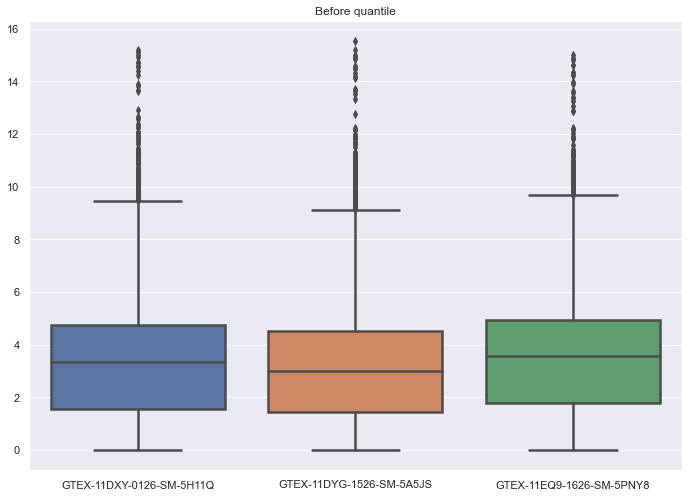

(15841, 181)


GTEX-11DXY-0126-SM-5H11Q  GTEX-11DYG-1526-SM-5A5JS  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000187634.11                  0.628167                  0.485118   

                    GTEX-11EQ9-1626-SM-5PNY8  
Name                                          
ENSG00000186092.4                   0.052026  
ENSG00000187634.11                  1.241230

df image after quantile normalization: (15841, 3)


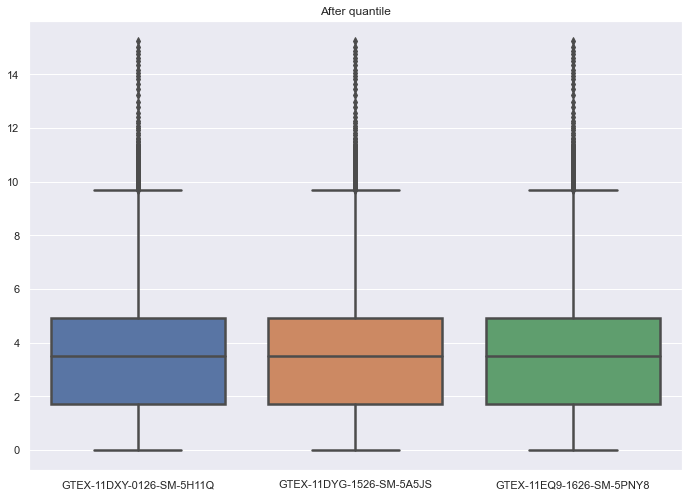

GTEX-11DXY-0126-SM-5H11Q  GTEX-11DYG-1526-SM-5A5JS  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000187634.11                  0.710106                  0.567671   

                    GTEX-11EQ9-1626-SM-5PNY8  
Name                                          
ENSG00000186092.4                   0.030951  
ENSG00000187634.11                  1.157843

(181, 8)
sample outliers
(18349, 182)


GTEX-111FC-1126-SM-5GZWU  GTEX-1128S-0726-SM-5N9D6  \
Name                                                                     
ENSG00000186092.4                   0.089607                  0.000000   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.087653                  0.080630   
ENSG00000187634.11                  2.556061                  1.642471   
ENSG00000188976.10                  5.545042                  6.045705   

                    GTEX-11EMC-0126-SM-5EGKV  GTEX-11EQ9-0226-SM-5A5JX  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.064938                  0.069702   
ENSG00000273547.1                   0.127065                  0.069702   
ENSG00000187634.11                  1.328836                  1.598842   
ENSG00000188976.10                  5.396091                  6.093391   

                    GTEX-11GSP-0726-SM-5986L  GTEX-11NUK-0826-SM-5HL4U  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.000000                  0.124950   
ENSG00000273547.1                   0.078009                  0.063834   
ENSG00000187634.11                  3.709291                  2.231432   
ENSG00000188976.10                  5.862947                  5.584361   

                    GTEX-11NV4-1126-SM-5HL6J  GTEX-11O72-1326-SM-5BC5A  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.091409   
ENSG00000278566.1                   0.080821                  0.173639   
ENSG00000273547.1                   0.000000                  0.173639   
ENSG00000187634.11                  1.229588                  2.658097   
ENSG00000188976.10                  5.357200                  5.763412   

                    GTEX-11OF3-1126-SM-5986C  GTEX-11PRG-0926-SM-5EGI8  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.000000                  0.222310  ...   
ENSG00000278566.1                   0.096653                  0.000000  ...   
ENSG00000273547.1                   0.187261                  0.076258  ...   
ENSG00000187634.11                  1.011496                  3.615887  ...   
ENSG00000188976.10                  5.181500                  5.848498  ...   

                    GTEX-Y111-1026-SM-4TT22  GTEX-YFC4-1126-SM-5RQJN  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.000000   
ENSG00000278566.1                  0.000000                 0.091680   
ENSG00000273547.1                  0.056209                 0.000000   
ENSG00000187634.11                 2.397803                 2.689299   
ENSG00000188976.10                 5.750607                 5.060912   

                    GTEX-YJ8O-1826-SM-5HL82  GTEX-ZDTS-1026-SM-4WAXS  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.082648   
ENSG00000278566.1                  0.105209                 0.000000   
ENSG00000273547.1                  0.000000                 0.000000   
ENSG00000187634.11                 3.300270                 3.895303   
ENSG00000188976.10                 6.023921                 5.369117   

                    GTEX-ZDXO-1326-SM-57WBS  GTEX-ZE7O-0826-SM-57WCP  \
Name                                                                   
ENSG00000186092.4                  0.107541                 0.077954   
ENSG00000278566.1                  0.105222                 0.076258   
ENSG00000273547.1                  0.105222                 0.148739   
ENSG00000187634.11  

SMRIN  SMTSISCH SMTSD               SMGEBTCH  \
SAMPID                                                                   
GTEX-111FC-1126-SM-5GZWU    7.2    1080.0  Lung             LCSET-4804   
GTEX-1128S-0726-SM-5N9D6    7.6     840.0  Lung             LCSET-4904   
GTEX-11EMC-0126-SM-5EGKV    7.6     670.0  Lung  LCSET-4766,LCSET-4797   
GTEX-11EQ9-0226-SM-5A5JX    8.3      74.0  Lung             LCSET-4423   
GTEX-11GSP-0726-SM-5986L    6.9     773.0  Lung             LCSET-4417   

                              SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                     
GTEX-111FC-1126-SM-5GZWU  GTEX-111FC  1.0  60-69      1.0  
GTEX-1128S-0726-SM-5N9D6  GTEX-1128S  2.0  60-69      2.0  
GTEX-11EMC-0126-SM-5EGKV  GTEX-11EMC  2.0  60-69      2.0  
GTEX-11EQ9-0226-SM-5A5JX  GTEX-11EQ9  1.0  30-39      2.0  
GTEX-11GSP-0726-SM-5986L  GTEX-11GSP  2.0  60-69      2.0

isna
GTEX-111FC-1126-SM-5GZWU    0
GTEX-1128S-0726-SM-5N9D6    0
GTEX-11EMC-0126-SM-5EGKV    0
GTEX-11EQ9-0226-SM-5A5JX    0
GTEX-11GSP-0726-SM-5986L    0
                           ..
GTEX-ZE7O-0826-SM-57WCP     0
GTEX-ZUA1-1026-SM-4YCEA     0
GTEX-ZVT3-0926-SM-5GICK     0
GTEX-ZVZQ-1526-SM-5N9G6     0
GTEX-ZYT6-0526-SM-5GIEA     0
Length: 182, dtype: int64
GTEX-111FC-1126-SM-5GZWU    0
GTEX-1128S-0726-SM-5N9D6    0
GTEX-11EMC-0126-SM-5EGKV    0
GTEX-11EQ9-0226-SM-5A5JX    0
GTEX-11GSP-0726-SM-5986L    0
                           ..
GTEX-ZE7O-0826-SM-57WCP     0
GTEX-ZUA1-1026-SM-4YCEA     0
GTEX-ZVT3-0926-SM-5GICK     0
GTEX-ZVZQ-1526-SM-5N9G6     0
GTEX-ZYT6-0526-SM-5GIEA     0
Length: 182, dtype: int64
wasna
removing outliers
(18349, 182)
<class 'numpy.ndarray'>
components shape
(182, 20)
['GTEX-111FC-1126-SM-5GZWU', 'GTEX-1128S-0726-SM-5N9D6', 'GTEX-11EMC-0126-SM-5EGKV', 'GTEX-11EQ9-0226-SM-5A5JX', 'GTEX-11GSP-0726-SM-5986L', 'GTEX-11NUK-0826-SM-5HL4U', 'GTEX-11NV4-1126-SM-5HL6J'

GTEX-111FC-1126-SM-5GZWU  GTEX-1128S-0726-SM-5N9D6  \
Name                                                                     
ENSG00000186092.4                   0.089607                  0.000000   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.087653                  0.080630   
ENSG00000187634.11                  2.556061                  1.642471   
ENSG00000188976.10                  5.545042                  6.045705   

                    GTEX-11EMC-0126-SM-5EGKV  GTEX-11EQ9-0226-SM-5A5JX  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.064938                  0.069702   
ENSG00000273547.1                   0.127065                  0.069702   
ENSG00000187634.11                  1.328836                  1.598842   
ENSG00000188976.10                  5.396091                  6.093391   

                    GTEX-11GSP-0726-SM-5986L  GTEX-11NUK-0826-SM-5HL4U  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.000000                  0.124950   
ENSG00000273547.1                   0.078009                  0.063834   
ENSG00000187634.11                  3.709291                  2.231432   
ENSG00000188976.10                  5.862947                  5.584361   

                    GTEX-11NV4-1126-SM-5HL6J  GTEX-11O72-1326-SM-5BC5A  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.091409   
ENSG00000278566.1                   0.080821                  0.173639   
ENSG00000273547.1                   0.000000                  0.173639   
ENSG00000187634.11                  1.229588                  2.658097   
ENSG00000188976.10                  5.357200                  5.763412   

                    GTEX-11OF3-1126-SM-5986C  GTEX-11PRG-0926-SM-5EGI8  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.000000                  0.222310  ...   
ENSG00000278566.1                   0.096653                  0.000000  ...   
ENSG00000273547.1                   0.187261                  0.076258  ...   
ENSG00000187634.11                  1.011496                  3.615887  ...   
ENSG00000188976.10                  5.181500                  5.848498  ...   

                    GTEX-Y111-1026-SM-4TT22  GTEX-YFC4-1126-SM-5RQJN  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.000000   
ENSG00000278566.1                  0.000000                 0.091680   
ENSG00000273547.1                  0.056209                 0.000000   
ENSG00000187634.11                 2.397803                 2.689299   
ENSG00000188976.10                 5.750607                 5.060912   

                    GTEX-YJ8O-1826-SM-5HL82  GTEX-ZDTS-1026-SM-4WAXS  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.082648   
ENSG00000278566.1                  0.105209                 0.000000   
ENSG00000273547.1                  0.000000                 0.000000   
ENSG00000187634.11                 3.300270                 3.895303   
ENSG00000188976.10                 6.023921                 5.369117   

                    GTEX-ZDXO-1326-SM-57WBS  GTEX-ZE7O-0826-SM-57WCP  \
Name                                                                   
ENSG00000186092.4                  0.107541                 0.077954   
ENSG00000278566.1                  0.105222                 0.076258   
ENSG00000273547.1                  0.105222                 0.148739   
ENSG00000187634.11  

(18349, 182)


SMRIN  SMTSISCH SMTSD               SMGEBTCH  \
SAMPID                                                                   
GTEX-111FC-1126-SM-5GZWU    7.2    1080.0  Lung             LCSET-4804   
GTEX-1128S-0726-SM-5N9D6    7.6     840.0  Lung             LCSET-4904   
GTEX-11EMC-0126-SM-5EGKV    7.6     670.0  Lung  LCSET-4766,LCSET-4797   
GTEX-11EQ9-0226-SM-5A5JX    8.3      74.0  Lung             LCSET-4423   
GTEX-11GSP-0726-SM-5986L    6.9     773.0  Lung             LCSET-4417   

                              SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                     
GTEX-111FC-1126-SM-5GZWU  GTEX-111FC  1.0  60-69      1.0  
GTEX-1128S-0726-SM-5N9D6  GTEX-1128S  2.0  60-69      2.0  
GTEX-11EMC-0126-SM-5EGKV  GTEX-11EMC  2.0  60-69      2.0  
GTEX-11EQ9-0226-SM-5A5JX  GTEX-11EQ9  1.0  30-39      2.0  
GTEX-11GSP-0726-SM-5986L  GTEX-11GSP  2.0  60-69      2.0

(182, 8)
--- Index of Outliers ----
[72, 156]
<class 'list'>
2
72
156
['GTEX-111FC-1126-SM-5GZWU', 'GTEX-1128S-0726-SM-5N9D6']


0         1         2         3         4         5         6   \
0  0.075677 -0.126455 -0.009595 -0.029428 -0.041704  0.115335  0.045155   
1  0.074865 -0.019190  0.107370 -0.013870  0.045712 -0.053896  0.126820   
2  0.070066  0.094256  0.057723  0.127604 -0.041395  0.072707 -0.030890   
3  0.074652 -0.000956  0.010833  0.224405 -0.047743  0.084969  0.119051   
4  0.072429  0.063691 -0.007844 -0.045649  0.109383  0.055673  0.013111   

         7         8         9         10        11        12        13  \
0  0.071657 -0.014338 -0.007078  0.052581 -0.076788  0.039970  0.077896   
1 -0.004536  0.100432 -0.004342  0.099697 -0.136216 -0.059170  0.074129   
2 -0.002779 -0.055906  0.145888  0.081393 -0.063398  0.019345 -0.002782   
3  0.038941 -0.109631  0.042942  0.080940 -0.008190 -0.048951 -0.151215   
4  0.088054  0.005166  0.036414 -0.131532  0.116656 -0.007247 -0.041352   

         14        15        16        17        18        19  
0  0.043358 -0.097937 -0.045448 -0.094949  0.052940  0.000311  
1 -0.037279 -0.057375 -0.094370 -0.028013 -0.194298 -0.018520  
2  0.016614  0.038719 -0.026245  0.054051 -0.134024  0.045067  
3  0.033862  0.063718  0.040201  0.093842  0.049401  0.017811  
4 -0.061164 -0.058979 -0.038874 -0.108420 -0.160090 -0.005276

dropping outliers
matrix shape before drop
(18349, 182)
matrix shape after drop
(18349, 180)
sample shape before drop
(182, 8)
sample shape after drop
(180, 8)
Name
ENSG00000186092.4     0.011265
ENSG00000278566.1     0.012441
ENSG00000273547.1     0.005354
ENSG00000187634.11    0.991929
ENSG00000188976.10    0.149125
                        ...   
ENSG00000212907.2     0.450875
ENSG00000198886.2     0.452336
ENSG00000198786.2     0.733229
ENSG00000198695.2     1.519134
ENSG00000198727.2     0.319827
Length: 18349, dtype: float64
length of excluded list
2257
df image before quantile normalization: (16092, 3)


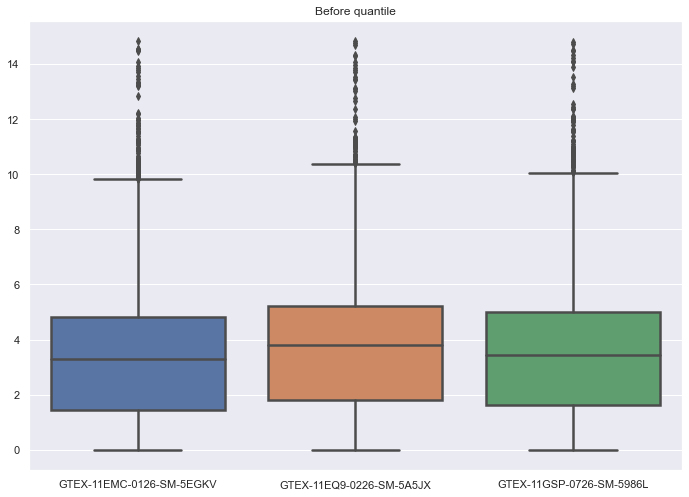

(16092, 180)


GTEX-11EMC-0126-SM-5EGKV  GTEX-11EQ9-0226-SM-5A5JX  \
Name                                                                     
ENSG00000187634.11                  1.328836                  1.598842   
ENSG00000188976.10                  5.396091                  6.093391   

                    GTEX-11GSP-0726-SM-5986L  
Name                                          
ENSG00000187634.11                  3.709291  
ENSG00000188976.10                  5.862947

df image after quantile normalization: (16092, 3)


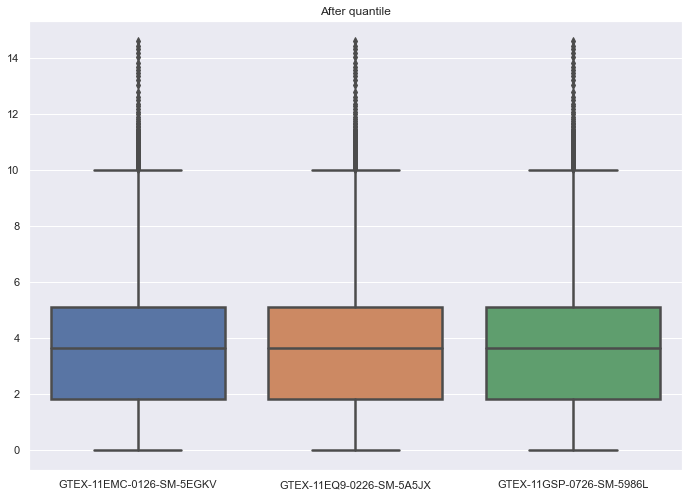

GTEX-11EMC-0126-SM-5EGKV  GTEX-11EQ9-0226-SM-5A5JX  \
Name                                                                     
ENSG00000187634.11                   1.67801                  1.646800   
ENSG00000188976.10                   5.67514                  6.043401   

                    GTEX-11GSP-0726-SM-5986L  
Name                                          
ENSG00000187634.11                  3.911747  
ENSG00000188976.10                  5.925654

(180, 8)
sample outliers
(18349, 152)


GTEX-1128S-0926-SM-5GZZU  GTEX-113JC-0726-SM-5GZZR  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.138683   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.065283                  0.000000   
ENSG00000187634.11                  3.013462                  2.524565   
ENSG00000188976.10                  6.487840                  4.915999   

                    GTEX-11DXY-0326-SM-5H12F  GTEX-11DYG-2026-SM-5EGGX  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.153546   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.000000                  0.077093   
ENSG00000187634.11                  3.412646                  3.468583   
ENSG00000188976.10                  5.772677                  5.922198   

                    GTEX-11EQ9-1126-SM-5987I  GTEX-11GS4-1026-SM-5N9DE  \
Name                                                                     
ENSG00000186092.4                   0.050676                  0.115806   
ENSG00000278566.1                   0.049561                  0.057776   
ENSG00000273547.1                   0.049561                  0.000000   
ENSG00000187634.11                  0.596840                  2.113367   
ENSG00000188976.10                  5.237258                  5.150966   

                    GTEX-11GSO-0226-SM-5A5LV  GTEX-11GSP-1026-SM-9WYSH  \
Name                                                                     
ENSG00000186092.4                   0.076381                  0.092045   
ENSG00000278566.1                   0.145743                  0.090054   
ENSG00000273547.1                   0.074725                  0.000000   
ENSG00000187634.11                  2.986775                  3.873813   
ENSG00000188976.10                  5.836682                  5.231125   

                    GTEX-11NUK-2026-SM-5PNVZ  GTEX-11NV4-1426-SM-5BC4W  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.064027                  0.101892  ...   
ENSG00000278566.1                   0.062633                  0.000000  ...   
ENSG00000273547.1                   0.180275                  0.000000  ...   
ENSG00000187634.11                  2.389567                  2.414406  ...   
ENSG00000188976.10                  5.228819                  5.724377  ...   

                    GTEX-XQ3S-2426-SM-4WAYB  GTEX-Y111-0926-SM-4SOIU  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.275484   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.000000                 0.058164   
ENSG00000187634.11                 3.669027                 2.491597   
ENSG00000188976.10                 5.562548                 5.252098   

                    GTEX-YJ89-1926-SM-5IFJ6  GTEX-ZDTS-1826-SM-5S2N6  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.071474   
ENSG00000278566.1                  0.137333                 0.069908   
ENSG00000273547.1                  0.000000                 0.069908   
ENSG00000187634.11                 3.143230                 2.767443   
ENSG00000188976.10                 6.077457                 5.513175   

                    GTEX-ZDXO-2326-SM-5LU9W  GTEX-ZE7O-1526-SM-5J1NH  \
Name                                                                   
ENSG00000186092.4                  0.200755                 0.139469   
ENSG00000278566.1                  0.068519                 0.136520   
ENSG00000273547.1                  0.133945                 0.069881   
ENSG00000187634.11  

SMRIN  SMTSISCH                         SMTSD  \
SAMPID                                                                    
GTEX-1128S-0926-SM-5GZZU    6.5     844.0  Adipose - Visceral (Omentum)   
GTEX-113JC-0726-SM-5GZZR    7.0     639.0  Adipose - Visceral (Omentum)   
GTEX-11DXY-0326-SM-5H12F    6.6     885.0  Adipose - Visceral (Omentum)   
GTEX-11DYG-2026-SM-5EGGX    7.3     873.0  Adipose - Visceral (Omentum)   
GTEX-11EQ9-1126-SM-5987I    7.8     105.0  Adipose - Visceral (Omentum)   

                            SMGEBTCH      SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                                 
GTEX-1128S-0926-SM-5GZZU  LCSET-4805  GTEX-1128S  2.0  60-69      2.0  
GTEX-113JC-0726-SM-5GZZR  LCSET-4805  GTEX-113JC  2.0  50-59      2.0  
GTEX-11DXY-0326-SM-5H12F  LCSET-4805  GTEX-11DXY  1.0  60-69      2.0  
GTEX-11DYG-2026-SM-5EGGX  LCSET-4764  GTEX-11DYG  1.0  60-69      2.0  
GTEX-11EQ9-1126-SM-5987I  LCSET-4417  GTEX-11EQ9  1.0  30-39      2.0

isna
GTEX-1128S-0926-SM-5GZZU    0
GTEX-113JC-0726-SM-5GZZR    0
GTEX-11DXY-0326-SM-5H12F    0
GTEX-11DYG-2026-SM-5EGGX    0
GTEX-11EQ9-1126-SM-5987I    0
                           ..
GTEX-ZE7O-1526-SM-5J1NH     0
GTEX-ZE9C-1326-SM-5S2OW     0
GTEX-ZUA1-2126-SM-57YRB     0
GTEX-ZYFC-1826-SM-5GZZA     0
GTEX-ZYT6-2126-SM-5GZZ4     0
Length: 152, dtype: int64
GTEX-1128S-0926-SM-5GZZU    0
GTEX-113JC-0726-SM-5GZZR    0
GTEX-11DXY-0326-SM-5H12F    0
GTEX-11DYG-2026-SM-5EGGX    0
GTEX-11EQ9-1126-SM-5987I    0
                           ..
GTEX-ZE7O-1526-SM-5J1NH     0
GTEX-ZE9C-1326-SM-5S2OW     0
GTEX-ZUA1-2126-SM-57YRB     0
GTEX-ZYFC-1826-SM-5GZZA     0
GTEX-ZYT6-2126-SM-5GZZ4     0
Length: 152, dtype: int64
wasna
removing outliers
(18349, 152)
<class 'numpy.ndarray'>
components shape
(152, 20)
['GTEX-1128S-0926-SM-5GZZU', 'GTEX-113JC-0726-SM-5GZZR', 'GTEX-11DXY-0326-SM-5H12F', 'GTEX-11DYG-2026-SM-5EGGX', 'GTEX-11EQ9-1126-SM-5987I', 'GTEX-11GS4-1026-SM-5N9DE', 'GTEX-11GSO-0226-SM-5A5LV'

GTEX-1128S-0926-SM-5GZZU  GTEX-113JC-0726-SM-5GZZR  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.138683   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.065283                  0.000000   
ENSG00000187634.11                  3.013462                  2.524565   
ENSG00000188976.10                  6.487840                  4.915999   

                    GTEX-11DXY-0326-SM-5H12F  GTEX-11DYG-2026-SM-5EGGX  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.153546   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.000000                  0.077093   
ENSG00000187634.11                  3.412646                  3.468583   
ENSG00000188976.10                  5.772677                  5.922198   

                    GTEX-11EQ9-1126-SM-5987I  GTEX-11GS4-1026-SM-5N9DE  \
Name                                                                     
ENSG00000186092.4                   0.050676                  0.115806   
ENSG00000278566.1                   0.049561                  0.057776   
ENSG00000273547.1                   0.049561                  0.000000   
ENSG00000187634.11                  0.596840                  2.113367   
ENSG00000188976.10                  5.237258                  5.150966   

                    GTEX-11GSO-0226-SM-5A5LV  GTEX-11GSP-1026-SM-9WYSH  \
Name                                                                     
ENSG00000186092.4                   0.076381                  0.092045   
ENSG00000278566.1                   0.145743                  0.090054   
ENSG00000273547.1                   0.074725                  0.000000   
ENSG00000187634.11                  2.986775                  3.873813   
ENSG00000188976.10                  5.836682                  5.231125   

                    GTEX-11NUK-2026-SM-5PNVZ  GTEX-11NV4-1426-SM-5BC4W  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.064027                  0.101892  ...   
ENSG00000278566.1                   0.062633                  0.000000  ...   
ENSG00000273547.1                   0.180275                  0.000000  ...   
ENSG00000187634.11                  2.389567                  2.414406  ...   
ENSG00000188976.10                  5.228819                  5.724377  ...   

                    GTEX-XQ3S-2426-SM-4WAYB  GTEX-Y111-0926-SM-4SOIU  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.275484   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.000000                 0.058164   
ENSG00000187634.11                 3.669027                 2.491597   
ENSG00000188976.10                 5.562548                 5.252098   

                    GTEX-YJ89-1926-SM-5IFJ6  GTEX-ZDTS-1826-SM-5S2N6  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.071474   
ENSG00000278566.1                  0.137333                 0.069908   
ENSG00000273547.1                  0.000000                 0.069908   
ENSG00000187634.11                 3.143230                 2.767443   
ENSG00000188976.10                 6.077457                 5.513175   

                    GTEX-ZDXO-2326-SM-5LU9W  GTEX-ZE7O-1526-SM-5J1NH  \
Name                                                                   
ENSG00000186092.4                  0.200755                 0.139469   
ENSG00000278566.1                  0.068519                 0.136520   
ENSG00000273547.1                  0.133945                 0.069881   
ENSG00000187634.11  

(18349, 152)


SMRIN  SMTSISCH                         SMTSD  \
SAMPID                                                                    
GTEX-1128S-0926-SM-5GZZU    6.5     844.0  Adipose - Visceral (Omentum)   
GTEX-113JC-0726-SM-5GZZR    7.0     639.0  Adipose - Visceral (Omentum)   
GTEX-11DXY-0326-SM-5H12F    6.6     885.0  Adipose - Visceral (Omentum)   
GTEX-11DYG-2026-SM-5EGGX    7.3     873.0  Adipose - Visceral (Omentum)   
GTEX-11EQ9-1126-SM-5987I    7.8     105.0  Adipose - Visceral (Omentum)   

                            SMGEBTCH      SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                                 
GTEX-1128S-0926-SM-5GZZU  LCSET-4805  GTEX-1128S  2.0  60-69      2.0  
GTEX-113JC-0726-SM-5GZZR  LCSET-4805  GTEX-113JC  2.0  50-59      2.0  
GTEX-11DXY-0326-SM-5H12F  LCSET-4805  GTEX-11DXY  1.0  60-69      2.0  
GTEX-11DYG-2026-SM-5EGGX  LCSET-4764  GTEX-11DYG  1.0  60-69      2.0  
GTEX-11EQ9-1126-SM-5987I  LCSET-4417  GTEX-11EQ9  1.0  30-39      2.0

(152, 8)
--- Index of Outliers ----
[77]
<class 'list'>
1
77
['GTEX-1128S-0926-SM-5GZZU']


0         1         2         3         4         5         6   \
0  0.082061  0.190385 -0.029888 -0.079606  0.192779  0.236767 -0.015263   
1  0.078612  0.014426 -0.071387 -0.130790 -0.194989 -0.066716 -0.001603   
2  0.085328 -0.102521 -0.077125  0.044154  0.061993  0.056367 -0.059387   
3  0.085753 -0.065688 -0.100422 -0.005083 -0.006290 -0.005407 -0.022568   
4  0.072301  0.195731  0.214972  0.135662  0.045793 -0.063303 -0.106820   

         7         8         9         10        11        12        13  \
0 -0.039884  0.138926 -0.049190 -0.025411 -0.035709  0.033305  0.029452   
1  0.058206 -0.107086 -0.023179 -0.104043 -0.160074  0.045423  0.002125   
2 -0.129333 -0.004119 -0.119158 -0.035717  0.064132  0.111343 -0.056197   
3  0.024224  0.034575  0.145997 -0.103304 -0.002565  0.032392 -0.076632   
4  0.065966 -0.091652  0.112434 -0.021772 -0.011263  0.155585 -0.025239   

         14        15        16        17        18        19  
0 -0.120417 -0.052891  0.132053  0.086084 -0.129854 -0.015976  
1 -0.141839  0.112174  0.057381  0.005747 -0.072164 -0.154706  
2 -0.013999 -0.023318 -0.008736  0.036863  0.001084  0.000004  
3  0.007211  0.124685  0.084078 -0.006247  0.051533  0.029831  
4  0.019633 -0.067946  0.311333 -0.171370 -0.123649  0.052393

dropping outliers
matrix shape before drop
(18349, 152)
matrix shape after drop
(18349, 151)
sample shape before drop
(152, 8)
sample shape after drop
(151, 8)
Name
ENSG00000186092.4     0.015768
ENSG00000278566.1     0.016558
ENSG00000273547.1     0.006711
ENSG00000187634.11    0.826062
ENSG00000188976.10    0.128058
                        ...   
ENSG00000212907.2     0.650802
ENSG00000198886.2     0.663798
ENSG00000198786.2     0.345697
ENSG00000198695.2     0.517224
ENSG00000198727.2     0.395881
Length: 18349, dtype: float64
length of excluded list
2670
df image before quantile normalization: (15679, 3)


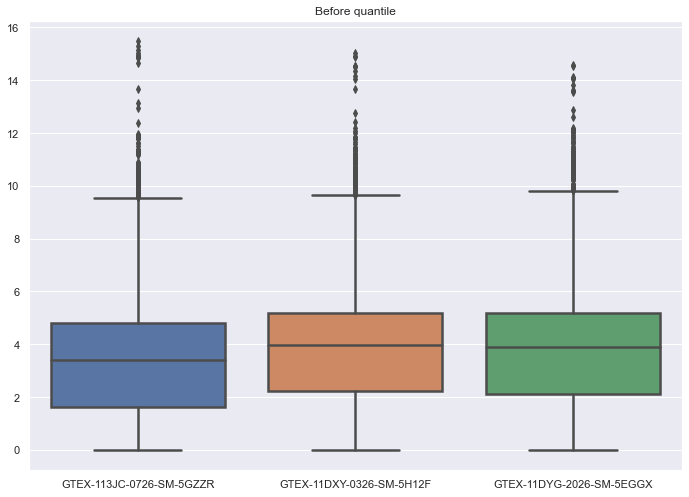

(15679, 151)


GTEX-113JC-0726-SM-5GZZR  GTEX-11DXY-0326-SM-5H12F  \
Name                                                                     
ENSG00000187634.11                  2.524565                  3.412646   
ENSG00000188976.10                  4.915999                  5.772677   

                    GTEX-11DYG-2026-SM-5EGGX  
Name                                          
ENSG00000187634.11                  3.468583  
ENSG00000188976.10                  5.922198

df image after quantile normalization: (15679, 3)


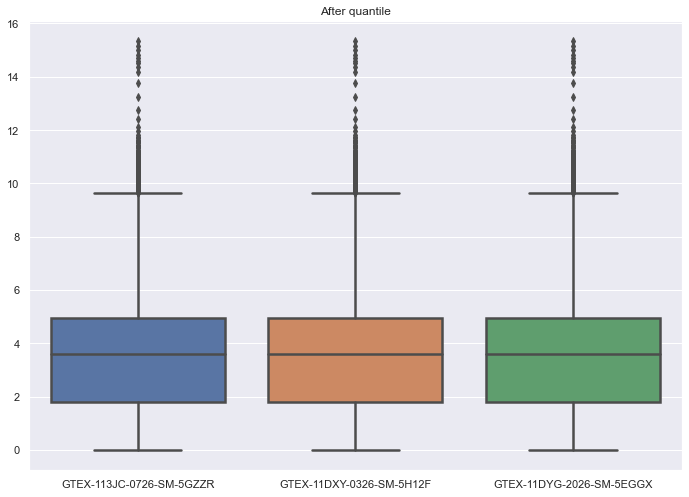

GTEX-113JC-0726-SM-5GZZR  GTEX-11DXY-0326-SM-5H12F  \
Name                                                                     
ENSG00000187634.11                  2.700942                  3.005575   
ENSG00000188976.10                  5.058929                  5.596074   

                    GTEX-11DYG-2026-SM-5EGGX  
Name                                          
ENSG00000187634.11                  3.139427  
ENSG00000188976.10                  5.663492

(151, 8)
sample outliers
(18349, 148)


GTEX-111FC-0626-SM-5N9CU  GTEX-117XS-0726-SM-5H131  \
Name                                                                     
ENSG00000186092.4                   0.067639                  0.139600   
ENSG00000278566.1                   0.000000                  0.092505   
ENSG00000273547.1                   0.000000                  0.136625   
ENSG00000187634.11                  4.317594                  3.376151   
ENSG00000188976.10                  5.391974                  4.418865   

                    GTEX-1192W-0226-SM-5EGGT  GTEX-11DXY-1026-SM-5987V  \
Name                                                                     
ENSG00000186092.4                   0.297250                  0.127145   
ENSG00000278566.1                   0.052805                  0.201759   
ENSG00000273547.1                   0.152897                  0.163628   
ENSG00000187634.11                  3.440421                  2.296311   
ENSG00000188976.10                  4.712596                  3.835924   

                    GTEX-11DYG-1026-SM-5A5JQ  GTEX-11EMC-0826-SM-59862  \
Name                                                                     
ENSG00000186092.4                   0.052096                  0.155490   
ENSG00000278566.1                   0.193835                  0.078118   
ENSG00000273547.1                   0.050954                  0.039588   
ENSG00000187634.11                  2.807767                  3.452464   
ENSG00000188976.10                  5.261155                  4.531069   

                    GTEX-11GS4-0426-SM-5N9CD  GTEX-11GSP-1226-SM-5985M  \
Name                                                                     
ENSG00000186092.4                   0.093263                  0.372506   
ENSG00000278566.1                   0.134773                  0.051024   
ENSG00000273547.1                   0.134773                  0.147958   
ENSG00000187634.11                  4.370164                  3.517276   
ENSG00000188976.10                  4.294988                  5.093814   

                    GTEX-11NUK-0926-SM-5HL57  GTEX-11NV4-0826-SM-5BC4S  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.055168                  0.282380  ...   
ENSG00000278566.1                   0.053959                  0.098231  ...   
ENSG00000273547.1                   0.053959                  0.098231  ...   
ENSG00000187634.11                  3.553361                  3.287029  ...   
ENSG00000188976.10                  4.857981                  4.927422  ...   

                    GTEX-Z93S-0326-SM-5HL84  GTEX-ZAK1-1126-SM-5PNXU  \
Name                                                                   
ENSG00000186092.4                  0.117309                 0.000000   
ENSG00000278566.1                  0.114793                 0.039475   
ENSG00000273547.1                  0.077530                 0.039475   
ENSG00000187634.11                 2.887525                 3.542258   
ENSG00000188976.10                 4.397803                 5.532005   

                    GTEX-ZDTS-1226-SM-4WKGL  GTEX-ZDXO-0426-SM-4WKF6  \
Name                                                                   
ENSG00000186092.4                  0.064262                 0.000000   
ENSG00000278566.1                  0.000000                 0.063033   
ENSG00000273547.1                  0.062854                 0.000000   
ENSG00000187634.11                 3.146981                 4.233428   
ENSG00000188976.10                 5.358959                 5.191800   

                    GTEX-ZE7O-0626-SM-57WCD  GTEX-ZUA1-0726-SM-4YCD9  \
Name                                                                   
ENSG00000186092.4                  0.218843                 0.115806   
ENSG00000278566.1                  0.056639                 0.085819   
ENSG00000273547.1                  0.056639                 0.192825   
ENSG00000187634.11  

SMRIN  SMTSISCH                     SMTSD  \
SAMPID                                                                
GTEX-111FC-0626-SM-5N9CU    7.3    1054.0  Heart - Atrial Appendage   
GTEX-117XS-0726-SM-5H131    6.9     862.0  Heart - Atrial Appendage   
GTEX-1192W-0226-SM-5EGGT    6.8     675.0  Heart - Atrial Appendage   
GTEX-11DXY-1026-SM-5987V    6.6     906.0  Heart - Atrial Appendage   
GTEX-11DYG-1026-SM-5A5JQ    6.2     851.0  Heart - Atrial Appendage   

                            SMGEBTCH      SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                                 
GTEX-111FC-0626-SM-5N9CU  LCSET-4904  GTEX-111FC  1.0  60-69      1.0  
GTEX-117XS-0726-SM-5H131  LCSET-4805  GTEX-117XS  1.0  60-69      2.0  
GTEX-1192W-0226-SM-5EGGT  LCSET-4764  GTEX-1192W  1.0  60-69      2.0  
GTEX-11DXY-1026-SM-5987V  LCSET-4417  GTEX-11DXY  1.0  60-69      2.0  
GTEX-11DYG-1026-SM-5A5JQ  LCSET-4423  GTEX-11DYG  1.0  60-69      2.0

isna
GTEX-111FC-0626-SM-5N9CU    0
GTEX-117XS-0726-SM-5H131    0
GTEX-1192W-0226-SM-5EGGT    0
GTEX-11DXY-1026-SM-5987V    0
GTEX-11DYG-1026-SM-5A5JQ    0
                           ..
GTEX-ZUA1-0726-SM-4YCD9     0
GTEX-ZVT3-0826-SM-5GIC8     0
GTEX-ZVZQ-0726-SM-51MR3     0
GTEX-ZYFC-1026-SM-5GZX9     0
GTEX-ZYT6-0926-SM-5GIEM     0
Length: 148, dtype: int64
GTEX-111FC-0626-SM-5N9CU    0
GTEX-117XS-0726-SM-5H131    0
GTEX-1192W-0226-SM-5EGGT    0
GTEX-11DXY-1026-SM-5987V    0
GTEX-11DYG-1026-SM-5A5JQ    0
                           ..
GTEX-ZUA1-0726-SM-4YCD9     0
GTEX-ZVT3-0826-SM-5GIC8     0
GTEX-ZVZQ-0726-SM-51MR3     0
GTEX-ZYFC-1026-SM-5GZX9     0
GTEX-ZYT6-0926-SM-5GIEM     0
Length: 148, dtype: int64
wasna
removing outliers
(18349, 148)
<class 'numpy.ndarray'>
components shape
(148, 20)
['GTEX-111FC-0626-SM-5N9CU', 'GTEX-117XS-0726-SM-5H131', 'GTEX-1192W-0226-SM-5EGGT', 'GTEX-11DXY-1026-SM-5987V', 'GTEX-11DYG-1026-SM-5A5JQ', 'GTEX-11EMC-0826-SM-59862', 'GTEX-11GS4-0426-SM-5N9CD'

GTEX-111FC-0626-SM-5N9CU  GTEX-117XS-0726-SM-5H131  \
Name                                                                     
ENSG00000186092.4                   0.067639                  0.139600   
ENSG00000278566.1                   0.000000                  0.092505   
ENSG00000273547.1                   0.000000                  0.136625   
ENSG00000187634.11                  4.317594                  3.376151   
ENSG00000188976.10                  5.391974                  4.418865   

                    GTEX-1192W-0226-SM-5EGGT  GTEX-11DXY-1026-SM-5987V  \
Name                                                                     
ENSG00000186092.4                   0.297250                  0.127145   
ENSG00000278566.1                   0.052805                  0.201759   
ENSG00000273547.1                   0.152897                  0.163628   
ENSG00000187634.11                  3.440421                  2.296311   
ENSG00000188976.10                  4.712596                  3.835924   

                    GTEX-11DYG-1026-SM-5A5JQ  GTEX-11EMC-0826-SM-59862  \
Name                                                                     
ENSG00000186092.4                   0.052096                  0.155490   
ENSG00000278566.1                   0.193835                  0.078118   
ENSG00000273547.1                   0.050954                  0.039588   
ENSG00000187634.11                  2.807767                  3.452464   
ENSG00000188976.10                  5.261155                  4.531069   

                    GTEX-11GS4-0426-SM-5N9CD  GTEX-11GSP-1226-SM-5985M  \
Name                                                                     
ENSG00000186092.4                   0.093263                  0.372506   
ENSG00000278566.1                   0.134773                  0.051024   
ENSG00000273547.1                   0.134773                  0.147958   
ENSG00000187634.11                  4.370164                  3.517276   
ENSG00000188976.10                  4.294988                  5.093814   

                    GTEX-11NUK-0926-SM-5HL57  GTEX-11NV4-0826-SM-5BC4S  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.055168                  0.282380  ...   
ENSG00000278566.1                   0.053959                  0.098231  ...   
ENSG00000273547.1                   0.053959                  0.098231  ...   
ENSG00000187634.11                  3.553361                  3.287029  ...   
ENSG00000188976.10                  4.857981                  4.927422  ...   

                    GTEX-Z93S-0326-SM-5HL84  GTEX-ZAK1-1126-SM-5PNXU  \
Name                                                                   
ENSG00000186092.4                  0.117309                 0.000000   
ENSG00000278566.1                  0.114793                 0.039475   
ENSG00000273547.1                  0.077530                 0.039475   
ENSG00000187634.11                 2.887525                 3.542258   
ENSG00000188976.10                 4.397803                 5.532005   

                    GTEX-ZDTS-1226-SM-4WKGL  GTEX-ZDXO-0426-SM-4WKF6  \
Name                                                                   
ENSG00000186092.4                  0.064262                 0.000000   
ENSG00000278566.1                  0.000000                 0.063033   
ENSG00000273547.1                  0.062854                 0.000000   
ENSG00000187634.11                 3.146981                 4.233428   
ENSG00000188976.10                 5.358959                 5.191800   

                    GTEX-ZE7O-0626-SM-57WCD  GTEX-ZUA1-0726-SM-4YCD9  \
Name                                                                   
ENSG00000186092.4                  0.218843                 0.115806   
ENSG00000278566.1                  0.056639                 0.085819   
ENSG00000273547.1                  0.056639                 0.192825   
ENSG00000187634.11  

(18349, 148)


SMRIN  SMTSISCH                     SMTSD  \
SAMPID                                                                
GTEX-111FC-0626-SM-5N9CU    7.3    1054.0  Heart - Atrial Appendage   
GTEX-117XS-0726-SM-5H131    6.9     862.0  Heart - Atrial Appendage   
GTEX-1192W-0226-SM-5EGGT    6.8     675.0  Heart - Atrial Appendage   
GTEX-11DXY-1026-SM-5987V    6.6     906.0  Heart - Atrial Appendage   
GTEX-11DYG-1026-SM-5A5JQ    6.2     851.0  Heart - Atrial Appendage   

                            SMGEBTCH      SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                                 
GTEX-111FC-0626-SM-5N9CU  LCSET-4904  GTEX-111FC  1.0  60-69      1.0  
GTEX-117XS-0726-SM-5H131  LCSET-4805  GTEX-117XS  1.0  60-69      2.0  
GTEX-1192W-0226-SM-5EGGT  LCSET-4764  GTEX-1192W  1.0  60-69      2.0  
GTEX-11DXY-1026-SM-5987V  LCSET-4417  GTEX-11DXY  1.0  60-69      2.0  
GTEX-11DYG-1026-SM-5A5JQ  LCSET-4423  GTEX-11DYG  1.0  60-69      2.0

(148, 8)
--- Index of Outliers ----
[36, 54, 95]
<class 'list'>
3
36
54
95
['GTEX-111FC-0626-SM-5N9CU', 'GTEX-117XS-0726-SM-5H131', 'GTEX-1192W-0226-SM-5EGGT']


0         1         2         3         4         5         6   \
0  0.091103  0.084754 -0.121136 -0.046281 -0.097087 -0.045912  0.084724   
1  0.077415  0.033056 -0.036167  0.079299  0.004261 -0.023965 -0.060255   
2  0.081170 -0.033773  0.000310 -0.007151 -0.042461  0.177353 -0.012366   
3  0.069086  0.020680  0.020199  0.149724 -0.000102  0.058720 -0.022437   
4  0.089135  0.132294 -0.022265 -0.025193 -0.017901  0.010400 -0.075712   

         7         8         9         10        11        12        13  \
0 -0.021521  0.109898 -0.009436  0.032913  0.040851  0.067464  0.049508   
1  0.033452 -0.014508 -0.033941  0.025935 -0.012068 -0.031674  0.031246   
2 -0.108453 -0.059896  0.038730  0.076787  0.036944 -0.057230 -0.085976   
3 -0.050371  0.059971  0.048862  0.023630 -0.108489  0.103383 -0.073015   
4  0.046766 -0.057170 -0.073114  0.007809 -0.005458  0.166322 -0.010678   

         14        15        16        17        18        19  
0  0.095461 -0.025132  0.027862  0.033782 -0.072617 -0.015425  
1  0.014037  0.070666 -0.071541 -0.011749  0.069500  0.052312  
2  0.147827  0.015407 -0.057364  0.081578  0.091952 -0.066573  
3 -0.014624  0.052370  0.019085  0.001763  0.077179 -0.058014  
4  0.127108 -0.049448 -0.004110 -0.051057  0.081978 -0.001949

dropping outliers
matrix shape before drop
(18349, 148)
matrix shape after drop
(18349, 145)
sample shape before drop
(148, 8)
sample shape after drop
(145, 8)
Name
ENSG00000186092.4     0.066637
ENSG00000278566.1     0.014396
ENSG00000273547.1     0.005327
ENSG00000187634.11    0.731829
ENSG00000188976.10    0.297997
                        ...   
ENSG00000212907.2     0.344049
ENSG00000198886.2     0.242004
ENSG00000198786.2     0.275052
ENSG00000198695.2     0.450965
ENSG00000198727.2     0.250611
Length: 18349, dtype: float64
length of excluded list
3437
df image before quantile normalization: (14912, 3)


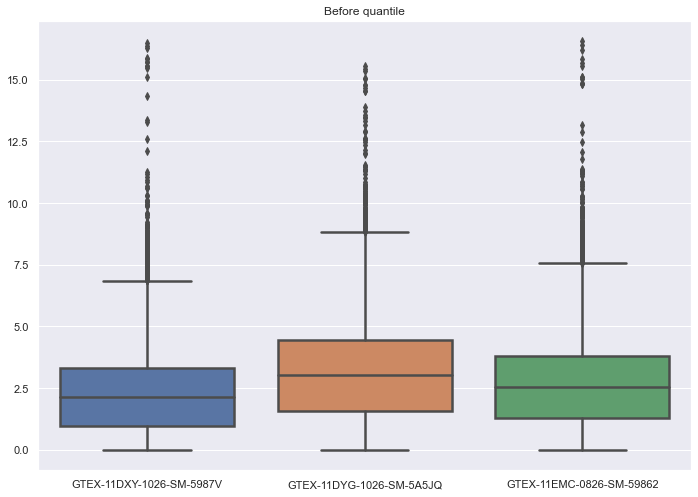

(14912, 145)


GTEX-11DXY-1026-SM-5987V  GTEX-11DYG-1026-SM-5A5JQ  \
Name                                                                     
ENSG00000186092.4                   0.127145                  0.052096   
ENSG00000187634.11                  2.296311                  2.807767   

                    GTEX-11EMC-0826-SM-59862  
Name                                          
ENSG00000186092.4                   0.155490  
ENSG00000187634.11                  3.452464

df image after quantile normalization: (14912, 3)


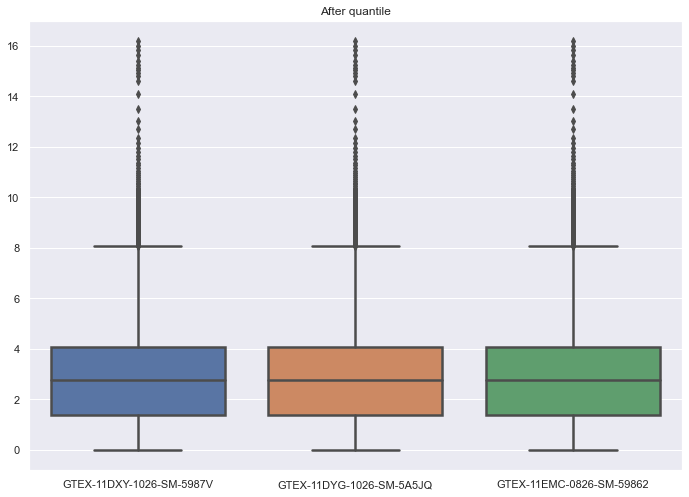

GTEX-11DXY-1026-SM-5987V  GTEX-11DYG-1026-SM-5A5JQ  \
Name                                                                     
ENSG00000186092.4                   0.200237                  0.033774   
ENSG00000187634.11                  2.938361                  2.523151   

                    GTEX-11EMC-0826-SM-59862  
Name                                          
ENSG00000186092.4                   0.153710  
ENSG00000187634.11                  3.704927

(145, 8)
sample outliers
(18349, 139)


GTEX-1128S-0008-SM-5Q5DP  GTEX-113JC-0008-SM-5QGR6  \
Name                                                                     
ENSG00000186092.4                   0.062440                  0.000000   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.061071                  0.000000   
ENSG00000187634.11                  1.681224                  1.013641   
ENSG00000188976.10                  6.321207                  6.464178   

                    GTEX-117XS-0008-SM-5Q5DQ  GTEX-1192W-0008-SM-5QGRE  \
Name                                                                     
ENSG00000186092.4                   0.063020                   0.00000   
ENSG00000278566.1                   0.000000                   0.00000   
ENSG00000273547.1                   0.177471                   0.00000   
ENSG00000187634.11                  1.442545                   2.52306   
ENSG00000188976.10                  6.273143                   6.40446   

                    GTEX-11DXW-0008-SM-5Q59V  GTEX-11DXY-0008-SM-5QGR4  \
Name                                                                     
ENSG00000186092.4                   0.091409                  0.066771   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.000000                  0.000000   
ENSG00000187634.11                  1.443076                  1.092207   
ENSG00000188976.10                  6.281513                  6.125982   

                    GTEX-11DYG-0008-SM-5QGR5  GTEX-11EMC-0008-SM-5Q5DR  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.073190                  0.000000   
ENSG00000273547.1                   0.073190                  0.000000   
ENSG00000187634.11                  1.100305                  3.002523   
ENSG00000188976.10                  6.277799                  6.595444   

                    GTEX-11EQ9-0008-SM-5Q5DK  GTEX-11GS4-0008-SM-5QGRA  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.043078                  0.000000  ...   
ENSG00000278566.1                   0.042126                  0.000000  ...   
ENSG00000273547.1                   0.042126                  0.084513  ...   
ENSG00000187634.11                  0.536550                  1.809826  ...   
ENSG00000188976.10                  4.521051                  6.078738  ...   

                    GTEX-Z93S-0008-SM-4RGM5  GTEX-ZDTS-0008-SM-4E3I8  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.049826   
ENSG00000278566.1                  0.101300                 0.048724   
ENSG00000273547.1                  0.101300                 0.048724   
ENSG00000187634.11                 0.148739                 0.957469   
ENSG00000188976.10                 6.439956                 6.191405   

                    GTEX-ZDXO-0008-SM-4E3HR  GTEX-ZE7O-0008-SM-4E3JQ  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.000000   
ENSG00000278566.1                  0.110216                 0.000000   
ENSG00000273547.1                  0.000000                 0.000000   
ENSG00000187634.11                 1.930927                 1.299245   
ENSG00000188976.10                 6.248497                 6.118111   

                    GTEX-ZE9C-0008-SM-4E3K6  GTEX-ZUA1-0008-SM-4YCEW  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.000000   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.125704                 0.129402   
ENSG00000187634.11  

SMRIN  SMTSISCH                         SMTSD  \
SAMPID                                                                    
GTEX-1128S-0008-SM-5Q5DP    8.9     886.0  Cells - Cultured fibroblasts   
GTEX-113JC-0008-SM-5QGR6   10.0     681.0  Cells - Cultured fibroblasts   
GTEX-117XS-0008-SM-5Q5DQ   10.0     917.0  Cells - Cultured fibroblasts   
GTEX-1192W-0008-SM-5QGRE    9.9     810.0  Cells - Cultured fibroblasts   
GTEX-11DXW-0008-SM-5Q59V    9.1    1091.0  Cells - Cultured fibroblasts   

                            SMGEBTCH      SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                                 
GTEX-1128S-0008-SM-5Q5DP  LCSET-4953  GTEX-1128S  2.0  60-69      2.0  
GTEX-113JC-0008-SM-5QGR6  LCSET-4954  GTEX-113JC  2.0  50-59      2.0  
GTEX-117XS-0008-SM-5Q5DQ  LCSET-4953  GTEX-117XS  1.0  60-69      2.0  
GTEX-1192W-0008-SM-5QGRE  LCSET-4954  GTEX-1192W  1.0  60-69      2.0  
GTEX-11DXW-0008-SM-5Q59V  LCSET-4952  GTEX-11DXW  1.0  40-49      2.0

isna
GTEX-1128S-0008-SM-5Q5DP    0
GTEX-113JC-0008-SM-5QGR6    0
GTEX-117XS-0008-SM-5Q5DQ    0
GTEX-1192W-0008-SM-5QGRE    0
GTEX-11DXW-0008-SM-5Q59V    0
                           ..
GTEX-ZUA1-0008-SM-4YCEW     0
GTEX-ZV68-0008-SM-4YCCV     0
GTEX-ZVT3-0008-SM-51MRI     0
GTEX-ZVTK-0008-SM-57WDA     0
GTEX-ZVZQ-0008-SM-51MSK     0
Length: 139, dtype: int64
GTEX-1128S-0008-SM-5Q5DP    0
GTEX-113JC-0008-SM-5QGR6    0
GTEX-117XS-0008-SM-5Q5DQ    0
GTEX-1192W-0008-SM-5QGRE    0
GTEX-11DXW-0008-SM-5Q59V    0
                           ..
GTEX-ZUA1-0008-SM-4YCEW     0
GTEX-ZV68-0008-SM-4YCCV     0
GTEX-ZVT3-0008-SM-51MRI     0
GTEX-ZVTK-0008-SM-57WDA     0
GTEX-ZVZQ-0008-SM-51MSK     0
Length: 139, dtype: int64
wasna
removing outliers
(18349, 139)
<class 'numpy.ndarray'>
components shape
(139, 20)
['GTEX-1128S-0008-SM-5Q5DP', 'GTEX-113JC-0008-SM-5QGR6', 'GTEX-117XS-0008-SM-5Q5DQ', 'GTEX-1192W-0008-SM-5QGRE', 'GTEX-11DXW-0008-SM-5Q59V', 'GTEX-11DXY-0008-SM-5QGR4', 'GTEX-11DYG-0008-SM-5QGR5'

GTEX-1128S-0008-SM-5Q5DP  GTEX-113JC-0008-SM-5QGR6  \
Name                                                                     
ENSG00000186092.4                   0.062440                  0.000000   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.061071                  0.000000   
ENSG00000187634.11                  1.681224                  1.013641   
ENSG00000188976.10                  6.321207                  6.464178   

                    GTEX-117XS-0008-SM-5Q5DQ  GTEX-1192W-0008-SM-5QGRE  \
Name                                                                     
ENSG00000186092.4                   0.063020                   0.00000   
ENSG00000278566.1                   0.000000                   0.00000   
ENSG00000273547.1                   0.177471                   0.00000   
ENSG00000187634.11                  1.442545                   2.52306   
ENSG00000188976.10                  6.273143                   6.40446   

                    GTEX-11DXW-0008-SM-5Q59V  GTEX-11DXY-0008-SM-5QGR4  \
Name                                                                     
ENSG00000186092.4                   0.091409                  0.066771   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.000000                  0.000000   
ENSG00000187634.11                  1.443076                  1.092207   
ENSG00000188976.10                  6.281513                  6.125982   

                    GTEX-11DYG-0008-SM-5QGR5  GTEX-11EMC-0008-SM-5Q5DR  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.073190                  0.000000   
ENSG00000273547.1                   0.073190                  0.000000   
ENSG00000187634.11                  1.100305                  3.002523   
ENSG00000188976.10                  6.277799                  6.595444   

                    GTEX-11EQ9-0008-SM-5Q5DK  GTEX-11GS4-0008-SM-5QGRA  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.043078                  0.000000  ...   
ENSG00000278566.1                   0.042126                  0.000000  ...   
ENSG00000273547.1                   0.042126                  0.084513  ...   
ENSG00000187634.11                  0.536550                  1.809826  ...   
ENSG00000188976.10                  4.521051                  6.078738  ...   

                    GTEX-Z93S-0008-SM-4RGM5  GTEX-ZDTS-0008-SM-4E3I8  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.049826   
ENSG00000278566.1                  0.101300                 0.048724   
ENSG00000273547.1                  0.101300                 0.048724   
ENSG00000187634.11                 0.148739                 0.957469   
ENSG00000188976.10                 6.439956                 6.191405   

                    GTEX-ZDXO-0008-SM-4E3HR  GTEX-ZE7O-0008-SM-4E3JQ  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.000000   
ENSG00000278566.1                  0.110216                 0.000000   
ENSG00000273547.1                  0.000000                 0.000000   
ENSG00000187634.11                 1.930927                 1.299245   
ENSG00000188976.10                 6.248497                 6.118111   

                    GTEX-ZE9C-0008-SM-4E3K6  GTEX-ZUA1-0008-SM-4YCEW  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.000000   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.125704                 0.129402   
ENSG00000187634.11  

(18349, 139)


SMRIN  SMTSISCH                         SMTSD  \
SAMPID                                                                    
GTEX-1128S-0008-SM-5Q5DP    8.9     886.0  Cells - Cultured fibroblasts   
GTEX-113JC-0008-SM-5QGR6   10.0     681.0  Cells - Cultured fibroblasts   
GTEX-117XS-0008-SM-5Q5DQ   10.0     917.0  Cells - Cultured fibroblasts   
GTEX-1192W-0008-SM-5QGRE    9.9     810.0  Cells - Cultured fibroblasts   
GTEX-11DXW-0008-SM-5Q59V    9.1    1091.0  Cells - Cultured fibroblasts   

                            SMGEBTCH      SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                                 
GTEX-1128S-0008-SM-5Q5DP  LCSET-4953  GTEX-1128S  2.0  60-69      2.0  
GTEX-113JC-0008-SM-5QGR6  LCSET-4954  GTEX-113JC  2.0  50-59      2.0  
GTEX-117XS-0008-SM-5Q5DQ  LCSET-4953  GTEX-117XS  1.0  60-69      2.0  
GTEX-1192W-0008-SM-5QGRE  LCSET-4954  GTEX-1192W  1.0  60-69      2.0  
GTEX-11DXW-0008-SM-5Q59V  LCSET-4952  GTEX-11DXW  1.0  40-49      2.0

(139, 8)
--- Index of Outliers ----
[8]
<class 'list'>
1
8
['GTEX-1128S-0008-SM-5Q5DP']


0         1         2         3         4         5         6   \
0  0.082934  0.094442  0.058662  0.053523  0.039474  0.042155  0.170920   
1  0.084679  0.007554  0.065970  0.202482 -0.005145  0.030484 -0.069788   
2  0.084523  0.043926  0.051202  0.038100  0.115129 -0.007973 -0.117304   
3  0.083968  0.030448  0.067805 -0.035937 -0.100037 -0.022213 -0.118947   
4  0.084276  0.058594  0.076408  0.148097  0.031005  0.059370 -0.006153   

         7         8         9         10        11        12        13  \
0 -0.107493 -0.047062  0.186095 -0.117849 -0.053888  0.006870 -0.107650   
1  0.000017 -0.025416 -0.026866 -0.186731 -0.044315 -0.262058 -0.162402   
2 -0.024882  0.037846  0.113289 -0.003694  0.009834 -0.080714  0.113614   
3  0.031186  0.016412  0.064448 -0.022724  0.062075  0.079704 -0.014735   
4 -0.046427  0.022512  0.205449  0.043934  0.008744 -0.057733 -0.013126   

         14        15        16        17        18        19  
0  0.080969 -0.071376 -0.135903  0.064933  0.045356 -0.001198  
1  0.136273  0.088870  0.000069  0.060196 -0.168824 -0.084941  
2 -0.064709  0.022117 -0.031938  0.039395  0.068436  0.042971  
3 -0.041814  0.018849 -0.125144 -0.068750 -0.018381 -0.066953  
4  0.021715  0.038648 -0.038777 -0.074483  0.045647 -0.040271

dropping outliers
matrix shape before drop
(18349, 139)
matrix shape after drop
(18349, 138)
sample shape before drop
(139, 8)
sample shape after drop
(138, 8)
Name
ENSG00000186092.4     0.004411
ENSG00000278566.1     0.002256
ENSG00000273547.1     0.001856
ENSG00000187634.11    2.205564
ENSG00000188976.10    0.378630
                        ...   
ENSG00000212907.2     0.096109
ENSG00000198886.2     0.107989
ENSG00000198786.2     0.099788
ENSG00000198695.2     0.201423
ENSG00000198727.2     0.100476
Length: 18349, dtype: float64
length of excluded list
4273
df image before quantile normalization: (14076, 3)


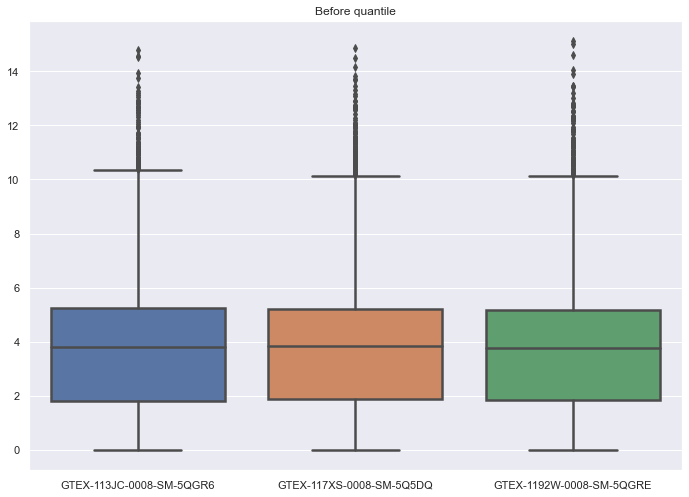

(14076, 138)


GTEX-113JC-0008-SM-5QGR6  GTEX-117XS-0008-SM-5Q5DQ  \
Name                                                                     
ENSG00000187634.11                  1.013641                  1.442545   
ENSG00000188976.10                  6.464178                  6.273143   

                    GTEX-1192W-0008-SM-5QGRE  
Name                                          
ENSG00000187634.11                   2.52306  
ENSG00000188976.10                   6.40446

df image after quantile normalization: (14076, 3)


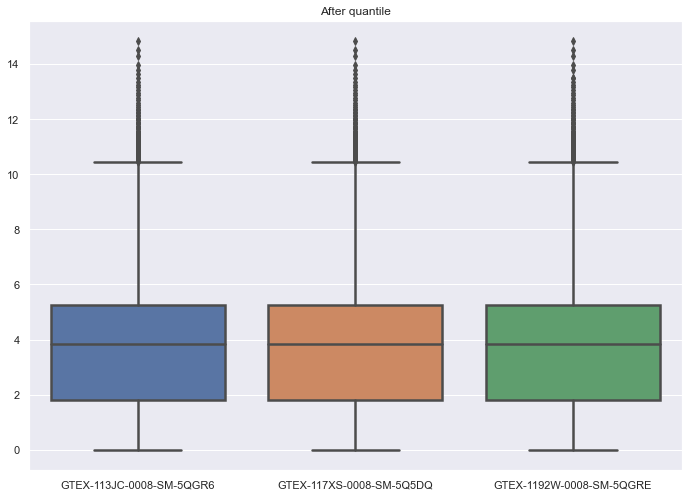

GTEX-113JC-0008-SM-5QGR6  GTEX-117XS-0008-SM-5Q5DQ  \
Name                                                                     
ENSG00000187634.11                  1.055522                  1.378019   
ENSG00000188976.10                  6.457207                  6.365833   

                    GTEX-1192W-0008-SM-5QGRE  
Name                                          
ENSG00000187634.11                   2.52647  
ENSG00000188976.10                   6.50118

(138, 8)
sample outliers
(18349, 129)


GTEX-111FC-1926-SM-5GZYC  GTEX-117XS-2026-SM-5GID1  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.108384                  0.073464   
ENSG00000187634.11                  2.556307                  2.725959   
ENSG00000188976.10                  6.305423                  6.562395   

                    GTEX-11DXY-0226-SM-5H123  GTEX-11EQ9-1926-SM-5PNVV  \
Name                                                                     
ENSG00000186092.4                   0.149650                  0.000000   
ENSG00000278566.1                   0.075108                  0.192952   
ENSG00000273547.1                   0.075108                  0.000000   
ENSG00000187634.11                  3.687061                  3.113367   
ENSG00000188976.10                  6.576673                  6.447910   

                    GTEX-11GS4-2026-SM-5N9CP  GTEX-11NUK-2626-SM-5A5MB  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.063972   
ENSG00000278566.1                   0.000000                  0.062564   
ENSG00000273547.1                   0.083438                  0.122540   
ENSG00000187634.11                  2.964214                  2.702879   
ENSG00000188976.10                  6.644866                  6.430620   

                    GTEX-11NV4-1726-SM-5N9FC  GTEX-11O72-0726-SM-5P9GO  \
Name                                                                     
ENSG00000186092.4                   0.118081                  0.000000   
ENSG00000278566.1                   0.058926                  0.000000   
ENSG00000273547.1                   0.115553                  0.000000   
ENSG00000187634.11                  2.566328                  2.806324   
ENSG00000188976.10                  6.514438                  6.420718   

                    GTEX-11OF3-1826-SM-5987N  GTEX-11ONC-2226-SM-5HL6D  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.051372                  0.202512  ...   
ENSG00000278566.1                   0.050244                  0.000000  ...   
ENSG00000273547.1                   0.050244                  0.000000  ...   
ENSG00000187634.11                  3.036679                  2.802193  ...   
ENSG00000188976.10                  6.325530                  6.571677  ...   

                    GTEX-WZTO-0326-SM-4PQYZ  GTEX-XBEC-0126-SM-4GIDT  \
Name                                                                   
ENSG00000186092.4                  0.091002                 0.000000   
ENSG00000278566.1                  0.089024                 0.128927   
ENSG00000273547.1                  0.172872                 0.000000   
ENSG00000187634.11                 2.515258                 2.959028   
ENSG00000188976.10                 6.781360                 6.812498   

                    GTEX-XQ3S-2726-SM-4BOP2  GTEX-Y111-2426-SM-4TT23  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.295841   
ENSG00000278566.1                  0.000000                 0.052541   
ENSG00000273547.1                  0.000000                 0.052541   
ENSG00000187634.11                 3.095587                 2.809414   
ENSG00000188976.10                 6.742815                 6.687901   

                    GTEX-YJ89-0626-SM-4TT3Z  GTEX-Z93S-1726-SM-5HL8G  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.216734   
ENSG00000278566.1                  0.116325                 0.144830   
ENSG00000273547.1                  0.059328                 0.000000   
ENSG00000187634.11  

SMRIN  SMTSISCH   SMTSD    SMGEBTCH      SUBJID  \
SAMPID                                                                      
GTEX-111FC-1926-SM-5GZYC    5.9    1116.0  Testis  LCSET-4804  GTEX-111FC   
GTEX-117XS-2026-SM-5GID1    6.8     896.0  Testis  LCSET-4796  GTEX-117XS   
GTEX-11DXY-0226-SM-5H123    5.8     882.0  Testis  LCSET-4805  GTEX-11DXY   
GTEX-11EQ9-1926-SM-5PNVV    7.9     134.0  Testis  LCSET-4917  GTEX-11EQ9   
GTEX-11GS4-2026-SM-5N9CP    7.2     846.0  Testis  LCSET-4904  GTEX-11GS4   

                          SEX    AGE  DTHHRDY  
SAMPID                                         
GTEX-111FC-1926-SM-5GZYC  1.0  60-69      1.0  
GTEX-117XS-2026-SM-5GID1  1.0  60-69      2.0  
GTEX-11DXY-0226-SM-5H123  1.0  60-69      2.0  
GTEX-11EQ9-1926-SM-5PNVV  1.0  30-39      2.0  
GTEX-11GS4-2026-SM-5N9CP  1.0  60-69      2.0

isna
GTEX-111FC-1926-SM-5GZYC    0
GTEX-117XS-2026-SM-5GID1    0
GTEX-11DXY-0226-SM-5H123    0
GTEX-11EQ9-1926-SM-5PNVV    0
GTEX-11GS4-2026-SM-5N9CP    0
                           ..
GTEX-Z93S-1726-SM-5HL8G     0
GTEX-ZUA1-2726-SM-59HLJ     0
GTEX-ZVTK-0126-SM-57WDG     0
GTEX-ZYFC-0126-SM-5GIEH     0
GTEX-ZYT6-2726-SM-5GICP     0
Length: 129, dtype: int64
GTEX-111FC-1926-SM-5GZYC    0
GTEX-117XS-2026-SM-5GID1    0
GTEX-11DXY-0226-SM-5H123    0
GTEX-11EQ9-1926-SM-5PNVV    0
GTEX-11GS4-2026-SM-5N9CP    0
                           ..
GTEX-Z93S-1726-SM-5HL8G     0
GTEX-ZUA1-2726-SM-59HLJ     0
GTEX-ZVTK-0126-SM-57WDG     0
GTEX-ZYFC-0126-SM-5GIEH     0
GTEX-ZYT6-2726-SM-5GICP     0
Length: 129, dtype: int64
wasna
removing outliers
(18349, 129)
<class 'numpy.ndarray'>
components shape
(129, 20)
['GTEX-111FC-1926-SM-5GZYC', 'GTEX-117XS-2026-SM-5GID1', 'GTEX-11DXY-0226-SM-5H123', 'GTEX-11EQ9-1926-SM-5PNVV', 'GTEX-11GS4-2026-SM-5N9CP', 'GTEX-11NUK-2626-SM-5A5MB', 'GTEX-11NV4-1726-SM-5N9FC'

GTEX-111FC-1926-SM-5GZYC  GTEX-117XS-2026-SM-5GID1  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.108384                  0.073464   
ENSG00000187634.11                  2.556307                  2.725959   
ENSG00000188976.10                  6.305423                  6.562395   

                    GTEX-11DXY-0226-SM-5H123  GTEX-11EQ9-1926-SM-5PNVV  \
Name                                                                     
ENSG00000186092.4                   0.149650                  0.000000   
ENSG00000278566.1                   0.075108                  0.192952   
ENSG00000273547.1                   0.075108                  0.000000   
ENSG00000187634.11                  3.687061                  3.113367   
ENSG00000188976.10                  6.576673                  6.447910   

                    GTEX-11GS4-2026-SM-5N9CP  GTEX-11NUK-2626-SM-5A5MB  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.063972   
ENSG00000278566.1                   0.000000                  0.062564   
ENSG00000273547.1                   0.083438                  0.122540   
ENSG00000187634.11                  2.964214                  2.702879   
ENSG00000188976.10                  6.644866                  6.430620   

                    GTEX-11NV4-1726-SM-5N9FC  GTEX-11O72-0726-SM-5P9GO  \
Name                                                                     
ENSG00000186092.4                   0.118081                  0.000000   
ENSG00000278566.1                   0.058926                  0.000000   
ENSG00000273547.1                   0.115553                  0.000000   
ENSG00000187634.11                  2.566328                  2.806324   
ENSG00000188976.10                  6.514438                  6.420718   

                    GTEX-11OF3-1826-SM-5987N  GTEX-11ONC-2226-SM-5HL6D  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.051372                  0.202512  ...   
ENSG00000278566.1                   0.050244                  0.000000  ...   
ENSG00000273547.1                   0.050244                  0.000000  ...   
ENSG00000187634.11                  3.036679                  2.802193  ...   
ENSG00000188976.10                  6.325530                  6.571677  ...   

                    GTEX-WZTO-0326-SM-4PQYZ  GTEX-XBEC-0126-SM-4GIDT  \
Name                                                                   
ENSG00000186092.4                  0.091002                 0.000000   
ENSG00000278566.1                  0.089024                 0.128927   
ENSG00000273547.1                  0.172872                 0.000000   
ENSG00000187634.11                 2.515258                 2.959028   
ENSG00000188976.10                 6.781360                 6.812498   

                    GTEX-XQ3S-2726-SM-4BOP2  GTEX-Y111-2426-SM-4TT23  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.295841   
ENSG00000278566.1                  0.000000                 0.052541   
ENSG00000273547.1                  0.000000                 0.052541   
ENSG00000187634.11                 3.095587                 2.809414   
ENSG00000188976.10                 6.742815                 6.687901   

                    GTEX-YJ89-0626-SM-4TT3Z  GTEX-Z93S-1726-SM-5HL8G  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.216734   
ENSG00000278566.1                  0.116325                 0.144830   
ENSG00000273547.1                  0.059328                 0.000000   
ENSG00000187634.11  

(18349, 129)


SMRIN  SMTSISCH   SMTSD    SMGEBTCH      SUBJID  \
SAMPID                                                                      
GTEX-111FC-1926-SM-5GZYC    5.9    1116.0  Testis  LCSET-4804  GTEX-111FC   
GTEX-117XS-2026-SM-5GID1    6.8     896.0  Testis  LCSET-4796  GTEX-117XS   
GTEX-11DXY-0226-SM-5H123    5.8     882.0  Testis  LCSET-4805  GTEX-11DXY   
GTEX-11EQ9-1926-SM-5PNVV    7.9     134.0  Testis  LCSET-4917  GTEX-11EQ9   
GTEX-11GS4-2026-SM-5N9CP    7.2     846.0  Testis  LCSET-4904  GTEX-11GS4   

                          SEX    AGE  DTHHRDY  
SAMPID                                         
GTEX-111FC-1926-SM-5GZYC  1.0  60-69      1.0  
GTEX-117XS-2026-SM-5GID1  1.0  60-69      2.0  
GTEX-11DXY-0226-SM-5H123  1.0  60-69      2.0  
GTEX-11EQ9-1926-SM-5PNVV  1.0  30-39      2.0  
GTEX-11GS4-2026-SM-5N9CP  1.0  60-69      2.0

(129, 8)
--- Index of Outliers ----
[13, 40, 61, 76]
<class 'list'>
4
13
40
61
76
['GTEX-111FC-1926-SM-5GZYC', 'GTEX-117XS-2026-SM-5GID1', 'GTEX-11DXY-0226-SM-5H123', 'GTEX-11EQ9-1926-SM-5PNVV']


0         1         2         3         4         5         6   \
0  0.084821  0.012148 -0.025875  0.067193 -0.090634 -0.008403  0.005564   
1  0.089272  0.032010  0.025358 -0.077973  0.000938  0.073569 -0.071580   
2  0.086817 -0.281590 -0.161643 -0.064487 -0.010539 -0.101912 -0.104115   
3  0.088596  0.046489 -0.029920 -0.193068 -0.062889  0.039364  0.032357   
4  0.091650  0.023275  0.041147 -0.038698 -0.031681  0.001233 -0.058657   

         7         8         9         10        11        12        13  \
0  0.000318 -0.122410 -0.040684 -0.011780 -0.028525  0.062751  0.046246   
1  0.025155  0.061891 -0.029102  0.005030  0.036545  0.000347 -0.009134   
2 -0.237155  0.087593 -0.126891 -0.078420  0.169837  0.153182 -0.048041   
3  0.139922 -0.022411 -0.233997 -0.098694 -0.184747 -0.158474 -0.224495   
4 -0.010110 -0.073188 -0.035766  0.029598 -0.035470  0.007968  0.124886   

         14        15        16        17        18        19  
0  0.145428 -0.159366 -0.007432 -0.043150  0.016388 -0.077345  
1  0.011381  0.085480 -0.195126  0.045740  0.045725 -0.096070  
2 -0.002791 -0.117299 -0.028999 -0.162874  0.164611  0.080362  
3  0.028475  0.004589 -0.082560  0.022588 -0.108729 -0.030225  
4  0.043177 -0.033271  0.094509  0.101908  0.052805  0.042960

dropping outliers
matrix shape before drop
(18349, 129)
matrix shape after drop
(18349, 125)
sample shape before drop
(129, 8)
sample shape after drop
(125, 8)
Name
ENSG00000186092.4     0.006226
ENSG00000278566.1     0.004214
ENSG00000273547.1     0.003602
ENSG00000187634.11    0.161159
ENSG00000188976.10    0.055042
                        ...   
ENSG00000212907.2     0.245131
ENSG00000198886.2     0.221350
ENSG00000198786.2     0.235697
ENSG00000198695.2     0.351493
ENSG00000198727.2     0.195899
Length: 18349, dtype: float64
length of excluded list
1137
df image before quantile normalization: (17212, 3)


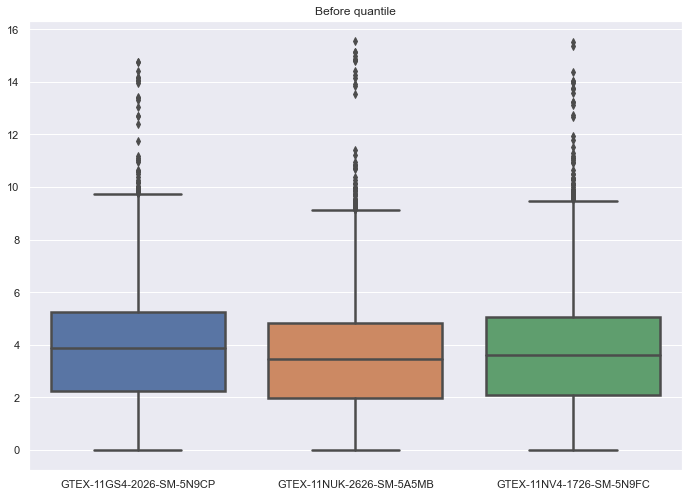

(17212, 125)


GTEX-11GS4-2026-SM-5N9CP  GTEX-11NUK-2626-SM-5A5MB  \
Name                                                                     
ENSG00000187634.11                  2.964214                  2.702879   
ENSG00000188976.10                  6.644866                  6.430620   

                    GTEX-11NV4-1726-SM-5N9FC  
Name                                          
ENSG00000187634.11                  2.566328  
ENSG00000188976.10                  6.514438

df image after quantile normalization: (17212, 3)


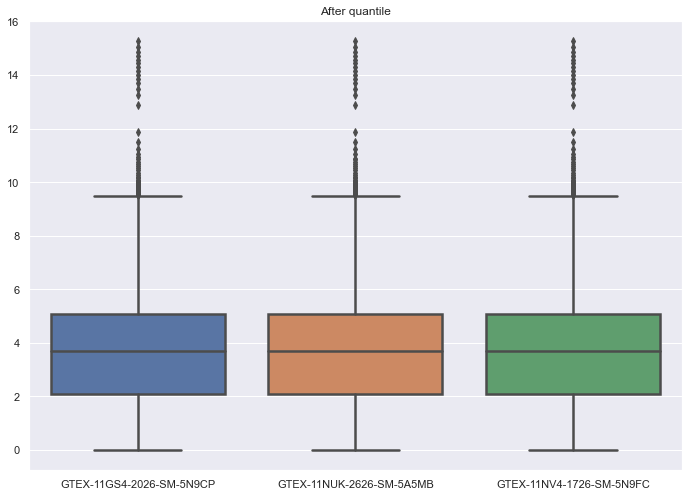

GTEX-11GS4-2026-SM-5N9CP  GTEX-11NUK-2626-SM-5A5MB  \
Name                                                                     
ENSG00000187634.11                  2.778188                  2.863721   
ENSG00000188976.10                  6.461548                  6.616094   

                    GTEX-11NV4-1726-SM-5N9FC  
Name                                          
ENSG00000187634.11                  2.618955  
ENSG00000188976.10                  6.425829

(125, 8)
sample outliers
(18349, 125)


GTEX-117XS-1926-SM-5GICO  GTEX-11DXW-0626-SM-5N9ER  \
Name                                                                     
ENSG00000186092.4                   0.086118                  0.158854   
ENSG00000278566.1                   0.202010                  0.000000   
ENSG00000273547.1                   0.202010                  0.105504   
ENSG00000187634.11                  0.502127                  2.541019   
ENSG00000188976.10                  5.114367                  5.908573   

                    GTEX-11DXY-2326-SM-5GICW  GTEX-11EMC-2026-SM-5A5JV  \
Name                                                                     
ENSG00000186092.4                   0.111793                  0.062840   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.109387                  0.061458   
ENSG00000187634.11                  1.726395                  1.543001   
ENSG00000188976.10                  5.026800                  6.426936   

                    GTEX-11EQ9-1826-SM-5Q5AJ  GTEX-11GS4-2126-SM-5A5KR  \
Name                                                                     
ENSG00000186092.4                   0.224040                  0.078610   
ENSG00000278566.1                   0.000000                  0.076901   
ENSG00000273547.1                   0.167615                  0.149910   
ENSG00000187634.11                  1.577248                  2.894527   
ENSG00000188976.10                  5.659925                  6.168321   

                    GTEX-11GSO-1926-SM-5A5K3  GTEX-11GSP-0926-SM-9WYSG  \
Name                                                                     
ENSG00000186092.4                   0.061679                  0.000000   
ENSG00000278566.1                   0.000000                  0.051692   
ENSG00000273547.1                   0.118240                  0.000000   
ENSG00000187634.11                  0.902652                  1.434562   
ENSG00000188976.10                  5.187847                  5.620000   

                    GTEX-11NV4-2026-SM-5N9DG  GTEX-11O72-2126-SM-5N9FO  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.125109                  0.146134  ...   
ENSG00000278566.1                   0.000000                  0.096896  ...   
ENSG00000273547.1                   0.122421                  0.096896  ...   
ENSG00000187634.11                  3.012211                  1.353888  ...   
ENSG00000188976.10                  5.687341                  5.394377  ...   

                    GTEX-YFC4-1426-SM-5IFJG  GTEX-YJ8O-2226-SM-5IFHW  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.000000   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.000000                 0.000000   
ENSG00000187634.11                 1.523060                 2.660381   
ENSG00000188976.10                 6.265099                 5.547512   

                    GTEX-ZAK1-1326-SM-EVYAS  GTEX-ZDXO-0126-SM-5S2ND  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.070939   
ENSG00000278566.1                  0.000000                 0.069386   
ENSG00000273547.1                  0.000000                 0.000000   
ENSG00000187634.11                 1.183963                 1.488515   
ENSG00000188976.10                 5.958611                 5.471838   

                    GTEX-ZU9S-1926-SM-5NQBP  GTEX-ZUA1-1526-SM-59HLS  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.173255   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.000000                 0.272501   
ENSG00000187634.11  

SMRIN  SMTSISCH                    SMTSD  \
SAMPID                                                               
GTEX-117XS-1926-SM-5GICO    6.0     894.0  Breast - Mammary Tissue   
GTEX-11DXW-0626-SM-5N9ER    5.7    1102.0  Breast - Mammary Tissue   
GTEX-11DXY-2326-SM-5GICW    7.0     948.0  Breast - Mammary Tissue   
GTEX-11EMC-2026-SM-5A5JV    6.2     736.0  Breast - Mammary Tissue   
GTEX-11EQ9-1826-SM-5Q5AJ    6.0     131.0  Breast - Mammary Tissue   

                                       SMGEBTCH      SUBJID  SEX    AGE  \
SAMPID                                                                    
GTEX-117XS-1926-SM-5GICO  LCSET-4796,LCSET-5161  GTEX-117XS  1.0  60-69   
GTEX-11DXW-0626-SM-5N9ER             LCSET-4905  GTEX-11DXW  1.0  40-49   
GTEX-11DXY-2326-SM-5GICW             LCSET-4796  GTEX-11DXY  1.0  60-69   
GTEX-11EMC-2026-SM-5A5JV             LCSET-4423  GTEX-11EMC  2.0  60-69   
GTEX-11EQ9-1826-SM-5Q5AJ             LCSET-4952  GTEX-11EQ9  1.0  30-39   

                          DTHHRDY  
SAMPID                             
GTEX-117XS-1926-SM-5GICO      2.0  
GTEX-11DXW-0626-SM-5N9ER      2.0  
GTEX-11DXY-2326-SM-5GICW      2.0  
GTEX-11EMC-2026-SM-5A5JV      2.0  
GTEX-11EQ9-1826-SM-5Q5AJ      2.0

isna
GTEX-117XS-1926-SM-5GICO    0
GTEX-11DXW-0626-SM-5N9ER    0
GTEX-11DXY-2326-SM-5GICW    0
GTEX-11EMC-2026-SM-5A5JV    0
GTEX-11EQ9-1826-SM-5Q5AJ    0
                           ..
GTEX-ZUA1-1526-SM-59HLS     0
GTEX-ZVTK-0326-SM-51MRR     0
GTEX-ZVZQ-0826-SM-51MRF     0
GTEX-ZYFC-0826-SM-5E44K     0
GTEX-ZYT6-0126-SM-5E45J     0
Length: 125, dtype: int64
GTEX-117XS-1926-SM-5GICO    0
GTEX-11DXW-0626-SM-5N9ER    0
GTEX-11DXY-2326-SM-5GICW    0
GTEX-11EMC-2026-SM-5A5JV    0
GTEX-11EQ9-1826-SM-5Q5AJ    0
                           ..
GTEX-ZUA1-1526-SM-59HLS     0
GTEX-ZVTK-0326-SM-51MRR     0
GTEX-ZVZQ-0826-SM-51MRF     0
GTEX-ZYFC-0826-SM-5E44K     0
GTEX-ZYT6-0126-SM-5E45J     0
Length: 125, dtype: int64
wasna
removing outliers
(18349, 125)
<class 'numpy.ndarray'>
components shape
(125, 20)
['GTEX-117XS-1926-SM-5GICO', 'GTEX-11DXW-0626-SM-5N9ER', 'GTEX-11DXY-2326-SM-5GICW', 'GTEX-11EMC-2026-SM-5A5JV', 'GTEX-11EQ9-1826-SM-5Q5AJ', 'GTEX-11GS4-2126-SM-5A5KR', 'GTEX-11GSO-1926-SM-5A5K3'

GTEX-117XS-1926-SM-5GICO  GTEX-11DXW-0626-SM-5N9ER  \
Name                                                                     
ENSG00000186092.4                   0.086118                  0.158854   
ENSG00000278566.1                   0.202010                  0.000000   
ENSG00000273547.1                   0.202010                  0.105504   
ENSG00000187634.11                  0.502127                  2.541019   
ENSG00000188976.10                  5.114367                  5.908573   

                    GTEX-11DXY-2326-SM-5GICW  GTEX-11EMC-2026-SM-5A5JV  \
Name                                                                     
ENSG00000186092.4                   0.111793                  0.062840   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.109387                  0.061458   
ENSG00000187634.11                  1.726395                  1.543001   
ENSG00000188976.10                  5.026800                  6.426936   

                    GTEX-11EQ9-1826-SM-5Q5AJ  GTEX-11GS4-2126-SM-5A5KR  \
Name                                                                     
ENSG00000186092.4                   0.224040                  0.078610   
ENSG00000278566.1                   0.000000                  0.076901   
ENSG00000273547.1                   0.167615                  0.149910   
ENSG00000187634.11                  1.577248                  2.894527   
ENSG00000188976.10                  5.659925                  6.168321   

                    GTEX-11GSO-1926-SM-5A5K3  GTEX-11GSP-0926-SM-9WYSG  \
Name                                                                     
ENSG00000186092.4                   0.061679                  0.000000   
ENSG00000278566.1                   0.000000                  0.051692   
ENSG00000273547.1                   0.118240                  0.000000   
ENSG00000187634.11                  0.902652                  1.434562   
ENSG00000188976.10                  5.187847                  5.620000   

                    GTEX-11NV4-2026-SM-5N9DG  GTEX-11O72-2126-SM-5N9FO  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.125109                  0.146134  ...   
ENSG00000278566.1                   0.000000                  0.096896  ...   
ENSG00000273547.1                   0.122421                  0.096896  ...   
ENSG00000187634.11                  3.012211                  1.353888  ...   
ENSG00000188976.10                  5.687341                  5.394377  ...   

                    GTEX-YFC4-1426-SM-5IFJG  GTEX-YJ8O-2226-SM-5IFHW  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.000000   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.000000                 0.000000   
ENSG00000187634.11                 1.523060                 2.660381   
ENSG00000188976.10                 6.265099                 5.547512   

                    GTEX-ZAK1-1326-SM-EVYAS  GTEX-ZDXO-0126-SM-5S2ND  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.070939   
ENSG00000278566.1                  0.000000                 0.069386   
ENSG00000273547.1                  0.000000                 0.000000   
ENSG00000187634.11                 1.183963                 1.488515   
ENSG00000188976.10                 5.958611                 5.471838   

                    GTEX-ZU9S-1926-SM-5NQBP  GTEX-ZUA1-1526-SM-59HLS  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.173255   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.000000                 0.272501   
ENSG00000187634.11  

(18349, 125)


SMRIN  SMTSISCH                    SMTSD  \
SAMPID                                                               
GTEX-117XS-1926-SM-5GICO    6.0     894.0  Breast - Mammary Tissue   
GTEX-11DXW-0626-SM-5N9ER    5.7    1102.0  Breast - Mammary Tissue   
GTEX-11DXY-2326-SM-5GICW    7.0     948.0  Breast - Mammary Tissue   
GTEX-11EMC-2026-SM-5A5JV    6.2     736.0  Breast - Mammary Tissue   
GTEX-11EQ9-1826-SM-5Q5AJ    6.0     131.0  Breast - Mammary Tissue   

                                       SMGEBTCH      SUBJID  SEX    AGE  \
SAMPID                                                                    
GTEX-117XS-1926-SM-5GICO  LCSET-4796,LCSET-5161  GTEX-117XS  1.0  60-69   
GTEX-11DXW-0626-SM-5N9ER             LCSET-4905  GTEX-11DXW  1.0  40-49   
GTEX-11DXY-2326-SM-5GICW             LCSET-4796  GTEX-11DXY  1.0  60-69   
GTEX-11EMC-2026-SM-5A5JV             LCSET-4423  GTEX-11EMC  2.0  60-69   
GTEX-11EQ9-1826-SM-5Q5AJ             LCSET-4952  GTEX-11EQ9  1.0  30-39   

                          DTHHRDY  
SAMPID                             
GTEX-117XS-1926-SM-5GICO      2.0  
GTEX-11DXW-0626-SM-5N9ER      2.0  
GTEX-11DXY-2326-SM-5GICW      2.0  
GTEX-11EMC-2026-SM-5A5JV      2.0  
GTEX-11EQ9-1826-SM-5Q5AJ      2.0

(125, 8)
--- Index of Outliers ----
[16, 72]
<class 'list'>
2
16
72
['GTEX-117XS-1926-SM-5GICO', 'GTEX-11DXW-0626-SM-5N9ER']


0         1         2         3         4         5         6   \
0  0.083275 -0.099529 -0.036150  0.002755  0.084535  0.095418  0.053670   
1  0.087691  0.036905  0.071511 -0.070841  0.030997  0.009670 -0.027036   
2  0.081218 -0.101135  0.034076 -0.034353 -0.001300 -0.046044 -0.075199   
3  0.090762  0.107719 -0.039206  0.086680  0.038421 -0.004526 -0.048890   
4  0.087545 -0.062066  0.075701  0.090463  0.148490  0.009728 -0.084522   

         7         8         9         10        11        12        13  \
0  0.080393  0.087094  0.027149  0.052652 -0.035373 -0.119889  0.158820   
1 -0.016940  0.080450 -0.177074 -0.041154  0.051094 -0.010639 -0.078664   
2  0.057336 -0.010828  0.050185 -0.127527  0.047181  0.070890  0.070591   
3 -0.035113  0.061156  0.047609 -0.128108 -0.006234 -0.056562 -0.056983   
4 -0.125417 -0.058006  0.069007  0.089368 -0.126772  0.139659 -0.073436   

         14        15        16        17        18        19  
0  0.064183  0.075305  0.012686 -0.015852 -0.054666  0.193409  
1  0.051035 -0.034994  0.073484  0.118293  0.106873  0.047564  
2  0.030654 -0.038934 -0.077430 -0.021797  0.093702 -0.051275  
3  0.047787  0.191474  0.055184  0.048097 -0.082986  0.120845  
4  0.299247 -0.141548  0.115636  0.037641 -0.093757  0.019291

dropping outliers
matrix shape before drop
(18349, 125)
matrix shape after drop
(18349, 123)
sample shape before drop
(125, 8)
sample shape after drop
(123, 8)
Name
ENSG00000186092.4     0.011836
ENSG00000278566.1     0.008010
ENSG00000273547.1     0.004951
ENSG00000187634.11    0.708607
ENSG00000188976.10    0.210550
                        ...   
ENSG00000212907.2     0.464939
ENSG00000198886.2     0.372151
ENSG00000198786.2     0.317679
ENSG00000198695.2     0.467050
ENSG00000198727.2     0.406212
Length: 18349, dtype: float64
length of excluded list
1965
df image before quantile normalization: (16384, 3)


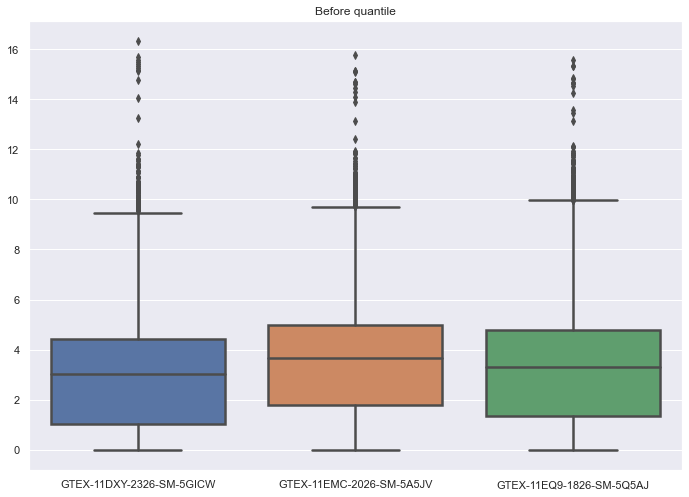

(16384, 123)


GTEX-11DXY-2326-SM-5GICW  GTEX-11EMC-2026-SM-5A5JV  \
Name                                                                     
ENSG00000187634.11                  1.726395                  1.543001   
ENSG00000188976.10                  5.026800                  6.426936   

                    GTEX-11EQ9-1826-SM-5Q5AJ  
Name                                          
ENSG00000187634.11                  1.577248  
ENSG00000188976.10                  5.659925

df image after quantile normalization: (16384, 3)


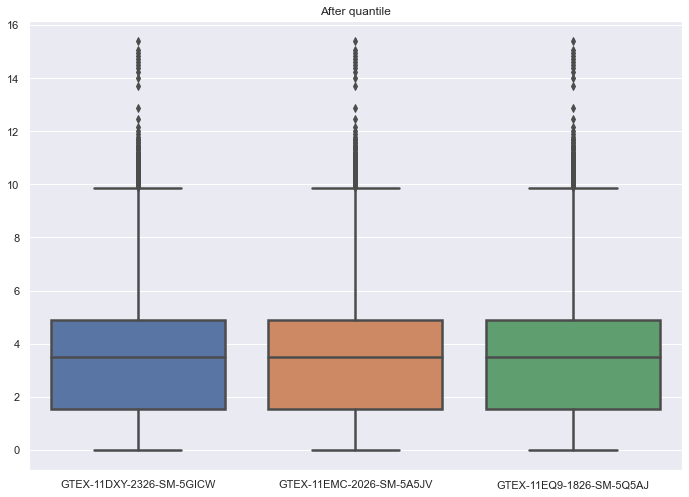

GTEX-11DXY-2326-SM-5GICW  GTEX-11EMC-2026-SM-5A5JV  \
Name                                                                     
ENSG00000187634.11                  2.280105                  1.310903   
ENSG00000188976.10                  5.466944                  6.468833   

                    GTEX-11EQ9-1826-SM-5Q5AJ  
Name                                          
ENSG00000187634.11                  1.781615  
ENSG00000188976.10                  5.696271

(123, 8)
sample outliers
(18349, 123)


GTEX-111FC-0826-SM-5GZWO  GTEX-11DXY-0826-SM-5EGGR  \
Name                                                                     
ENSG00000186092.4                   0.197865                  0.262674   
ENSG00000278566.1                   0.156914                  0.204015   
ENSG00000273547.1                   0.040864                  0.283211   
ENSG00000187634.11                  1.377957                  0.515914   
ENSG00000188976.10                  4.521051                  2.644549   

                    GTEX-11EMC-0726-SM-5EGJO  GTEX-11GS4-0526-SM-5A5KQ  \
Name                                                                     
ENSG00000186092.4                   0.035286                  0.139862   
ENSG00000278566.1                   0.101139                  0.070060   
ENSG00000273547.1                   0.000000                  0.103840   
ENSG00000187634.11                  0.768163                  1.473008   
ENSG00000188976.10                  4.269033                  3.619413   

                    GTEX-11GSP-1326-SM-5A5KY  GTEX-11O72-1126-SM-5N9E2  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.183963   
ENSG00000278566.1                   0.120060                  0.155749   
ENSG00000273547.1                   0.061279                  0.105678   
ENSG00000187634.11                  0.596840                  0.539928   
ENSG00000188976.10                  3.162371                  4.450881   

                    GTEX-11ONC-0126-SM-5PNW6  GTEX-11TUW-1026-SM-5GU7D  \
Name                                                                     
ENSG00000186092.4                   1.712816                  0.079812   
ENSG00000278566.1                   0.156785                  0.187768   
ENSG00000273547.1                   0.064773                  0.039560   
ENSG00000187634.11                  1.896853                  0.901417   
ENSG00000188976.10                  3.595742                  5.361768   

                    GTEX-11ZUS-0226-SM-5FQT8  GTEX-11ZVC-0426-SM-5CVLD  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.141302                  0.037467  ...   
ENSG00000278566.1                   0.181548                  0.072367  ...   
ENSG00000273547.1                   0.304044                  0.107233  ...   
ENSG00000187634.11                  0.550014                  0.646716  ...   
ENSG00000188976.10                  4.633431                  3.878725  ...   

                    GTEX-WZTO-1326-SM-3NM8X  GTEX-XBEC-1326-SM-4AT69  \
Name                                                                   
ENSG00000186092.4                  0.080726                 0.154194   
ENSG00000278566.1                  0.153805                 0.031466   
ENSG00000273547.1                  0.053125                 0.092410   
ENSG00000187634.11                 0.384602                 0.309642   
ENSG00000188976.10                 4.790251                 2.552623   

                    GTEX-XQ3S-0626-SM-4BOOB  GTEX-YFC4-0526-SM-5ZZVI  \
Name                                                                   
ENSG00000186092.4                  0.050077                 0.161565   
ENSG00000278566.1                  0.000000                 0.041173   
ENSG00000273547.1                  0.048975                 0.041173   
ENSG00000187634.11                 0.517225                 0.646992   
ENSG00000188976.10                 4.532940                 4.026800   

                    GTEX-YJ8O-0926-SM-EAZ2Z  GTEX-ZDTS-1326-SM-6LLHE  \
Name                                                                   
ENSG00000186092.4                  0.107045                 0.472800   
ENSG00000278566.1                  0.042812                 0.463727   
ENSG00000273547.1                  0.021565                 0.152508   
ENSG00000187634.11  

SMRIN  SMTSISCH                   SMTSD  \
SAMPID                                                              
GTEX-111FC-0826-SM-5GZWO    7.0    1060.0  Heart - Left Ventricle   
GTEX-11DXY-0826-SM-5EGGR    6.0     908.0  Heart - Left Ventricle   
GTEX-11EMC-0726-SM-5EGJO    6.5     710.0  Heart - Left Ventricle   
GTEX-11GS4-0526-SM-5A5KQ    6.6     798.0  Heart - Left Ventricle   
GTEX-11GSP-1326-SM-5A5KY    6.0     779.0  Heart - Left Ventricle   

                                       SMGEBTCH      SUBJID  SEX    AGE  \
SAMPID                                                                    
GTEX-111FC-0826-SM-5GZWO             LCSET-4804  GTEX-111FC  1.0  60-69   
GTEX-11DXY-0826-SM-5EGGR             LCSET-4764  GTEX-11DXY  1.0  60-69   
GTEX-11EMC-0726-SM-5EGJO  LCSET-4766,LCSET-4797  GTEX-11EMC  2.0  60-69   
GTEX-11GS4-0526-SM-5A5KQ             LCSET-4423  GTEX-11GS4  1.0  60-69   
GTEX-11GSP-1326-SM-5A5KY             LCSET-4423  GTEX-11GSP  2.0  60-69   

                          DTHHRDY  
SAMPID                             
GTEX-111FC-0826-SM-5GZWO      1.0  
GTEX-11DXY-0826-SM-5EGGR      2.0  
GTEX-11EMC-0726-SM-5EGJO      2.0  
GTEX-11GS4-0526-SM-5A5KQ      2.0  
GTEX-11GSP-1326-SM-5A5KY      2.0

isna
GTEX-111FC-0826-SM-5GZWO    0
GTEX-11DXY-0826-SM-5EGGR    0
GTEX-11EMC-0726-SM-5EGJO    0
GTEX-11GS4-0526-SM-5A5KQ    0
GTEX-11GSP-1326-SM-5A5KY    0
                           ..
GTEX-ZDTS-1326-SM-6LLHE     0
GTEX-ZDXO-0726-SM-57WBT     0
GTEX-ZUA1-0826-SM-4YCDL     0
GTEX-ZYFC-1126-SM-5E44W     0
GTEX-ZYT6-1726-SM-5E44P     0
Length: 123, dtype: int64
GTEX-111FC-0826-SM-5GZWO    0
GTEX-11DXY-0826-SM-5EGGR    0
GTEX-11EMC-0726-SM-5EGJO    0
GTEX-11GS4-0526-SM-5A5KQ    0
GTEX-11GSP-1326-SM-5A5KY    0
                           ..
GTEX-ZDTS-1326-SM-6LLHE     0
GTEX-ZDXO-0726-SM-57WBT     0
GTEX-ZUA1-0826-SM-4YCDL     0
GTEX-ZYFC-1126-SM-5E44W     0
GTEX-ZYT6-1726-SM-5E44P     0
Length: 123, dtype: int64
wasna
removing outliers
(18349, 123)
<class 'numpy.ndarray'>
components shape
(123, 20)
['GTEX-111FC-0826-SM-5GZWO', 'GTEX-11DXY-0826-SM-5EGGR', 'GTEX-11EMC-0726-SM-5EGJO', 'GTEX-11GS4-0526-SM-5A5KQ', 'GTEX-11GSP-1326-SM-5A5KY', 'GTEX-11O72-1126-SM-5N9E2', 'GTEX-11ONC-0126-SM-5PNW6'

GTEX-111FC-0826-SM-5GZWO  GTEX-11DXY-0826-SM-5EGGR  \
Name                                                                     
ENSG00000186092.4                   0.197865                  0.262674   
ENSG00000278566.1                   0.156914                  0.204015   
ENSG00000273547.1                   0.040864                  0.283211   
ENSG00000187634.11                  1.377957                  0.515914   
ENSG00000188976.10                  4.521051                  2.644549   

                    GTEX-11EMC-0726-SM-5EGJO  GTEX-11GS4-0526-SM-5A5KQ  \
Name                                                                     
ENSG00000186092.4                   0.035286                  0.139862   
ENSG00000278566.1                   0.101139                  0.070060   
ENSG00000273547.1                   0.000000                  0.103840   
ENSG00000187634.11                  0.768163                  1.473008   
ENSG00000188976.10                  4.269033                  3.619413   

                    GTEX-11GSP-1326-SM-5A5KY  GTEX-11O72-1126-SM-5N9E2  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.183963   
ENSG00000278566.1                   0.120060                  0.155749   
ENSG00000273547.1                   0.061279                  0.105678   
ENSG00000187634.11                  0.596840                  0.539928   
ENSG00000188976.10                  3.162371                  4.450881   

                    GTEX-11ONC-0126-SM-5PNW6  GTEX-11TUW-1026-SM-5GU7D  \
Name                                                                     
ENSG00000186092.4                   1.712816                  0.079812   
ENSG00000278566.1                   0.156785                  0.187768   
ENSG00000273547.1                   0.064773                  0.039560   
ENSG00000187634.11                  1.896853                  0.901417   
ENSG00000188976.10                  3.595742                  5.361768   

                    GTEX-11ZUS-0226-SM-5FQT8  GTEX-11ZVC-0426-SM-5CVLD  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.141302                  0.037467  ...   
ENSG00000278566.1                   0.181548                  0.072367  ...   
ENSG00000273547.1                   0.304044                  0.107233  ...   
ENSG00000187634.11                  0.550014                  0.646716  ...   
ENSG00000188976.10                  4.633431                  3.878725  ...   

                    GTEX-WZTO-1326-SM-3NM8X  GTEX-XBEC-1326-SM-4AT69  \
Name                                                                   
ENSG00000186092.4                  0.080726                 0.154194   
ENSG00000278566.1                  0.153805                 0.031466   
ENSG00000273547.1                  0.053125                 0.092410   
ENSG00000187634.11                 0.384602                 0.309642   
ENSG00000188976.10                 4.790251                 2.552623   

                    GTEX-XQ3S-0626-SM-4BOOB  GTEX-YFC4-0526-SM-5ZZVI  \
Name                                                                   
ENSG00000186092.4                  0.050077                 0.161565   
ENSG00000278566.1                  0.000000                 0.041173   
ENSG00000273547.1                  0.048975                 0.041173   
ENSG00000187634.11                 0.517225                 0.646992   
ENSG00000188976.10                 4.532940                 4.026800   

                    GTEX-YJ8O-0926-SM-EAZ2Z  GTEX-ZDTS-1326-SM-6LLHE  \
Name                                                                   
ENSG00000186092.4                  0.107045                 0.472800   
ENSG00000278566.1                  0.042812                 0.463727   
ENSG00000273547.1                  0.021565                 0.152508   
ENSG00000187634.11  

(18349, 123)


SMRIN  SMTSISCH                   SMTSD  \
SAMPID                                                              
GTEX-111FC-0826-SM-5GZWO    7.0    1060.0  Heart - Left Ventricle   
GTEX-11DXY-0826-SM-5EGGR    6.0     908.0  Heart - Left Ventricle   
GTEX-11EMC-0726-SM-5EGJO    6.5     710.0  Heart - Left Ventricle   
GTEX-11GS4-0526-SM-5A5KQ    6.6     798.0  Heart - Left Ventricle   
GTEX-11GSP-1326-SM-5A5KY    6.0     779.0  Heart - Left Ventricle   

                                       SMGEBTCH      SUBJID  SEX    AGE  \
SAMPID                                                                    
GTEX-111FC-0826-SM-5GZWO             LCSET-4804  GTEX-111FC  1.0  60-69   
GTEX-11DXY-0826-SM-5EGGR             LCSET-4764  GTEX-11DXY  1.0  60-69   
GTEX-11EMC-0726-SM-5EGJO  LCSET-4766,LCSET-4797  GTEX-11EMC  2.0  60-69   
GTEX-11GS4-0526-SM-5A5KQ             LCSET-4423  GTEX-11GS4  1.0  60-69   
GTEX-11GSP-1326-SM-5A5KY             LCSET-4423  GTEX-11GSP  2.0  60-69   

                          DTHHRDY  
SAMPID                             
GTEX-111FC-0826-SM-5GZWO      1.0  
GTEX-11DXY-0826-SM-5EGGR      2.0  
GTEX-11EMC-0726-SM-5EGJO      2.0  
GTEX-11GS4-0526-SM-5A5KQ      2.0  
GTEX-11GSP-1326-SM-5A5KY      2.0

(123, 8)
--- Index of Outliers ----
[42, 48, 70, 74]
<class 'list'>
4
42
48
70
74
['GTEX-111FC-0826-SM-5GZWO', 'GTEX-11DXY-0826-SM-5EGGR', 'GTEX-11EMC-0726-SM-5EGJO', 'GTEX-11GS4-0526-SM-5A5KQ']


0         1         2         3         4         5         6   \
0  0.106032 -0.073310  0.003826 -0.087894  0.074500 -0.070146 -0.076564   
1  0.066666  0.086596 -0.096968 -0.026068 -0.064875 -0.036429  0.055939   
2  0.095477 -0.020503 -0.033104  0.009553 -0.036136 -0.162323  0.170443   
3  0.087191  0.033051  0.010385  0.060860  0.103314  0.040339  0.073949   
4  0.076507  0.086566 -0.043177  0.055783  0.014891  0.123341  0.140182   

         7         8         9         10        11        12        13  \
0  0.003548 -0.071234 -0.063450  0.033181 -0.076098  0.025761  0.152806   
1  0.014899 -0.075497  0.010139 -0.048421  0.079550  0.055448 -0.055384   
2 -0.000174 -0.084709  0.198738  0.006683  0.201517  0.166450 -0.120707   
3  0.099267 -0.024321 -0.029190  0.007677  0.059245  0.124289 -0.070523   
4 -0.012885  0.089907 -0.111720  0.066162  0.100818  0.077761 -0.061803   

         14        15        16        17        18        19  
0 -0.027411 -0.011386  0.006817 -0.011234  0.035830  0.006088  
1  0.018578 -0.070470  0.082075  0.018633 -0.048245 -0.049848  
2 -0.015676 -0.220549 -0.044050 -0.100680  0.034492 -0.072858  
3  0.019506  0.175619  0.203166 -0.070716 -0.080368  0.088732  
4  0.190870 -0.110347  0.098781 -0.163213  0.083733 -0.079768

dropping outliers
matrix shape before drop
(18349, 123)
matrix shape after drop
(18349, 119)
sample shape before drop
(123, 8)
sample shape after drop
(119, 8)
Name
ENSG00000186092.4     0.091105
ENSG00000278566.1     0.024871
ENSG00000273547.1     0.010386
ENSG00000187634.11    0.476986
ENSG00000188976.10    0.952530
                        ...   
ENSG00000212907.2     0.433915
ENSG00000198886.2     0.240213
ENSG00000198786.2     0.282693
ENSG00000198695.2     0.441914
ENSG00000198727.2     0.189381
Length: 18349, dtype: float64
length of excluded list
4004
df image before quantile normalization: (14345, 3)


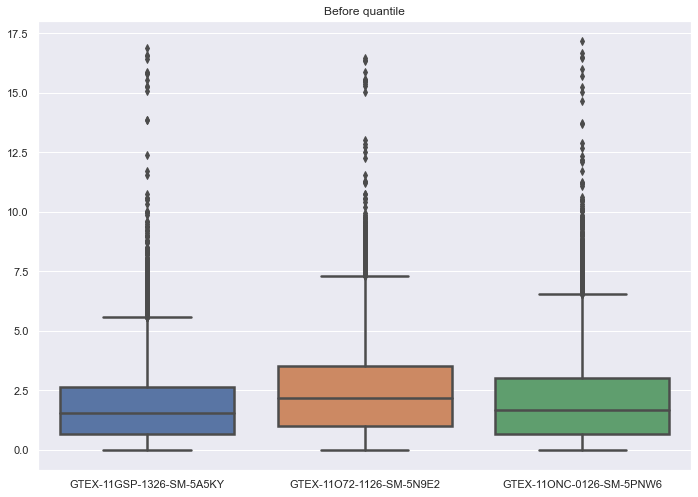

(14345, 119)


GTEX-11GSP-1326-SM-5A5KY  GTEX-11O72-1126-SM-5N9E2  \
Name                                                                    
ENSG00000186092.4                   0.00000                  0.183963   
ENSG00000278566.1                   0.12006                  0.155749   

                   GTEX-11ONC-0126-SM-5PNW6  
Name                                         
ENSG00000186092.4                  1.712816  
ENSG00000278566.1                  0.156785

df image after quantile normalization: (14345, 3)


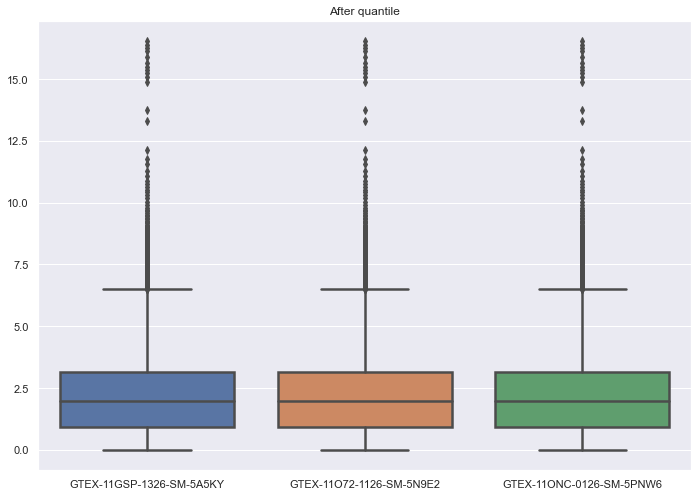

GTEX-11GSP-1326-SM-5A5KY  GTEX-11O72-1126-SM-5N9E2  \
Name                                                                    
ENSG00000186092.4                   0.00000                  0.182069   
ENSG00000278566.1                   0.16354                  0.154504   

                   GTEX-11ONC-0126-SM-5PNW6  
Name                                         
ENSG00000186092.4                  2.019778  
ENSG00000278566.1                  0.225640

(119, 8)
sample outliers
(18349, 116)


GTEX-11DXY-1426-SM-5N9CN  GTEX-11DYG-1326-SM-5N9DO  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.079184   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.076846                  0.000000   
ENSG00000187634.11                  2.062812                  2.476900   
ENSG00000188976.10                  5.870611                  6.556123   

                    GTEX-11EMC-2226-SM-5A5JW  GTEX-11EQ9-0726-SM-5A5K2  \
Name                                                                     
ENSG00000186092.4                   0.079702                  0.061624   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.077968                  0.118134   
ENSG00000187634.11                  1.426533                  0.800165   
ENSG00000188976.10                  6.744161                  6.131548   

                    GTEX-11GSP-1826-SM-5N9DQ  GTEX-11NUK-1326-SM-5P9GN  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.136388   
ENSG00000278566.1                   0.118094                  0.000000   
ENSG00000273547.1                   0.000000                  0.000000   
ENSG00000187634.11                  2.410884                  1.642933   
ENSG00000188976.10                  6.534030                  6.353500   

                    GTEX-11ONC-1526-SM-5GU6S  GTEX-11P82-0526-SM-5986P  \
Name                                                                     
ENSG00000186092.4                   0.979367                  0.127448   
ENSG00000278566.1                   0.137490                  0.063710   
ENSG00000273547.1                   0.000000                  0.063710   
ENSG00000187634.11                  2.014355                  1.012211   
ENSG00000188976.10                  6.054197                  5.713421   

                    GTEX-11TUW-1326-SM-5EQKV  GTEX-11ZTS-2626-SM-5EGIC  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.064786                  0.231924  ...   
ENSG00000278566.1                   0.000000                  0.000000  ...   
ENSG00000273547.1                   0.124077                  0.079743  ...   
ENSG00000187634.11                  2.335426                  1.844787  ...   
ENSG00000188976.10                  6.261531                  6.481880  ...   

                    GTEX-XQ3S-1126-SM-4BOPK  GTEX-Y111-1626-SM-57WCY  \
Name                                                                   
ENSG00000186092.4                  0.063862                 0.236217   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.179766                 0.000000   
ENSG00000187634.11                 2.018278                 1.424385   
ENSG00000188976.10                 7.010108                 6.654063   

                    GTEX-YFC4-1226-SM-5LU9R  GTEX-YJ89-1526-SM-5P9IR  \
Name                                                                   
ENSG00000186092.4                  0.083751                 0.124328   
ENSG00000278566.1                  0.081926                 0.000000   
ENSG00000273547.1                  0.081926                 0.041706   
ENSG00000187634.11                 1.010780                 1.807355   
ENSG00000188976.10                 6.076602                 5.945327   

                    GTEX-ZAK1-1526-SM-5S2OV  GTEX-ZE9C-1126-SM-4WWBD  \
Name                                                                   
ENSG00000186092.4                  0.079033                 0.052847   
ENSG00000278566.1                  0.000000                 0.051678   
ENSG00000273547.1                  0.000000                 0.101569   
ENSG00000187634.11  

SMRIN  SMTSISCH               SMTSD    SMGEBTCH  \
SAMPID                                                                      
GTEX-11DXY-1426-SM-5N9CN    9.1     920.0  Esophagus - Mucosa  LCSET-4904   
GTEX-11DYG-1326-SM-5N9DO    6.8     860.0  Esophagus - Mucosa  LCSET-4904   
GTEX-11EMC-2226-SM-5A5JW    8.3     740.0  Esophagus - Mucosa  LCSET-4423   
GTEX-11EQ9-0726-SM-5A5K2    9.4      93.0  Esophagus - Mucosa  LCSET-4423   
GTEX-11GSP-1826-SM-5N9DQ    7.2     786.0  Esophagus - Mucosa  LCSET-4904   

                              SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                     
GTEX-11DXY-1426-SM-5N9CN  GTEX-11DXY  1.0  60-69      2.0  
GTEX-11DYG-1326-SM-5N9DO  GTEX-11DYG  1.0  60-69      2.0  
GTEX-11EMC-2226-SM-5A5JW  GTEX-11EMC  2.0  60-69      2.0  
GTEX-11EQ9-0726-SM-5A5K2  GTEX-11EQ9  1.0  30-39      2.0  
GTEX-11GSP-1826-SM-5N9DQ  GTEX-11GSP  2.0  60-69      2.0

isna
GTEX-11DXY-1426-SM-5N9CN    0
GTEX-11DYG-1326-SM-5N9DO    0
GTEX-11EMC-2226-SM-5A5JW    0
GTEX-11EQ9-0726-SM-5A5K2    0
GTEX-11GSP-1826-SM-5N9DQ    0
                           ..
GTEX-ZE9C-1126-SM-4WWBD     0
GTEX-ZUA1-1226-SM-5NQ6O     0
GTEX-ZV68-0926-SM-59HK7     0
GTEX-ZYFC-1626-SM-5N9EU     0
GTEX-ZYT6-1126-SM-5GZYR     0
Length: 116, dtype: int64
GTEX-11DXY-1426-SM-5N9CN    0
GTEX-11DYG-1326-SM-5N9DO    0
GTEX-11EMC-2226-SM-5A5JW    0
GTEX-11EQ9-0726-SM-5A5K2    0
GTEX-11GSP-1826-SM-5N9DQ    0
                           ..
GTEX-ZE9C-1126-SM-4WWBD     0
GTEX-ZUA1-1226-SM-5NQ6O     0
GTEX-ZV68-0926-SM-59HK7     0
GTEX-ZYFC-1626-SM-5N9EU     0
GTEX-ZYT6-1126-SM-5GZYR     0
Length: 116, dtype: int64
wasna
removing outliers
(18349, 116)
<class 'numpy.ndarray'>
components shape
(116, 20)
['GTEX-11DXY-1426-SM-5N9CN', 'GTEX-11DYG-1326-SM-5N9DO', 'GTEX-11EMC-2226-SM-5A5JW', 'GTEX-11EQ9-0726-SM-5A5K2', 'GTEX-11GSP-1826-SM-5N9DQ', 'GTEX-11NUK-1326-SM-5P9GN', 'GTEX-11ONC-1526-SM-5GU6S'

GTEX-11DXY-1426-SM-5N9CN  GTEX-11DYG-1326-SM-5N9DO  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.079184   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.076846                  0.000000   
ENSG00000187634.11                  2.062812                  2.476900   
ENSG00000188976.10                  5.870611                  6.556123   

                    GTEX-11EMC-2226-SM-5A5JW  GTEX-11EQ9-0726-SM-5A5K2  \
Name                                                                     
ENSG00000186092.4                   0.079702                  0.061624   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.077968                  0.118134   
ENSG00000187634.11                  1.426533                  0.800165   
ENSG00000188976.10                  6.744161                  6.131548   

                    GTEX-11GSP-1826-SM-5N9DQ  GTEX-11NUK-1326-SM-5P9GN  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.136388   
ENSG00000278566.1                   0.118094                  0.000000   
ENSG00000273547.1                   0.000000                  0.000000   
ENSG00000187634.11                  2.410884                  1.642933   
ENSG00000188976.10                  6.534030                  6.353500   

                    GTEX-11ONC-1526-SM-5GU6S  GTEX-11P82-0526-SM-5986P  \
Name                                                                     
ENSG00000186092.4                   0.979367                  0.127448   
ENSG00000278566.1                   0.137490                  0.063710   
ENSG00000273547.1                   0.000000                  0.063710   
ENSG00000187634.11                  2.014355                  1.012211   
ENSG00000188976.10                  6.054197                  5.713421   

                    GTEX-11TUW-1326-SM-5EQKV  GTEX-11ZTS-2626-SM-5EGIC  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.064786                  0.231924  ...   
ENSG00000278566.1                   0.000000                  0.000000  ...   
ENSG00000273547.1                   0.124077                  0.079743  ...   
ENSG00000187634.11                  2.335426                  1.844787  ...   
ENSG00000188976.10                  6.261531                  6.481880  ...   

                    GTEX-XQ3S-1126-SM-4BOPK  GTEX-Y111-1626-SM-57WCY  \
Name                                                                   
ENSG00000186092.4                  0.063862                 0.236217   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.179766                 0.000000   
ENSG00000187634.11                 2.018278                 1.424385   
ENSG00000188976.10                 7.010108                 6.654063   

                    GTEX-YFC4-1226-SM-5LU9R  GTEX-YJ89-1526-SM-5P9IR  \
Name                                                                   
ENSG00000186092.4                  0.083751                 0.124328   
ENSG00000278566.1                  0.081926                 0.000000   
ENSG00000273547.1                  0.081926                 0.041706   
ENSG00000187634.11                 1.010780                 1.807355   
ENSG00000188976.10                 6.076602                 5.945327   

                    GTEX-ZAK1-1526-SM-5S2OV  GTEX-ZE9C-1126-SM-4WWBD  \
Name                                                                   
ENSG00000186092.4                  0.079033                 0.052847   
ENSG00000278566.1                  0.000000                 0.051678   
ENSG00000273547.1                  0.000000                 0.101569   
ENSG00000187634.11  

(18349, 116)


SMRIN  SMTSISCH               SMTSD    SMGEBTCH  \
SAMPID                                                                      
GTEX-11DXY-1426-SM-5N9CN    9.1     920.0  Esophagus - Mucosa  LCSET-4904   
GTEX-11DYG-1326-SM-5N9DO    6.8     860.0  Esophagus - Mucosa  LCSET-4904   
GTEX-11EMC-2226-SM-5A5JW    8.3     740.0  Esophagus - Mucosa  LCSET-4423   
GTEX-11EQ9-0726-SM-5A5K2    9.4      93.0  Esophagus - Mucosa  LCSET-4423   
GTEX-11GSP-1826-SM-5N9DQ    7.2     786.0  Esophagus - Mucosa  LCSET-4904   

                              SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                     
GTEX-11DXY-1426-SM-5N9CN  GTEX-11DXY  1.0  60-69      2.0  
GTEX-11DYG-1326-SM-5N9DO  GTEX-11DYG  1.0  60-69      2.0  
GTEX-11EMC-2226-SM-5A5JW  GTEX-11EMC  2.0  60-69      2.0  
GTEX-11EQ9-0726-SM-5A5K2  GTEX-11EQ9  1.0  30-39      2.0  
GTEX-11GSP-1826-SM-5N9DQ  GTEX-11GSP  2.0  60-69      2.0

(116, 8)
--- Index of Outliers ----
[63, 91]
<class 'list'>
2
63
91
['GTEX-11DXY-1426-SM-5N9CN', 'GTEX-11DYG-1326-SM-5N9DO']


0         1         2         3         4         5         6   \
0  0.090022  0.114886  0.010572  0.118160  0.052809 -0.067743  0.136514   
1  0.103015 -0.169223  0.113999 -0.023381  0.173681  0.316009  0.025533   
2  0.097576  0.016267  0.148450 -0.085704  0.004892 -0.075222 -0.018114   
3  0.091413  0.073337  0.053894 -0.026282  0.113401 -0.001477 -0.156219   
4  0.093208  0.024486 -0.025397  0.099824 -0.039189 -0.105731 -0.096213   

         7         8         9         10        11        12        13  \
0 -0.033854  0.036749  0.083158 -0.055538 -0.072386  0.025756  0.042430   
1  0.119653  0.114969  0.047562 -0.013671 -0.124559 -0.040980 -0.005204   
2  0.036000  0.132162  0.228337 -0.063497 -0.012943 -0.064008  0.070579   
3 -0.029436 -0.073773  0.036237  0.098644  0.148067 -0.256134  0.033850   
4  0.096278 -0.017106 -0.158900 -0.127260 -0.038757  0.021587 -0.050089   

         14        15        16        17        18        19  
0  0.016695  0.014183  0.149079  0.119696  0.097097 -0.031007  
1 -0.066095 -0.001032 -0.051484  0.115683  0.089919 -0.030656  
2  0.121796 -0.083205  0.042706  0.020785 -0.037624  0.111385  
3  0.064609  0.137968  0.190727 -0.077288 -0.040858  0.091833  
4 -0.018695 -0.216832 -0.039919  0.029589 -0.145691  0.135550

dropping outliers
matrix shape before drop
(18349, 116)
matrix shape after drop
(18349, 114)
sample shape before drop
(116, 8)
sample shape after drop
(114, 8)
Name
ENSG00000186092.4     0.030140
ENSG00000278566.1     0.015410
ENSG00000273547.1     0.007814
ENSG00000187634.11    0.419150
ENSG00000188976.10    0.201891
                        ...   
ENSG00000212907.2     0.482809
ENSG00000198886.2     0.466140
ENSG00000198786.2     0.409596
ENSG00000198695.2     0.576908
ENSG00000198727.2     0.619795
Length: 18349, dtype: float64
length of excluded list
2908
df image before quantile normalization: (15441, 3)


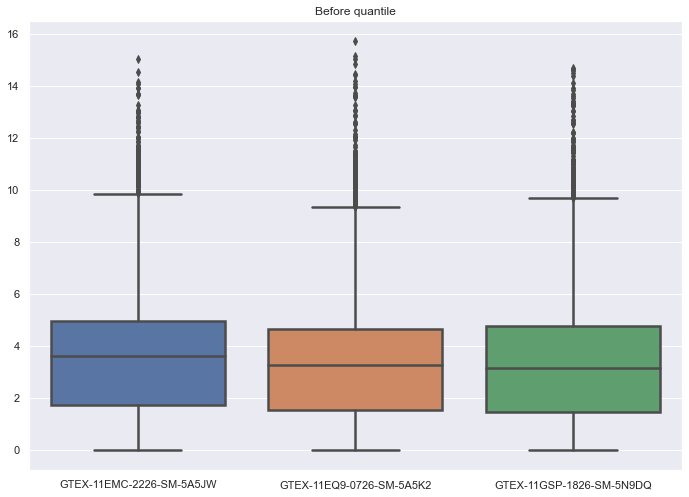

(15441, 114)


GTEX-11EMC-2226-SM-5A5JW  GTEX-11EQ9-0726-SM-5A5K2  \
Name                                                                     
ENSG00000186092.4                   0.079702                  0.061624   
ENSG00000187634.11                  1.426533                  0.800165   

                    GTEX-11GSP-1826-SM-5N9DQ  
Name                                          
ENSG00000186092.4                   0.000000  
ENSG00000187634.11                  2.410884

df image after quantile normalization: (15441, 3)


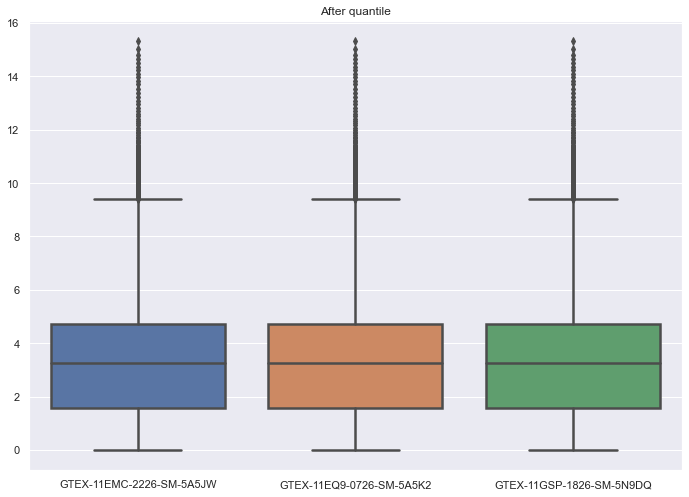

GTEX-11EMC-2226-SM-5A5JW  GTEX-11EQ9-0726-SM-5A5K2  \
Name                                                                     
ENSG00000186092.4                   0.063173                  0.048181   
ENSG00000187634.11                  1.312856                  0.839841   

                    GTEX-11GSP-1826-SM-5N9DQ  
Name                                          
ENSG00000186092.4                   0.000000  
ENSG00000187634.11                  2.524049

(114, 8)
sample outliers
(18349, 106)


GTEX-1128S-0326-SM-5GZZF  GTEX-117XS-0426-SM-5GZZN  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.085098                  0.077845   
ENSG00000273547.1                   0.165430                  0.000000   
ENSG00000187634.11                  2.502840                  2.682124   
ENSG00000188976.10                  5.834155                  5.793636   

                    GTEX-11DYG-1226-SM-5N9DC  GTEX-11EMC-0926-SM-59863  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.083370   
ENSG00000278566.1                   0.000000                  0.081558   
ENSG00000273547.1                   0.000000                  0.000000   
ENSG00000187634.11                  2.536799                  3.263786   
ENSG00000188976.10                  5.545660                  5.796753   

                    GTEX-11GS4-0326-SM-5N9F7  GTEX-11GSP-1126-SM-5A5LM  \
Name                                                                     
ENSG00000186092.4                   0.151209                  0.096586   
ENSG00000278566.1                   0.075889                  0.000000   
ENSG00000273547.1                   0.147958                  0.094493   
ENSG00000187634.11                  4.769243                  3.223886   
ENSG00000188976.10                  5.525129                  5.632850   

                    GTEX-11NUK-0726-SM-5A5ME  GTEX-11ONC-0926-SM-5BC5E  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.073998                  0.083397   
ENSG00000273547.1                   0.000000                  0.162210   
ENSG00000187634.11                  3.114034                  2.001802   
ENSG00000188976.10                  5.733354                  5.544424   

                    GTEX-11P82-0126-SM-5HL72  GTEX-11TUW-0926-SM-5EQMW  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.000000                  0.182057  ...   
ENSG00000278566.1                   0.077339                  0.000000  ...   
ENSG00000273547.1                   0.000000                  0.000000  ...   
ENSG00000187634.11                  2.022900                  0.920217  ...   
ENSG00000188976.10                  5.537296                  6.468420  ...   

                    GTEX-WRHU-1326-SM-4E3K7  GTEX-WZTO-1626-SM-4PQYR  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.000000   
ENSG00000278566.1                  0.137464                 0.109414   
ENSG00000273547.1                  0.201634                 0.109414   
ENSG00000187634.11                 4.379898                 2.661294   
ENSG00000188976.10                 5.897482                 6.040016   

                    GTEX-XQ3S-0126-SM-4BOO9  GTEX-YFC4-0326-SM-4TT3U  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.064593   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.000000                 0.063172   
ENSG00000187634.11                 3.806324                 4.037382   
ENSG00000188976.10                 6.100978                 5.206721   

                    GTEX-YJ8O-0226-SM-5S2NL  GTEX-ZAK1-1226-SM-5Q5AA  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.000000   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.000000                 0.000000   
ENSG00000187634.11  

SMRIN  SMTSISCH           SMTSD    SMGEBTCH  \
SAMPID                                                                  
GTEX-1128S-0326-SM-5GZZF    6.0     828.0  Artery - Aorta  LCSET-4805   
GTEX-117XS-0426-SM-5GZZN    6.6     857.0  Artery - Aorta  LCSET-4805   
GTEX-11DYG-1226-SM-5N9DC    6.7     858.0  Artery - Aorta  LCSET-4904   
GTEX-11EMC-0926-SM-59863    5.9     715.0  Artery - Aorta  LCSET-4417   
GTEX-11GS4-0326-SM-5N9F7    5.7     795.0  Artery - Aorta  LCSET-4905   

                              SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                     
GTEX-1128S-0326-SM-5GZZF  GTEX-1128S  2.0  60-69      2.0  
GTEX-117XS-0426-SM-5GZZN  GTEX-117XS  1.0  60-69      2.0  
GTEX-11DYG-1226-SM-5N9DC  GTEX-11DYG  1.0  60-69      2.0  
GTEX-11EMC-0926-SM-59863  GTEX-11EMC  2.0  60-69      2.0  
GTEX-11GS4-0326-SM-5N9F7  GTEX-11GS4  1.0  60-69      2.0

isna
GTEX-1128S-0326-SM-5GZZF    0
GTEX-117XS-0426-SM-5GZZN    0
GTEX-11DYG-1226-SM-5N9DC    0
GTEX-11EMC-0926-SM-59863    0
GTEX-11GS4-0326-SM-5N9F7    0
                           ..
GTEX-ZAK1-1226-SM-5Q5AA     0
GTEX-ZDTS-1426-SM-5K7WC     0
GTEX-ZDXO-2726-SM-4WKFA     0
GTEX-ZE9C-0726-SM-4WKGA     0
GTEX-ZYT6-1026-SM-DKPOV     0
Length: 106, dtype: int64
GTEX-1128S-0326-SM-5GZZF    0
GTEX-117XS-0426-SM-5GZZN    0
GTEX-11DYG-1226-SM-5N9DC    0
GTEX-11EMC-0926-SM-59863    0
GTEX-11GS4-0326-SM-5N9F7    0
                           ..
GTEX-ZAK1-1226-SM-5Q5AA     0
GTEX-ZDTS-1426-SM-5K7WC     0
GTEX-ZDXO-2726-SM-4WKFA     0
GTEX-ZE9C-0726-SM-4WKGA     0
GTEX-ZYT6-1026-SM-DKPOV     0
Length: 106, dtype: int64
wasna
removing outliers
(18349, 106)
<class 'numpy.ndarray'>
components shape
(106, 20)
['GTEX-1128S-0326-SM-5GZZF', 'GTEX-117XS-0426-SM-5GZZN', 'GTEX-11DYG-1226-SM-5N9DC', 'GTEX-11EMC-0926-SM-59863', 'GTEX-11GS4-0326-SM-5N9F7', 'GTEX-11GSP-1126-SM-5A5LM', 'GTEX-11NUK-0726-SM-5A5ME'

GTEX-1128S-0326-SM-5GZZF  GTEX-117XS-0426-SM-5GZZN  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.085098                  0.077845   
ENSG00000273547.1                   0.165430                  0.000000   
ENSG00000187634.11                  2.502840                  2.682124   
ENSG00000188976.10                  5.834155                  5.793636   

                    GTEX-11DYG-1226-SM-5N9DC  GTEX-11EMC-0926-SM-59863  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.083370   
ENSG00000278566.1                   0.000000                  0.081558   
ENSG00000273547.1                   0.000000                  0.000000   
ENSG00000187634.11                  2.536799                  3.263786   
ENSG00000188976.10                  5.545660                  5.796753   

                    GTEX-11GS4-0326-SM-5N9F7  GTEX-11GSP-1126-SM-5A5LM  \
Name                                                                     
ENSG00000186092.4                   0.151209                  0.096586   
ENSG00000278566.1                   0.075889                  0.000000   
ENSG00000273547.1                   0.147958                  0.094493   
ENSG00000187634.11                  4.769243                  3.223886   
ENSG00000188976.10                  5.525129                  5.632850   

                    GTEX-11NUK-0726-SM-5A5ME  GTEX-11ONC-0926-SM-5BC5E  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.000000   
ENSG00000278566.1                   0.073998                  0.083397   
ENSG00000273547.1                   0.000000                  0.162210   
ENSG00000187634.11                  3.114034                  2.001802   
ENSG00000188976.10                  5.733354                  5.544424   

                    GTEX-11P82-0126-SM-5HL72  GTEX-11TUW-0926-SM-5EQMW  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.000000                  0.182057  ...   
ENSG00000278566.1                   0.077339                  0.000000  ...   
ENSG00000273547.1                   0.000000                  0.000000  ...   
ENSG00000187634.11                  2.022900                  0.920217  ...   
ENSG00000188976.10                  5.537296                  6.468420  ...   

                    GTEX-WRHU-1326-SM-4E3K7  GTEX-WZTO-1626-SM-4PQYR  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.000000   
ENSG00000278566.1                  0.137464                 0.109414   
ENSG00000273547.1                  0.201634                 0.109414   
ENSG00000187634.11                 4.379898                 2.661294   
ENSG00000188976.10                 5.897482                 6.040016   

                    GTEX-XQ3S-0126-SM-4BOO9  GTEX-YFC4-0326-SM-4TT3U  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.064593   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.000000                 0.063172   
ENSG00000187634.11                 3.806324                 4.037382   
ENSG00000188976.10                 6.100978                 5.206721   

                    GTEX-YJ8O-0226-SM-5S2NL  GTEX-ZAK1-1226-SM-5Q5AA  \
Name                                                                   
ENSG00000186092.4                  0.000000                 0.000000   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.000000                 0.000000   
ENSG00000187634.11  

(18349, 106)


SMRIN  SMTSISCH           SMTSD    SMGEBTCH  \
SAMPID                                                                  
GTEX-1128S-0326-SM-5GZZF    6.0     828.0  Artery - Aorta  LCSET-4805   
GTEX-117XS-0426-SM-5GZZN    6.6     857.0  Artery - Aorta  LCSET-4805   
GTEX-11DYG-1226-SM-5N9DC    6.7     858.0  Artery - Aorta  LCSET-4904   
GTEX-11EMC-0926-SM-59863    5.9     715.0  Artery - Aorta  LCSET-4417   
GTEX-11GS4-0326-SM-5N9F7    5.7     795.0  Artery - Aorta  LCSET-4905   

                              SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                     
GTEX-1128S-0326-SM-5GZZF  GTEX-1128S  2.0  60-69      2.0  
GTEX-117XS-0426-SM-5GZZN  GTEX-117XS  1.0  60-69      2.0  
GTEX-11DYG-1226-SM-5N9DC  GTEX-11DYG  1.0  60-69      2.0  
GTEX-11EMC-0926-SM-59863  GTEX-11EMC  2.0  60-69      2.0  
GTEX-11GS4-0326-SM-5N9F7  GTEX-11GS4  1.0  60-69      2.0

(106, 8)
--- Index of Outliers ----
[]
<class 'list'>
0
[]


0         1         2         3         4         5         6   \
0  0.098654  0.030288 -0.015711 -0.105274  0.010750 -0.040107 -0.161578   
1  0.094333 -0.162839  0.149122 -0.169257 -0.069398 -0.027894  0.066363   
2  0.097496 -0.002624  0.017424  0.057069 -0.042315  0.062772  0.111740   
3  0.097443  0.123786 -0.043941 -0.045858 -0.069387  0.049964 -0.130089   
4  0.095570  0.026150  0.010649 -0.175420  0.073873  0.173105  0.128478   

         7         8         9         10        11        12        13  \
0 -0.028214  0.076043 -0.118007 -0.205444  0.178753  0.008415  0.155738   
1 -0.061372 -0.010599  0.039860 -0.074427  0.008947  0.132071  0.052247   
2 -0.048829 -0.019512  0.029313  0.105684 -0.143146 -0.044470  0.057235   
3 -0.037257  0.155730 -0.078757 -0.103162  0.055150 -0.044717  0.059572   
4  0.060374 -0.111518  0.019485  0.093882  0.019987  0.210625  0.250364   

         14        15        16        17        18        19  
0  0.152306 -0.073115  0.144457 -0.107576 -0.186763  0.069034  
1  0.007996 -0.033107 -0.018284 -0.102402  0.015496 -0.046853  
2  0.055478  0.164657  0.262903 -0.080067 -0.078576 -0.106598  
3  0.063051 -0.022818  0.114729 -0.108974 -0.054183  0.035549  
4  0.197476 -0.199815  0.094662  0.012516 -0.149296  0.077568

dropping outliers
matrix shape before drop
(18349, 106)
matrix shape after drop
(18349, 106)
sample shape before drop
(106, 8)
sample shape after drop
(106, 8)
Name
ENSG00000186092.4     0.006492
ENSG00000278566.1     0.007517
ENSG00000273547.1     0.003943
ENSG00000187634.11    1.233016
ENSG00000188976.10    0.054228
                        ...   
ENSG00000212907.2     0.481427
ENSG00000198886.2     0.355487
ENSG00000198786.2     0.478763
ENSG00000198695.2     0.856577
ENSG00000198727.2     0.285155
Length: 18349, dtype: float64
length of excluded list
3025
df image before quantile normalization: (15324, 3)


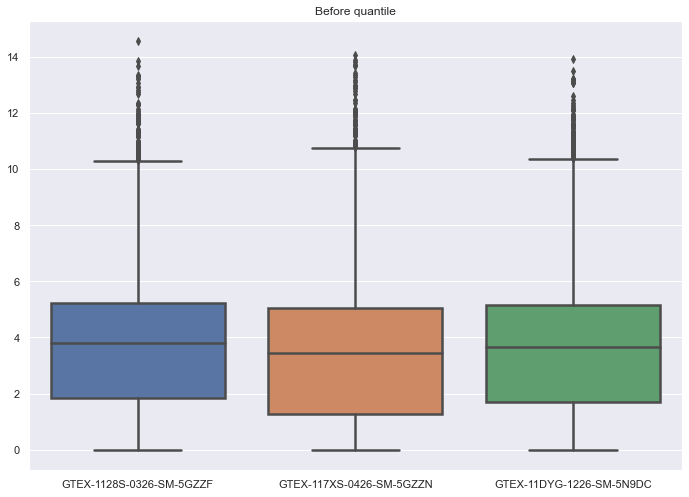

(15324, 106)


GTEX-1128S-0326-SM-5GZZF  GTEX-117XS-0426-SM-5GZZN  \
Name                                                                     
ENSG00000187634.11                  2.502840                  2.682124   
ENSG00000188976.10                  5.834155                  5.793636   

                    GTEX-11DYG-1226-SM-5N9DC  
Name                                          
ENSG00000187634.11                  2.536799  
ENSG00000188976.10                  5.545660

df image after quantile normalization: (15324, 3)


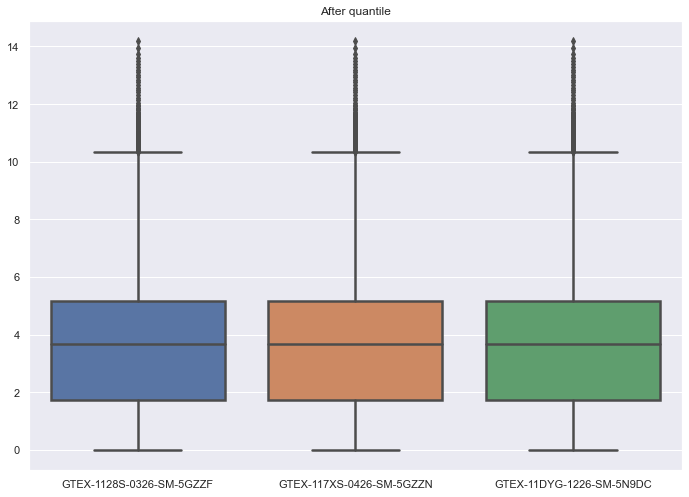

GTEX-1128S-0326-SM-5GZZF  GTEX-117XS-0426-SM-5GZZN  \
Name                                                                     
ENSG00000187634.11                  2.362973                  3.019154   
ENSG00000188976.10                  5.764663                  5.839115   

                    GTEX-11DYG-1226-SM-5N9DC  
Name                                          
ENSG00000187634.11                  2.585602  
ENSG00000188976.10                  5.530359

(106, 8)
sample outliers
(18349, 106)


GTEX-11DXY-0526-SM-5EGGQ  GTEX-11EQ9-0526-SM-5A5JZ  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.045401   
ENSG00000278566.1                   0.000000                  0.044408   
ENSG00000273547.1                   0.044128                  0.087476   
ENSG00000187634.11                  1.002162                  2.630638   
ENSG00000188976.10                  4.465974                  5.360715   

                    GTEX-11GSP-0626-SM-5986T  GTEX-11NUK-1226-SM-5P9GM  \
Name                                                                     
ENSG00000186092.4                   0.182946                  0.163370   
ENSG00000278566.1                   0.046910                  0.129296   
ENSG00000273547.1                   0.092343                  0.000000   
ENSG00000187634.11                  2.245191                  0.710437   
ENSG00000188976.10                  4.034744                  4.329124   

                    GTEX-11NV4-1326-SM-5HL6V  GTEX-11OF3-0726-SM-5BC4Z  \
Name                                                                     
ENSG00000186092.4                   0.073052                  0.181166   
ENSG00000278566.1                   0.036173                  0.120644   
ENSG00000273547.1                   0.000000                  0.177344   
ENSG00000187634.11                  0.814099                  1.357833   
ENSG00000188976.10                  4.813525                  4.314697   

                    GTEX-11TUW-1726-SM-5BC5C  GTEX-11WQC-0726-SM-5EQMR  \
Name                                                                     
ENSG00000186092.4                   0.097166                  0.098851   
ENSG00000278566.1                   0.095060                  0.142740   
ENSG00000273547.1                   0.140386                  0.142740   
ENSG00000187634.11                  0.951439                  1.741143   
ENSG00000188976.10                  5.756223                  4.607626   

                    GTEX-11ZTS-1426-SM-5EQMM  GTEX-11ZUS-2526-SM-59872  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.027338                  0.157820  ...   
ENSG00000278566.1                   0.052986                  0.117389  ...   
ENSG00000273547.1                   0.026743                  0.225892  ...   
ENSG00000187634.11                  1.845992                  0.858458  ...   
ENSG00000188976.10                  4.417515                  4.025915  ...   

                    GTEX-SJXC-1226-SM-4DM78  GTEX-T6MN-1226-SM-3NMA5  \
Name                                                                   
ENSG00000186092.4                  0.090000                 0.215616   
ENSG00000278566.1                  0.171079                 0.073848   
ENSG00000273547.1                  0.210763                 0.109401   
ENSG00000187634.11                 1.216610                 1.666302   
ENSG00000188976.10                 4.621759                 4.727920   

                    GTEX-WK11-1326-SM-4OOSI  GTEX-WVLH-2126-SM-EYYWD  \
Name                                                                   
ENSG00000186092.4                  0.059217                 0.078282   
ENSG00000278566.1                  0.086023                 0.218471   
ENSG00000273547.1                  0.048418                 0.149259   
ENSG00000187634.11                 1.901881                 1.087463   
ENSG00000188976.10                 3.345396                 4.156235   

                    GTEX-WZTO-0626-SM-4PQYY  GTEX-XBEC-1526-SM-4AT68  \
Name                                                                   
ENSG00000186092.4                  0.166201                 0.054779   
ENSG00000278566.1                  0.213005                 0.105236   
ENSG00000273547.1                  0.056278                 0.053570   
ENSG00000187634.11  

SMRIN  SMTSISCH  SMTSD               SMGEBTCH  \
SAMPID                                                                    
GTEX-11DXY-0526-SM-5EGGQ    6.8     891.0  Liver  LCSET-4764,LCSET-5055   
GTEX-11EQ9-0526-SM-5A5JZ    8.1      82.0  Liver             LCSET-4423   
GTEX-11GSP-0626-SM-5986T    6.2     771.0  Liver             LCSET-4417   
GTEX-11NUK-1226-SM-5P9GM    6.1     956.0  Liver             LCSET-4914   
GTEX-11NV4-1326-SM-5HL6V    5.9    1152.0  Liver             LCSET-4806   

                              SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                     
GTEX-11DXY-0526-SM-5EGGQ  GTEX-11DXY  1.0  60-69      2.0  
GTEX-11EQ9-0526-SM-5A5JZ  GTEX-11EQ9  1.0  30-39      2.0  
GTEX-11GSP-0626-SM-5986T  GTEX-11GSP  2.0  60-69      2.0  
GTEX-11NUK-1226-SM-5P9GM  GTEX-11NUK  1.0  50-59      2.0  
GTEX-11NV4-1326-SM-5HL6V  GTEX-11NV4  1.0  60-69      2.0

isna
GTEX-11DXY-0526-SM-5EGGQ    0
GTEX-11EQ9-0526-SM-5A5JZ    0
GTEX-11GSP-0626-SM-5986T    0
GTEX-11NUK-1226-SM-5P9GM    0
GTEX-11NV4-1326-SM-5HL6V    0
                           ..
GTEX-XBEC-1526-SM-4AT68     0
GTEX-Y111-0726-SM-EYYVM     0
GTEX-YFC4-1526-SM-5IFJS     0
GTEX-ZVT3-1626-SM-5GU66     0
GTEX-ZYT6-0626-SM-5E45V     0
Length: 106, dtype: int64
GTEX-11DXY-0526-SM-5EGGQ    0
GTEX-11EQ9-0526-SM-5A5JZ    0
GTEX-11GSP-0626-SM-5986T    0
GTEX-11NUK-1226-SM-5P9GM    0
GTEX-11NV4-1326-SM-5HL6V    0
                           ..
GTEX-XBEC-1526-SM-4AT68     0
GTEX-Y111-0726-SM-EYYVM     0
GTEX-YFC4-1526-SM-5IFJS     0
GTEX-ZVT3-1626-SM-5GU66     0
GTEX-ZYT6-0626-SM-5E45V     0
Length: 106, dtype: int64
wasna
removing outliers
(18349, 106)
<class 'numpy.ndarray'>
components shape
(106, 20)
['GTEX-11DXY-0526-SM-5EGGQ', 'GTEX-11EQ9-0526-SM-5A5JZ', 'GTEX-11GSP-0626-SM-5986T', 'GTEX-11NUK-1226-SM-5P9GM', 'GTEX-11NV4-1326-SM-5HL6V', 'GTEX-11OF3-0726-SM-5BC4Z', 'GTEX-11TUW-1726-SM-5BC5C'

GTEX-11DXY-0526-SM-5EGGQ  GTEX-11EQ9-0526-SM-5A5JZ  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.045401   
ENSG00000278566.1                   0.000000                  0.044408   
ENSG00000273547.1                   0.044128                  0.087476   
ENSG00000187634.11                  1.002162                  2.630638   
ENSG00000188976.10                  4.465974                  5.360715   

                    GTEX-11GSP-0626-SM-5986T  GTEX-11NUK-1226-SM-5P9GM  \
Name                                                                     
ENSG00000186092.4                   0.182946                  0.163370   
ENSG00000278566.1                   0.046910                  0.129296   
ENSG00000273547.1                   0.092343                  0.000000   
ENSG00000187634.11                  2.245191                  0.710437   
ENSG00000188976.10                  4.034744                  4.329124   

                    GTEX-11NV4-1326-SM-5HL6V  GTEX-11OF3-0726-SM-5BC4Z  \
Name                                                                     
ENSG00000186092.4                   0.073052                  0.181166   
ENSG00000278566.1                   0.036173                  0.120644   
ENSG00000273547.1                   0.000000                  0.177344   
ENSG00000187634.11                  0.814099                  1.357833   
ENSG00000188976.10                  4.813525                  4.314697   

                    GTEX-11TUW-1726-SM-5BC5C  GTEX-11WQC-0726-SM-5EQMR  \
Name                                                                     
ENSG00000186092.4                   0.097166                  0.098851   
ENSG00000278566.1                   0.095060                  0.142740   
ENSG00000273547.1                   0.140386                  0.142740   
ENSG00000187634.11                  0.951439                  1.741143   
ENSG00000188976.10                  5.756223                  4.607626   

                    GTEX-11ZTS-1426-SM-5EQMM  GTEX-11ZUS-2526-SM-59872  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.027338                  0.157820  ...   
ENSG00000278566.1                   0.052986                  0.117389  ...   
ENSG00000273547.1                   0.026743                  0.225892  ...   
ENSG00000187634.11                  1.845992                  0.858458  ...   
ENSG00000188976.10                  4.417515                  4.025915  ...   

                    GTEX-SJXC-1226-SM-4DM78  GTEX-T6MN-1226-SM-3NMA5  \
Name                                                                   
ENSG00000186092.4                  0.090000                 0.215616   
ENSG00000278566.1                  0.171079                 0.073848   
ENSG00000273547.1                  0.210763                 0.109401   
ENSG00000187634.11                 1.216610                 1.666302   
ENSG00000188976.10                 4.621759                 4.727920   

                    GTEX-WK11-1326-SM-4OOSI  GTEX-WVLH-2126-SM-EYYWD  \
Name                                                                   
ENSG00000186092.4                  0.059217                 0.078282   
ENSG00000278566.1                  0.086023                 0.218471   
ENSG00000273547.1                  0.048418                 0.149259   
ENSG00000187634.11                 1.901881                 1.087463   
ENSG00000188976.10                 3.345396                 4.156235   

                    GTEX-WZTO-0626-SM-4PQYY  GTEX-XBEC-1526-SM-4AT68  \
Name                                                                   
ENSG00000186092.4                  0.166201                 0.054779   
ENSG00000278566.1                  0.213005                 0.105236   
ENSG00000273547.1                  0.056278                 0.053570   
ENSG00000187634.11  

(18349, 106)


SMRIN  SMTSISCH  SMTSD               SMGEBTCH  \
SAMPID                                                                    
GTEX-11DXY-0526-SM-5EGGQ    6.8     891.0  Liver  LCSET-4764,LCSET-5055   
GTEX-11EQ9-0526-SM-5A5JZ    8.1      82.0  Liver             LCSET-4423   
GTEX-11GSP-0626-SM-5986T    6.2     771.0  Liver             LCSET-4417   
GTEX-11NUK-1226-SM-5P9GM    6.1     956.0  Liver             LCSET-4914   
GTEX-11NV4-1326-SM-5HL6V    5.9    1152.0  Liver             LCSET-4806   

                              SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                     
GTEX-11DXY-0526-SM-5EGGQ  GTEX-11DXY  1.0  60-69      2.0  
GTEX-11EQ9-0526-SM-5A5JZ  GTEX-11EQ9  1.0  30-39      2.0  
GTEX-11GSP-0626-SM-5986T  GTEX-11GSP  2.0  60-69      2.0  
GTEX-11NUK-1226-SM-5P9GM  GTEX-11NUK  1.0  50-59      2.0  
GTEX-11NV4-1326-SM-5HL6V  GTEX-11NV4  1.0  60-69      2.0

(106, 8)
--- Index of Outliers ----
[27]
<class 'list'>
1
27
['GTEX-11DXY-0526-SM-5EGGQ']


0         1         2         3         4         5         6   \
0  0.094616 -0.100963 -0.090596 -0.035385 -0.047055  0.004145 -0.004262   
1  0.105153  0.110657  0.067289 -0.122841 -0.199584  0.020249  0.191096   
2  0.089545  0.002857  0.121505  0.169543  0.093629 -0.082763 -0.079064   
3  0.094634 -0.108006 -0.013833  0.061432  0.026103 -0.035374 -0.132215   
4  0.094864 -0.091066 -0.052402 -0.013415  0.027355 -0.078966 -0.013460   

         7         8         9         10        11        12        13  \
0 -0.047811  0.053232 -0.060214 -0.068695  0.015086  0.011525 -0.064889   
1 -0.086929  0.123685 -0.128427 -0.017299  0.042306  0.158356 -0.191227   
2  0.072822  0.027970  0.170619 -0.221501 -0.013429 -0.020141  0.028655   
3 -0.055424  0.043831  0.016211 -0.075531  0.006817  0.137751  0.029046   
4 -0.016214 -0.060273  0.103573  0.047845  0.009668 -0.032146 -0.201223   

         14        15        16        17        18        19  
0  0.081382  0.166763 -0.095932 -0.058421  0.028291 -0.137217  
1  0.055817 -0.171111 -0.039923 -0.170765 -0.220207  0.032581  
2  0.008520 -0.053994 -0.053661 -0.127680  0.028039 -0.160917  
3 -0.024202  0.064254 -0.002339  0.110323  0.016210 -0.003708  
4  0.071457  0.012337  0.002658 -0.011448  0.031817  0.034511

dropping outliers
matrix shape before drop
(18349, 106)
matrix shape after drop
(18349, 105)
sample shape before drop
(106, 8)
sample shape after drop
(105, 8)
Name
ENSG00000186092.4     0.083758
ENSG00000278566.1     0.035926
ENSG00000273547.1     0.010702
ENSG00000187634.11    0.325655
ENSG00000188976.10    0.295465
                        ...   
ENSG00000212907.2     0.229569
ENSG00000198886.2     0.186811
ENSG00000198786.2     0.352610
ENSG00000198695.2     0.548206
ENSG00000198727.2     0.201569
Length: 18349, dtype: float64
length of excluded list
3893
df image before quantile normalization: (14456, 3)


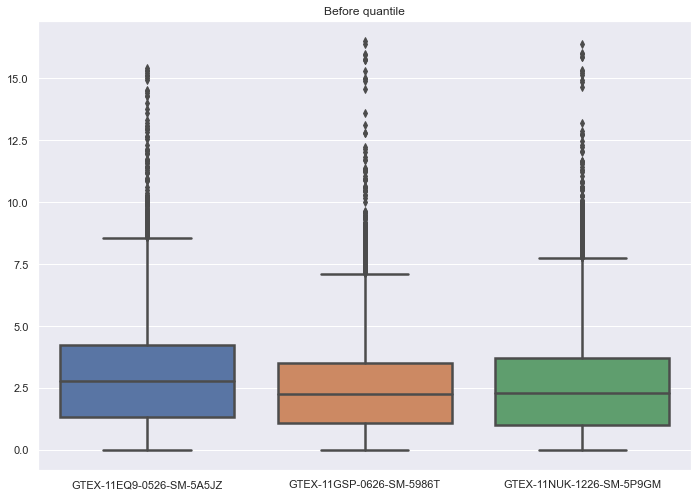

(14456, 105)


GTEX-11EQ9-0526-SM-5A5JZ  GTEX-11GSP-0626-SM-5986T  \
Name                                                                    
ENSG00000186092.4                  0.045401                  0.182946   
ENSG00000278566.1                  0.044408                  0.046910   

                   GTEX-11NUK-1226-SM-5P9GM  
Name                                         
ENSG00000186092.4                  0.163370  
ENSG00000278566.1                  0.129296

df image after quantile normalization: (14456, 3)


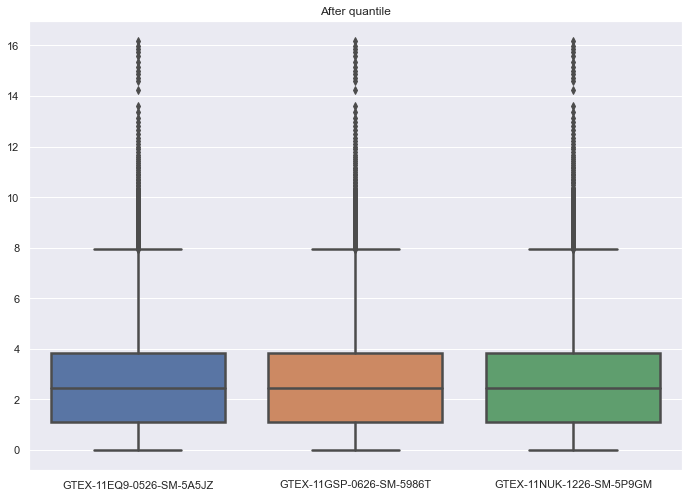

GTEX-11EQ9-0526-SM-5A5JZ  GTEX-11GSP-0626-SM-5986T  \
Name                                                                    
ENSG00000186092.4                  0.037080                  0.163226   
ENSG00000278566.1                  0.034936                  0.030642   

                   GTEX-11NUK-1226-SM-5P9GM  
Name                                         
ENSG00000186092.4                  0.183845  
ENSG00000278566.1                  0.145624

(105, 8)
sample outliers
(18349, 98)


GTEX-113JC-0926-SM-5H114  GTEX-11DXY-1526-SM-5H129  \
Name                                                                     
ENSG00000186092.4                   0.080521                  0.000000   
ENSG00000278566.1                   0.000000                  0.168000   
ENSG00000273547.1                   0.000000                  0.000000   
ENSG00000187634.11                  3.009526                  3.708187   
ENSG00000188976.10                  5.275752                  5.812241   

                    GTEX-11DYG-1426-SM-5A5JR  GTEX-11EQ9-0826-SM-5986Y  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.133932   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.155620                  0.000000   
ENSG00000187634.11                  3.259574                  2.222186   
ENSG00000188976.10                  5.744161                  5.839708   

                    GTEX-11GS4-1426-SM-5N9D2  GTEX-11GSP-1726-SM-5A5LI  \
Name                                                                     
ENSG00000186092.4                   0.208642                  0.000000   
ENSG00000278566.1                   0.165687                  0.000000   
ENSG00000273547.1                   0.085193                  0.000000   
ENSG00000187634.11                  2.563890                  3.917432   
ENSG00000188976.10                  4.505256                  5.526695   

                    GTEX-11NUK-1426-SM-5HL68  GTEX-11O72-1926-SM-5PNW1  \
Name                                                                     
ENSG00000186092.4                   0.051358                  0.075847   
ENSG00000278566.1                   0.098756                  0.212009   
ENSG00000273547.1                   0.000000                  0.000000   
ENSG00000187634.11                  1.910733                  2.959028   
ENSG00000188976.10                  4.572890                  5.546894   

                    GTEX-11OF3-2226-SM-5986F  GTEX-11ONC-1426-SM-5N9F4  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.115300                  0.310805  ...   
ENSG00000278566.1                   0.217479                  0.138421  ...   
ENSG00000273547.1                   0.266996                  0.000000  ...   
ENSG00000187634.11                  2.511721                  3.157205  ...   
ENSG00000188976.10                  4.581351                  5.005849  ...   

                    GTEX-SJXC-1526-SM-EZ6L5  GTEX-T2IS-0926-SM-4DM5B  \
Name                                                                   
ENSG00000186092.4                  0.048013                 0.000000   
ENSG00000278566.1                  0.046952                 0.000000   
ENSG00000273547.1                  0.000000                 0.133761   
ENSG00000187634.11                 2.521553                 2.737687   
ENSG00000188976.10                 5.385086                 5.549669   

                    GTEX-T5JC-1826-SM-4DM6E  GTEX-T6MN-1526-SM-4DM5P  \
Name                                                                   
ENSG00000186092.4                  0.174918                 0.083642   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.000000                 0.000000   
ENSG00000187634.11                 2.936402                 3.159791   
ENSG00000188976.10                 5.345893                 5.726286   

                    GTEX-WK11-1126-SM-4OOSJ  GTEX-WZTO-1526-SM-4PQYQ  \
Name                                                                   
ENSG00000186092.4                  0.052652                 0.158983   
ENSG00000278566.1                  0.025978                 0.155620   
ENSG00000273547.1                  0.051497                 0.000000   
ENSG00000187634.11  

SMRIN  SMTSISCH                   SMTSD    SMGEBTCH  \
SAMPID                                                                          
GTEX-113JC-0926-SM-5H114    5.8     645.0  Esophagus - Muscularis  LCSET-4805   
GTEX-11DXY-1526-SM-5H129    6.7     921.0  Esophagus - Muscularis  LCSET-4805   
GTEX-11DYG-1426-SM-5A5JR    5.9     861.0  Esophagus - Muscularis  LCSET-4423   
GTEX-11EQ9-0826-SM-5986Y    8.2      96.0  Esophagus - Muscularis  LCSET-4417   
GTEX-11GS4-1426-SM-5N9D2    5.8     829.0  Esophagus - Muscularis  LCSET-4904   

                              SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                     
GTEX-113JC-0926-SM-5H114  GTEX-113JC  2.0  50-59      2.0  
GTEX-11DXY-1526-SM-5H129  GTEX-11DXY  1.0  60-69      2.0  
GTEX-11DYG-1426-SM-5A5JR  GTEX-11DYG  1.0  60-69      2.0  
GTEX-11EQ9-0826-SM-5986Y  GTEX-11EQ9  1.0  30-39      2.0  
GTEX-11GS4-1426-SM-5N9D2  GTEX-11GS4  1.0  60-69      2.0

isna
GTEX-113JC-0926-SM-5H114    0
GTEX-11DXY-1526-SM-5H129    0
GTEX-11DYG-1426-SM-5A5JR    0
GTEX-11EQ9-0826-SM-5986Y    0
GTEX-11GS4-1426-SM-5N9D2    0
                           ..
GTEX-WZTO-1526-SM-4PQYQ     0
GTEX-XQ3S-1226-SM-4BOPP     0
GTEX-Y111-1726-SM-4SOIQ     0
GTEX-ZYFC-1726-SM-5GZYX     0
GTEX-ZYT6-1226-SM-5E44Q     0
Length: 98, dtype: int64
GTEX-113JC-0926-SM-5H114    0
GTEX-11DXY-1526-SM-5H129    0
GTEX-11DYG-1426-SM-5A5JR    0
GTEX-11EQ9-0826-SM-5986Y    0
GTEX-11GS4-1426-SM-5N9D2    0
                           ..
GTEX-WZTO-1526-SM-4PQYQ     0
GTEX-XQ3S-1226-SM-4BOPP     0
GTEX-Y111-1726-SM-4SOIQ     0
GTEX-ZYFC-1726-SM-5GZYX     0
GTEX-ZYT6-1226-SM-5E44Q     0
Length: 98, dtype: int64
wasna
removing outliers
(18349, 98)
<class 'numpy.ndarray'>
components shape
(98, 20)
['GTEX-113JC-0926-SM-5H114', 'GTEX-11DXY-1526-SM-5H129', 'GTEX-11DYG-1426-SM-5A5JR', 'GTEX-11EQ9-0826-SM-5986Y', 'GTEX-11GS4-1426-SM-5N9D2', 'GTEX-11GSP-1726-SM-5A5LI', 'GTEX-11NUK-1426-SM-5HL68', 'G

GTEX-113JC-0926-SM-5H114  GTEX-11DXY-1526-SM-5H129  \
Name                                                                     
ENSG00000186092.4                   0.080521                  0.000000   
ENSG00000278566.1                   0.000000                  0.168000   
ENSG00000273547.1                   0.000000                  0.000000   
ENSG00000187634.11                  3.009526                  3.708187   
ENSG00000188976.10                  5.275752                  5.812241   

                    GTEX-11DYG-1426-SM-5A5JR  GTEX-11EQ9-0826-SM-5986Y  \
Name                                                                     
ENSG00000186092.4                   0.000000                  0.133932   
ENSG00000278566.1                   0.000000                  0.000000   
ENSG00000273547.1                   0.155620                  0.000000   
ENSG00000187634.11                  3.259574                  2.222186   
ENSG00000188976.10                  5.744161                  5.839708   

                    GTEX-11GS4-1426-SM-5N9D2  GTEX-11GSP-1726-SM-5A5LI  \
Name                                                                     
ENSG00000186092.4                   0.208642                  0.000000   
ENSG00000278566.1                   0.165687                  0.000000   
ENSG00000273547.1                   0.085193                  0.000000   
ENSG00000187634.11                  2.563890                  3.917432   
ENSG00000188976.10                  4.505256                  5.526695   

                    GTEX-11NUK-1426-SM-5HL68  GTEX-11O72-1926-SM-5PNW1  \
Name                                                                     
ENSG00000186092.4                   0.051358                  0.075847   
ENSG00000278566.1                   0.098756                  0.212009   
ENSG00000273547.1                   0.000000                  0.000000   
ENSG00000187634.11                  1.910733                  2.959028   
ENSG00000188976.10                  4.572890                  5.546894   

                    GTEX-11OF3-2226-SM-5986F  GTEX-11ONC-1426-SM-5N9F4  ...  \
Name                                                                    ...   
ENSG00000186092.4                   0.115300                  0.310805  ...   
ENSG00000278566.1                   0.217479                  0.138421  ...   
ENSG00000273547.1                   0.266996                  0.000000  ...   
ENSG00000187634.11                  2.511721                  3.157205  ...   
ENSG00000188976.10                  4.581351                  5.005849  ...   

                    GTEX-SJXC-1526-SM-EZ6L5  GTEX-T2IS-0926-SM-4DM5B  \
Name                                                                   
ENSG00000186092.4                  0.048013                 0.000000   
ENSG00000278566.1                  0.046952                 0.000000   
ENSG00000273547.1                  0.000000                 0.133761   
ENSG00000187634.11                 2.521553                 2.737687   
ENSG00000188976.10                 5.385086                 5.549669   

                    GTEX-T5JC-1826-SM-4DM6E  GTEX-T6MN-1526-SM-4DM5P  \
Name                                                                   
ENSG00000186092.4                  0.174918                 0.083642   
ENSG00000278566.1                  0.000000                 0.000000   
ENSG00000273547.1                  0.000000                 0.000000   
ENSG00000187634.11                 2.936402                 3.159791   
ENSG00000188976.10                 5.345893                 5.726286   

                    GTEX-WK11-1126-SM-4OOSJ  GTEX-WZTO-1526-SM-4PQYQ  \
Name                                                                   
ENSG00000186092.4                  0.052652                 0.158983   
ENSG00000278566.1                  0.025978                 0.155620   
ENSG00000273547.1                  0.051497                 0.000000   
ENSG00000187634.11  

(18349, 98)


SMRIN  SMTSISCH                   SMTSD    SMGEBTCH  \
SAMPID                                                                          
GTEX-113JC-0926-SM-5H114    5.8     645.0  Esophagus - Muscularis  LCSET-4805   
GTEX-11DXY-1526-SM-5H129    6.7     921.0  Esophagus - Muscularis  LCSET-4805   
GTEX-11DYG-1426-SM-5A5JR    5.9     861.0  Esophagus - Muscularis  LCSET-4423   
GTEX-11EQ9-0826-SM-5986Y    8.2      96.0  Esophagus - Muscularis  LCSET-4417   
GTEX-11GS4-1426-SM-5N9D2    5.8     829.0  Esophagus - Muscularis  LCSET-4904   

                              SUBJID  SEX    AGE  DTHHRDY  
SAMPID                                                     
GTEX-113JC-0926-SM-5H114  GTEX-113JC  2.0  50-59      2.0  
GTEX-11DXY-1526-SM-5H129  GTEX-11DXY  1.0  60-69      2.0  
GTEX-11DYG-1426-SM-5A5JR  GTEX-11DYG  1.0  60-69      2.0  
GTEX-11EQ9-0826-SM-5986Y  GTEX-11EQ9  1.0  30-39      2.0  
GTEX-11GS4-1426-SM-5N9D2  GTEX-11GS4  1.0  60-69      2.0

(98, 8)
--- Index of Outliers ----
[13, 68]
<class 'list'>
2
13
68
['GTEX-113JC-0926-SM-5H114', 'GTEX-11DXY-1526-SM-5H129']


0         1         2         3         4         5         6   \
0  0.101325  0.169722 -0.020878 -0.026515 -0.074665  0.102261 -0.071683   
1  0.109372 -0.062844 -0.050192 -0.074592 -0.052207  0.005068  0.030542   
2  0.109342 -0.062087 -0.139810 -0.039645 -0.024080  0.014599  0.010595   
3  0.102322  0.024095 -0.194489  0.058914 -0.076743 -0.261483 -0.001519   
4  0.086392  0.023574  0.173333  0.096270 -0.038617 -0.041190 -0.037351   

         7         8         9         10        11        12        13  \
0 -0.119417  0.207133 -0.046132  0.182566 -0.032140  0.223230 -0.036977   
1  0.098814 -0.109626  0.006601  0.157212 -0.069711  0.010937 -0.116155   
2  0.031419 -0.091654 -0.022891  0.088646 -0.017942  0.128740 -0.067235   
3  0.113056  0.017801 -0.086531 -0.012716 -0.155201 -0.003777 -0.164256   
4  0.048610 -0.027901 -0.128415 -0.008218  0.089806  0.092207  0.024291   

         14        15        16        17        18        19  
0 -0.084590 -0.179285 -0.000198  0.203225  0.094337 -0.026775  
1 -0.046950  0.089842  0.008314 -0.082799 -0.046166  0.008900  
2 -0.075077  0.051519 -0.106689 -0.085677 -0.114912 -0.040036  
3  0.062199  0.121643 -0.297519 -0.044883  0.164225  0.047170  
4  0.022185 -0.040693 -0.008468  0.028108  0.074855 -0.035615

dropping outliers
matrix shape before drop
(18349, 98)
matrix shape after drop
(18349, 96)
sample shape before drop
(98, 8)
sample shape after drop
(96, 8)
Name
ENSG00000186092.4     0.029878
ENSG00000278566.1     0.028856
ENSG00000273547.1     0.007858
ENSG00000187634.11    0.558871
ENSG00000188976.10    0.178972
                        ...   
ENSG00000212907.2     0.280637
ENSG00000198886.2     0.254994
ENSG00000198786.2     0.263973
ENSG00000198695.2     0.412643
ENSG00000198727.2     0.239327
Length: 18349, dtype: float64
length of excluded list
2504
df image before quantile normalization: (15845, 3)


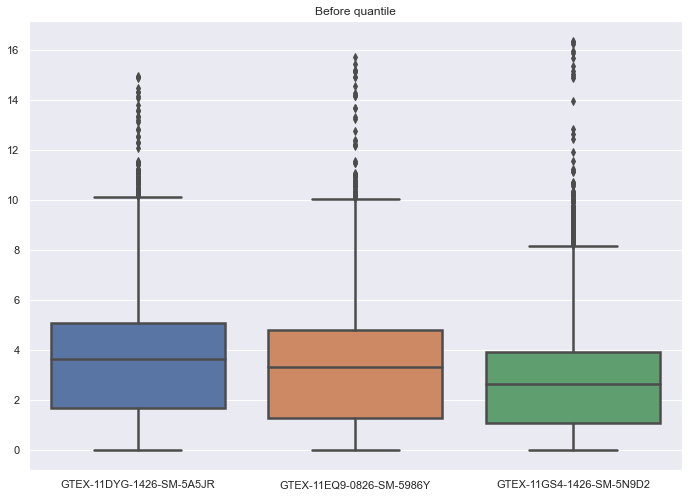

(15845, 96)


GTEX-11DYG-1426-SM-5A5JR  GTEX-11EQ9-0826-SM-5986Y  \
Name                                                                    
ENSG00000186092.4                       0.0                  0.133932   
ENSG00000278566.1                       0.0                  0.000000   

                   GTEX-11GS4-1426-SM-5N9D2  
Name                                         
ENSG00000186092.4                  0.208642  
ENSG00000278566.1                  0.165687

df image after quantile normalization: (15845, 3)


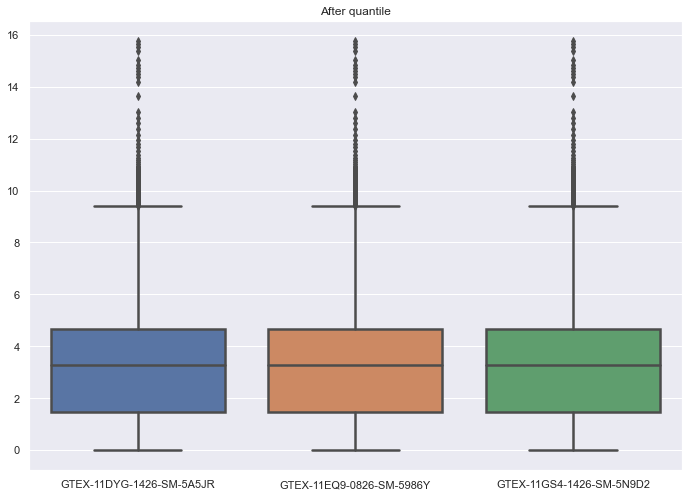

GTEX-11DYG-1426-SM-5A5JR  GTEX-11EQ9-0826-SM-5986Y  \
Name                                                                    
ENSG00000186092.4                       0.0                  0.187711   
ENSG00000278566.1                       0.0                  0.000000   

                   GTEX-11GS4-1426-SM-5N9D2  
Name                                         
ENSG00000186092.4                  0.334103  
ENSG00000278566.1                  0.261484

(96, 8)


In [10]:
os.chdir('Tissues')
for i in range(number_of_tissues):
    current_tissue = order_des_tissue[i] 
    current_tissue = current_tissue[:length_threshold]
    current_raw = current_tissue  +'/Raw'
    current_processed = current_tissue  +'/Processed'
    current_3way = current_tissue +'/3WayDictionary'
    current_Rprocess = current_tissue+'/RProcessedNumber2'
    current_Ena  = current_tissue + '/Enrichment Analysis'
    current_DFrame = current_tissue+'/DataFrames'
    
    #print(os.getcwd())
    #print(os.listdir())
    os.chdir(current_raw)
    #print(i)
    #print(os.getcwd())
    matrix = pd.read_csv('tissue_matrix_DT1DT2.csv', index_col=0)
    sample = pd.read_csv('tissue_sample_DT1DT2.csv', index_col=0)
    df = matrix.T
    #print(df.shape)
    df_outlier, df_sample = sample_outliers_df(matrix,sample)
    #print(df_outlier.shape)
    #print(df_sample.shape)
    
    df = df_outlier
    df = df.T
    sample = df_sample
    ## to create a new function that will remove outliers
    '''
    1
    run function here based on PCA and selecting 1% extremities
    will do this tonight
    '''
    ###
    variability_df = df.var()
    print(variability_df)
    #display(variability_df.head(10))

    gene_names = variability_df.index.tolist()
    gene_vars = variability_df.tolist()


    excluded_list = create_exclusion_list(gene_names,gene_vars,variability_threshold)
    print('length of excluded list')
    print(len(excluded_list))
    
    df3 = df.drop(excluded_list, axis=1)
    sample3 = sample.copy(deep=True)
    #print(df.shape)
    #print(df3.shape)
    ###
    '''
    3
    quantile normalization
    '''
    df3 =df3.T
    df4 = quantile_normalize(df3)
    sample4 = sample3.copy(deep=True)
    ###
    '''
    
    4
    make modifications to phenotype attributes
    '''
    sample4 = sample3.copy(deep=True)
    print(sample4.shape)
    #display(sample4.head(2))
    agegroup = sample4['AGE'].tolist()
    #g2 = [elem[:12] for elem in g]
    agegroup = [elem[:1] for elem in agegroup]
    #print(agegroup)
    sample4['AGE'] = agegroup 
    #display(sample4.head(2))
    DTHHRDY = pd.get_dummies(sample4['DTHHRDY'],drop_first=True)
    SMGEBTCH= sample4['SMGEBTCH'].value_counts(normalize=False, sort=True)
    #display(SMGEBTCH.head(10))
    SMGEBTCH_names = SMGEBTCH.index.tolist()
    SMGEBTCH_value =  SMGEBTCH.tolist()
    SMGEBTCH_new_list  = []
    for i in range (len(SMGEBTCH_names)):
        if SMGEBTCH_value[i] > 1:
            SMGEBTCH_new_list.append(SMGEBTCH_names[i])
    #print("length")
    #print(len(SMGEBTCH_new_list))  
    
    batches = []
    for i in range(sample4.shape[0]):
    
        if sample4['SMGEBTCH'].iloc[i] in SMGEBTCH_new_list:
            batches.append(sample4['SMGEBTCH'].iloc[i])
        else:
            batches.append('ASINGLETON_SMGEBTCH')
    
    sample4['SMGEBTCH'] = batches
    #display(sample4.sample(20))
    SMGEBTCH = pd.get_dummies(sample4['SMGEBTCH'],drop_first=True)
    sample4.drop(['SMTSD','SMGEBTCH','SUBJID','DTHHRDY'], axis=1, inplace=True)
    #display(sample4.head(2))
    new_sample5 = [sample4,DTHHRDY,SMGEBTCH]
    sample5 = pd.concat(new_sample5 , join='inner', axis=1)
    
    
    os.chdir(parent_dir)
    os.chdir('Tissues')
    os.chdir(current_raw)
    df4.to_csv('tissue_matrix_preReg.csv')
    sample5.to_csv('tissue_sample_preReg.csv')
    
    #display(sample5.head(2))
    
    
    ###


    os.chdir(parent_dir)
    os.chdir('Tissues')
    #print(os.getcwd())
os.chdir(parent_dir)    

In [11]:
print('done')

done
